# 🚀 ViT-FishID: MAE Pretraining + EMA Student-Teacher Training

**ADVANCED FISH CLASSIFICATION WITH MASKED AUTOENCODERS & SEMI-SUPERVISED LEARNING**

<a href="https://colab.research.google.com/github/cat-thomson/ViT-FishID/blob/main/ViT_FishID_MAE_EMA_Training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 🎯 Training Pipeline Overview

This notebook implements a comprehensive two-stage training approach:

**Stage 1: Masked Autoencoder (MAE) Pretraining** 🎭
- Self-supervised pretraining on unlabeled fish images
- Learns robust visual representations by reconstructing masked patches
- Uses 75% masking ratio for strong representation learning
- Expected training time: 2-3 hours

**Stage 2: EMA Student-Teacher Semi-Supervised Learning** 🎓
- Fine-tunes MAE-pretrained backbone for fish classification
- Combines labeled supervision with unlabeled consistency learning
- Uses exponential moving average teacher for pseudo-labeling
- Expected training time: 4-6 hours

## 📊 Expected Performance Improvements

- **Without MAE**: ~75-80% accuracy after 100 epochs
- **With MAE + EMA**: ~85-92% accuracy after 100 epochs
- **Data efficiency**: Better performance with limited labeled data
- **Generalization**: Improved robustness to unseen fish species

## 🛠️ Requirements

- **GPU**: Colab Pro recommended (T4/V100/A100)
- **Memory**: ~12-16GB GPU memory
- **Runtime**: 6-9 hours total training time
- **Data**: Fish cutouts dataset with labeled/unlabeled images

## 🔧 Section 1: Environment Setup and GPU Check

Setting up the optimal environment for MAE pretraining and EMA training.

In [2]:
# Basic environment setup and GPU check (lightweight)
import sys
import os
import platform

print("🔍 BASIC SYSTEM INFORMATION")
print("="*50)

# System info (no heavy imports)
print(f"Python version: {sys.version}")
print(f"Platform: {platform.platform()}")
print(f"Architecture: {platform.machine()}")

# Check if we're in Colab
try:
    import google.colab
    IN_COLAB = True
    print("✅ Running in Google Colab")
    
    # Check Colab GPU status
    try:
        gpu_info = !nvidia-smi
        print("✅ nvidia-smi available - GPU runtime detected")
    except:
        print("⚠️  nvidia-smi not available - may be CPU runtime")
        print("   Please enable GPU: Runtime → Change runtime type → GPU")
    
except ImportError:
    IN_COLAB = False
    print("ℹ️  Not running in Google Colab")

print("\n🎯 Training Pipeline Overview:")
print("  - Stage 1: MAE Pretraining (Self-supervised)")
print("  - Stage 2: EMA Student-Teacher (Semi-supervised)")
print("  - Expected total time: 6-9 hours")
print("  - Memory requirements: 8-12GB GPU (optimized)")

print("\n⚠️  IMPORTANT SETUP NOTES:")
print("1. Ensure GPU runtime is enabled")
print("2. Upload fish_cutouts.zip to Google Drive root")
print("3. Allow kernel restart in Section 2 (this fixes CUDNN issues)")
print("4. Section 1 should run in <30 seconds")

print("\n✅ Basic environment check complete!")
print("🚀 Proceed to Section 2 to mount Drive and install dependencies")

🔍 BASIC SYSTEM INFORMATION
Python version: 3.13.5 (main, Jun 11 2025, 15:36:57) [Clang 17.0.0 (clang-1700.0.13.3)]
Platform: macOS-15.5-arm64-arm-64bit-Mach-O
Architecture: arm64
ℹ️  Not running in Google Colab

🎯 Training Pipeline Overview:
  - Stage 1: MAE Pretraining (Self-supervised)
  - Stage 2: EMA Student-Teacher (Semi-supervised)
  - Expected total time: 6-9 hours
  - Memory requirements: 8-12GB GPU (optimized)

⚠️  IMPORTANT SETUP NOTES:
1. Ensure GPU runtime is enabled
2. Upload fish_cutouts.zip to Google Drive root
3. Allow kernel restart in Section 2 (this fixes CUDNN issues)
4. Section 1 should run in <30 seconds

✅ Basic environment check complete!
🚀 Proceed to Section 2 to mount Drive and install dependencies


## 🚨 TROUBLESHOOTING: If Section 1 is Running Too Long

**If the previous cell has been executing for >2 minutes:**

1. **INTERRUPT THE CELL**: Click the ⏹️ **Stop** button in Colab
2. **RESTART RUNTIME**: Runtime → Restart Runtime  
3. **RE-RUN**: Execute the cell again

**Common causes of long execution:**
- Missing GPU runtime (switches to slow CPU mode)
- Automatic package installation in background
- Import conflicts from previous runs

**Expected behavior:**
- Section 1 should complete in **<30 seconds**
- Should show "✅ Basic environment check complete!"
- No heavy library imports (PyTorch comes later)

**Next steps after Section 1:**
1. Section 2: Mount Google Drive (quick)
2. Section 2: Install Dependencies (will restart kernel - normal!)
3. Section 2: Verify Installation (checks PyTorch/CUDA)
4. Then proceed with data setup and MAE training

## 📁 Section 2: Mount Google Drive and Install Dependencies

Setting up data access and installing packages for MAE and EMA training.

In [3]:
# Setup local data access (adapted for local execution)
import os
import sys

print("📁 SETTING UP LOCAL DATA ACCESS")
print("="*50)

# Set up local paths based on your existing configuration
project_root = "/Users/catalinathomson/Desktop/Fish/ViT-FishID"
data_dir = "/Users/catalinathomson/Desktop/Fish/ViT-FishID/fish_cutouts"

print(f"🏠 Project root: {project_root}")
print(f"📂 Data directory: {data_dir}")

# Check if we're in the right directory
if os.path.exists(project_root):
    os.chdir(project_root)
    print(f"✅ Changed to project directory: {os.getcwd()}")
else:
    print(f"❌ Project directory not found: {project_root}")
    raise FileNotFoundError("Project directory not found")

# Add project to Python path
if project_root not in sys.path:
    sys.path.insert(0, project_root)
    print("✅ Added project to Python path")

# Verify data structure
if os.path.exists(data_dir):
    print(f"✅ Data directory found: {data_dir}")
    
    # Check for labeled and unlabeled directories
    labeled_dir = os.path.join(data_dir, 'labeled')
    unlabeled_dir = os.path.join(data_dir, 'unlabeled')
    
    if os.path.exists(labeled_dir):
        species = [d for d in os.listdir(labeled_dir) 
                  if os.path.isdir(os.path.join(labeled_dir, d)) and not d.startswith('.')]
        total_labeled = sum([len([f for f in os.listdir(os.path.join(labeled_dir, s))
                                if f.lower().endswith(('.jpg', '.jpeg', '.png'))])
                            for s in species])
        print(f"🐟 Found {len(species)} species with {total_labeled} labeled images")
    else:
        print(f"⚠️  Labeled directory not found: {labeled_dir}")
    
    if os.path.exists(unlabeled_dir):
        unlabeled_count = len([f for f in os.listdir(unlabeled_dir)
                             if f.lower().endswith(('.jpg', '.jpeg', '.png'))])
        print(f"📊 Found {unlabeled_count} unlabeled images for MAE pretraining")
    else:
        print(f"⚠️  Unlabeled directory not found: {unlabeled_dir}")
        print("   Creating unlabeled directory from existing labeled data...")
        # We'll create this later if needed
        
else:
    print(f"❌ Data directory not found: {data_dir}")
    print("   Please ensure fish_cutouts directory exists in project root")
    raise FileNotFoundError("Data directory not found")

# Check for existing checkpoints
checkpoint_dir = os.path.join(project_root, 'local_checkpoints')
if os.path.exists(checkpoint_dir):
    checkpoints = [f for f in os.listdir(checkpoint_dir) if f.endswith('.pth')]
    print(f"💾 Found {len(checkpoints)} existing checkpoints")
else:
    print("📁 No existing checkpoints found")

print("\n💡 Local environment ready for MAE training!")

📁 SETTING UP LOCAL DATA ACCESS
🏠 Project root: /Users/catalinathomson/Desktop/Fish/ViT-FishID
📂 Data directory: /Users/catalinathomson/Desktop/Fish/ViT-FishID/fish_cutouts
✅ Changed to project directory: /Users/catalinathomson/Desktop/Fish/ViT-FishID
✅ Added project to Python path
✅ Data directory found: /Users/catalinathomson/Desktop/Fish/ViT-FishID/fish_cutouts
🐟 Found 37 species with 5142 labeled images
📊 Found 24015 unlabeled images for MAE pretraining
💾 Found 63 existing checkpoints

💡 Local environment ready for MAE training!


In [4]:
# Verify local dependencies (adapted for local execution)
import importlib
import sys

print("📦 VERIFYING LOCAL DEPENDENCIES")
print("="*50)

# Critical packages for MAE training
required_packages = [
    ('torch', 'PyTorch'),
    ('torchvision', 'TorchVision'),
    ('timm', 'Timm (PyTorch Image Models)'),
    ('transformers', 'HuggingFace Transformers'),
    ('albumentations', 'Albumentations'),
    ('cv2', 'OpenCV'),
    ('sklearn', 'Scikit-learn'),
    ('matplotlib', 'Matplotlib'),
    ('numpy', 'NumPy'),
    ('PIL', 'Pillow'),
    ('tqdm', 'TQDM')
]

print("🧪 Testing package imports...")
working_packages = []
failed_packages = []

for package, name in required_packages:
    try:
        module = importlib.import_module(package)
        version = getattr(module, '__version__', 'Unknown')
        print(f"✅ {name}: {version}")
        working_packages.append(name)
    except ImportError as e:
        print(f"❌ {name}: Failed to import ({e})")
        failed_packages.append(name)

print(f"\n📊 DEPENDENCY STATUS")
print("="*30)
print(f"✅ Working: {len(working_packages)}/{len(required_packages)}")

if failed_packages:
    print(f"❌ Failed: {', '.join(failed_packages)}")
    print("\n🔧 To install missing packages:")
    for package, name in required_packages:
        if name in failed_packages:
            print(f"  pip install {package}")
else:
    print("🎉 All required packages are available!")

print(f"\n✅ LOCAL DEPENDENCY CHECK COMPLETE!")
print("🚀 All dependencies ready for MAE training!")

📦 VERIFYING LOCAL DEPENDENCIES
🧪 Testing package imports...
✅ PyTorch: 2.8.0
✅ PyTorch: 2.8.0
✅ TorchVision: 0.23.0
✅ TorchVision: 0.23.0


/Users/catalinathomson/Desktop/Fish/ViT-FishID/venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


✅ Timm (PyTorch Image Models): 1.0.19
✅ HuggingFace Transformers: 4.55.2
✅ HuggingFace Transformers: 4.55.2
✅ Albumentations: 2.0.8
✅ OpenCV: 4.12.0
✅ Albumentations: 2.0.8
✅ OpenCV: 4.12.0
✅ Scikit-learn: 1.7.1
✅ Matplotlib: 3.10.5
✅ NumPy: 2.2.6
✅ Pillow: 11.3.0
✅ TQDM: 4.67.1

📊 DEPENDENCY STATUS
✅ Working: 11/11
🎉 All required packages are available!

✅ LOCAL DEPENDENCY CHECK COMPLETE!
🚀 All dependencies ready for MAE training!
✅ Scikit-learn: 1.7.1
✅ Matplotlib: 3.10.5
✅ NumPy: 2.2.6
✅ Pillow: 11.3.0
✅ TQDM: 4.67.1

📊 DEPENDENCY STATUS
✅ Working: 11/11
🎉 All required packages are available!

✅ LOCAL DEPENDENCY CHECK COMPLETE!
🚀 All dependencies ready for MAE training!


## 🚨 **TROUBLESHOOTING: Dependency Installation Issues**

### **If the previous cell shows a dotted line and won't run:**

**Immediate Solutions:**

1. **Interrupt the Cell**: 
   - Click ⏹️ **Stop** button in Colab
   - Or press **Ctrl+M I** (Cmd+M I on Mac)

2. **Restart Runtime**:
   - Go to **Runtime → Restart Runtime**
   - Then re-run the cell

3. **Alternative: Manual Step-by-Step Installation**:
   ```python
   # Run these one at a time if needed:
   !pip install torch torchvision torchaudio
   !pip install timm transformers albumentations
   !pip install opencv-python-headless scikit-learn
   !pip install matplotlib seaborn tqdm wandb
   ```

### **Why the dotted line appears:**
- Colab is waiting for pip uninstall confirmation  
- Large package downloads are taking time
- Network connectivity issues
- Kernel is processing heavy installations

### **Fixed approach benefits:**
- ✅ No forced kernel restart (was causing hang)
- ✅ No aggressive PyTorch uninstall (was causing permission issues) 
- ✅ Step-by-step with timeout handling
- ✅ Error recovery and fallback options
- ✅ Progress feedback every step

### **Success indicators to look for:**
```
✅ Current PyTorch version: 2.x.x
✅ CUDA is available with current installation  
✅ All critical imports working!
🚀 No kernel restart needed
```

**Expected execution time: 2-4 minutes (much faster than before)**

In [5]:
# Setup PyTorch environment for local execution (Mac MPS)
import torch
import torchvision
import timm
import transformers
import albumentations
import cv2
import sklearn
import matplotlib.pyplot as plt
import numpy as np
import gc

print("📋 PYTORCH ENVIRONMENT SETUP (LOCAL)")
print("="*50)

print("✅ Package Versions:")
print(f"  torch: {torch.__version__}")
print(f"  torchvision: {torchvision.__version__}")
print(f"  timm: {timm.__version__}")
print(f"  transformers: {transformers.__version__}")
print(f"  albumentations: {albumentations.__version__}")
print(f"  opencv: {cv2.__version__}")
print(f"  sklearn: {sklearn.__version__}")

# Device detection and setup for Mac
print(f"\n🔍 DEVICE DETECTION")
print("="*30)

# Check available devices
print(f"CUDA available: {torch.cuda.is_available()}")
print(f"MPS available: {torch.backends.mps.is_available()}")

# Select optimal device based on your training configuration
if torch.backends.mps.is_available():
    DEVICE = torch.device('mps')
    device_name = "Apple Silicon GPU (MPS)"
    print(f"✅ Using Apple Silicon GPU (MPS)")
    print(f"🎯 This matches your EMA training device configuration")
    
elif torch.cuda.is_available():
    DEVICE = torch.device('cuda')
    device_name = f"CUDA GPU: {torch.cuda.get_device_name(0)}"
    print(f"✅ Using CUDA GPU: {torch.cuda.get_device_name(0)}")
    
else:
    DEVICE = torch.device('cpu')
    device_name = "CPU"
    print("⚠️  Using CPU - training will be slower")
    print("   For Mac: Consider using MPS if available")

# Test device functionality
print(f"\n🧪 TESTING DEVICE OPERATIONS")
print("="*30)

try:
    # Test tensor operations on selected device
    test_tensor = torch.randn(2, 3, 224, 224).to(DEVICE)
    
    # Test basic operations
    result = test_tensor * 2.0
    result = result.sum()
    
    print(f"✅ Device operations working correctly on {device_name}")
    print(f"📊 Test tensor shape: {test_tensor.shape}")
    print(f"📊 Device: {test_tensor.device}")
    
    # Clean up
    del test_tensor, result
    
    if DEVICE.type == 'mps':
        # MPS-specific cleanup
        torch.mps.empty_cache()
    elif DEVICE.type == 'cuda':
        torch.cuda.empty_cache()
    
    gc.collect()
    print("✅ Memory cleanup completed")
    
except Exception as e:
    print(f"❌ Device test failed: {e}")
    print("🔧 Falling back to CPU")
    DEVICE = torch.device('cpu')

# Set random seeds for reproducibility (matching your config)
torch.manual_seed(42)
np.random.seed(42)
if DEVICE.type == 'cuda':
    torch.cuda.manual_seed(42)
elif DEVICE.type == 'mps':
    torch.mps.manual_seed(42)

print(f"\n🎯 Using device: {DEVICE}")
print("💡 Device setup matches your EMA training configuration")

# Global configuration matching your training setup
CONFIG = {
    'device': DEVICE,
    'batch_size': 8,  # Same as your EMA training
    'learning_rate': 1e-4,  # Same as your EMA training
    'num_classes': 37,  # Same as your dataset
    'image_size': 224,  # Same as your training
    'num_workers': 2,  # Same as your training
    'seed': 42,  # Same as your training
}

print(f"\n🚀 PyTorch environment ready for MAE training!")
print("💡 Configuration matches your EMA teacher-student setup!")

# Store global variables for later cells
globals().update({
    'DEVICE': DEVICE,
    'CONFIG': CONFIG
})

📋 PYTORCH ENVIRONMENT SETUP (LOCAL)
✅ Package Versions:
  torch: 2.8.0
  torchvision: 0.23.0
  timm: 1.0.19
  transformers: 4.55.2
  albumentations: 2.0.8
  opencv: 4.12.0
  sklearn: 1.7.1

🔍 DEVICE DETECTION
CUDA available: False
MPS available: True
✅ Using Apple Silicon GPU (MPS)
🎯 This matches your EMA training device configuration

🧪 TESTING DEVICE OPERATIONS
✅ Device operations working correctly on Apple Silicon GPU (MPS)
📊 Test tensor shape: torch.Size([2, 3, 224, 224])
📊 Device: mps:0
✅ Memory cleanup completed

🎯 Using device: mps
💡 Device setup matches your EMA training configuration

🚀 PyTorch environment ready for MAE training!
💡 Configuration matches your EMA teacher-student setup!
✅ Device operations working correctly on Apple Silicon GPU (MPS)
📊 Test tensor shape: torch.Size([2, 3, 224, 224])
📊 Device: mps:0
✅ Memory cleanup completed

🎯 Using device: mps
💡 Device setup matches your EMA training configuration

🚀 PyTorch environment ready for MAE training!
💡 Configuration 

## 🔄 Section 3: Clone Repository and Setup Data

Cloning ViT-FishID repository and preparing fish dataset for MAE pretraining and classification.

In [6]:
# Clone ViT-FishID repository and prepare codebase
import os

print("📥 CLONING ViT-FishID REPOSITORY")
print("="*50)

# Remove existing directory if it exists
if os.path.exists('/content/ViT-FishID'):
    !rm -rf /content/ViT-FishID
    print("🗑️  Removed existing repository")

# Clone the repository
print("📥 Cloning ViT-FishID repository...")
!git clone https://github.com/cat-thomson/ViT-FishID.git /content/ViT-FishID

# Change to project directory
%cd /content/ViT-FishID

# Verify repository structure
print("\n📂 Repository structure:")
!ls -la

# Check for key files
required_files = ['model.py', 'trainer.py', 'data.py', 'train.py']
missing_files = []

for file in required_files:
    if os.path.exists(file):
        print(f"✅ Found: {file}")
    else:
        print(f"❌ Missing: {file}")
        missing_files.append(file)

if missing_files:
    print(f"\n⚠️  Missing files: {missing_files}")
    print("   These will be created as part of the MAE implementation")
else:
    print("\n✅ All required files found!")

# Set up Python path for imports
import sys
if '/content/ViT-FishID' not in sys.path:
    sys.path.append('/content/ViT-FishID')
    print("🔧 Added repository to Python path")

print("\n🚀 Repository ready for MAE and EMA implementation!")

📥 CLONING ViT-FishID REPOSITORY
📥 Cloning ViT-FishID repository...
fatal: could not create leading directories of '/content/ViT-FishID': Read-only file system
[Errno 2] No such file or directory: '/content/ViT-FishID'
/Users/catalinathomson/Desktop/Fish/ViT-FishID

📂 Repository structure:
total 3135328
drwxr-xr-x@  35 catalinathomson  staff        1120 Aug 18 18:47 .
drwxr-xr-x    8 catalinathomson  staff         256 Aug 12 21:27 ..
-rw-r--r--@   1 catalinathomson  staff        8196 Aug 18 18:32 .DS_Store
drwxr-xr-x@  15 catalinathomson  staff         480 Aug 18 18:47 .git
-rw-r--r--@   1 catalinathomson  staff          66 Jul 31 10:30 .gitattributes
-rw-r--r--@   1 catalinathomson  staff         646 Aug  5 15:33 .gitignore
-rw-r--r--@   1 catalinathomson  staff        4182 Aug 16 15:59 COLAB_CRASH_FIXES.md
-rw-r--r--@   1 catalinathomson  staff        3328 Aug 13 21:33 EXTENDED_TRAINING_SETUP.md
-rw-r--r--@   1 catalinathomson  staff           0 Aug 18 10:05 MAE_INTEGRATION_GUIDE.md
-

In [8]:
# Setup fish dataset for local MAE + EMA training (with Unicode error handling)
import os
from pathlib import Path

print("🐟 SETTING UP LOCAL FISH DATASET")
print("="*50)

# Use your existing local data structure
DATA_DIR = '/Users/catalinathomson/Desktop/Fish/ViT-FishID/fish_cutouts'
labeled_dir = os.path.join(DATA_DIR, 'labeled')
unlabeled_dir = os.path.join(DATA_DIR, 'unlabeled')

print(f"🎯 Data directory: {DATA_DIR}")
print(f"🎯 Labeled directory: {labeled_dir}")
print(f"🎯 Unlabeled directory: {unlabeled_dir}")

def safe_listdir(path):
    """Safely list directory contents, handling Unicode errors."""
    try:
        items = []
        for item in os.listdir(path):
            try:
                # Test if item name can be encoded/decoded properly
                item.encode('utf-8')
                items.append(item)
            except UnicodeEncodeError:
                print(f"⚠️  Skipping file with invalid Unicode: {repr(item)}")
                continue
        return items
    except Exception as e:
        print(f"❌ Error listing directory {path}: {e}")
        return []

def count_images_safe(directory):
    """Safely count images in a directory."""
    count = 0
    for item in safe_listdir(directory):
        if item.lower().endswith(('.jpg', '.jpeg', '.png', '.JPG', '.JPEG', '.PNG')):
            count += 1
    return count

# Verify dataset structure
if os.path.exists(DATA_DIR):
    print("✅ Data directory found!")
    
    # Check labeled data
    if os.path.exists(labeled_dir):
        species = []
        for item in safe_listdir(labeled_dir):
            species_path = os.path.join(labeled_dir, item)
            if os.path.isdir(species_path) and not item.startswith('.'):
                species.append(item)
        
        print(f"\n🐟 LABELED DATA ANALYSIS")
        print("="*30)
        print(f"Species found: {len(species)}")
        
        # Count images per species (first 10)
        total_labeled = 0
        species_distribution = []
        
        for species_name in species:
            species_path = os.path.join(labeled_dir, species_name)
            if os.path.isdir(species_path):
                count = count_images_safe(species_path)
                species_distribution.append((species_name, count))
                total_labeled += count
        
        # Sort by count
        species_distribution.sort(key=lambda x: x[1], reverse=True)
        
        print(f"Total labeled images: {total_labeled}")
        print(f"\nTop 10 species by image count:")
        for i, (species_name, count) in enumerate(species_distribution[:10]):
            print(f"  {i+1:2d}. {species_name}: {count} images")
        
        if len(species_distribution) > 10:
            print(f"  ... and {len(species_distribution) - 10} more species")
    
    else:
        print("❌ Labeled directory not found")
        raise FileNotFoundError("Labeled data directory missing")
    
    # Check unlabeled data
    if os.path.exists(unlabeled_dir):
        unlabeled_count = count_images_safe(unlabeled_dir)
        
        print(f"\n📊 UNLABELED DATA FOR MAE")
        print("="*30)
        print(f"Unlabeled images: {unlabeled_count}")
        print("✅ Perfect for MAE self-supervised pretraining!")
    else:
        print("\n⚠️  Unlabeled directory not found")
        print("   This is fine - MAE can work with labeled data too")
        unlabeled_count = 0
    
else:
    print("❌ Data directory not found")
    raise FileNotFoundError("Dataset not found")

# Final dataset summary matching your configuration
print(f"\n📊 DATASET SUMMARY (MATCHING YOUR EMA CONFIG)")
print("="*50)
print(f"✅ Number of classes: {len(species)}")
print(f"✅ Total labeled images: {total_labeled}")
print(f"✅ Unlabeled images for MAE: {unlabeled_count}")
print(f"✅ Image size: 224x224 (matches your config)")
print(f"✅ Data ready for MAE pretraining + EMA fine-tuning!")

# Store global variables for later use (matching your config)
LABELED_DIR = labeled_dir
UNLABELED_DIR = unlabeled_dir
NUM_CLASSES = len(species)

# Verify it matches your training config
if NUM_CLASSES == CONFIG['num_classes']:
    print(f"\n✅ Class count verification: {NUM_CLASSES} classes matches your EMA training!")
else:
    print(f"\n⚠️  Class count mismatch: Found {NUM_CLASSES}, expected {CONFIG['num_classes']}")
    print(f"   Updating CONFIG to match actual dataset...")
    CONFIG['num_classes'] = NUM_CLASSES

print(f"\n🎯 Dataset configuration ready for MAE pretraining!")

# Store in globals
globals().update({
    'LABELED_DIR': LABELED_DIR,
    'UNLABELED_DIR': UNLABELED_DIR,
    'NUM_CLASSES': NUM_CLASSES,
    'species': species
})

🐟 SETTING UP LOCAL FISH DATASET
🎯 Data directory: /Users/catalinathomson/Desktop/Fish/ViT-FishID/fish_cutouts
🎯 Labeled directory: /Users/catalinathomson/Desktop/Fish/ViT-FishID/fish_cutouts/labeled
🎯 Unlabeled directory: /Users/catalinathomson/Desktop/Fish/ViT-FishID/fish_cutouts/unlabeled
✅ Data directory found!

🐟 LABELED DATA ANALYSIS
Species found: 37
Total labeled images: 5142

Top 10 species by image count:
   1. Sparidae_Chrysoblephus_puniceus: 1013 images
   2. Sparidae_Diplodus_capensis: 747 images
   3. Sparidae_Porcostoma_dentata: 447 images
   4. Sparidae_Boopsoidea_inornata: 370 images
   5. Sparidae_Chrysoblephus_anglicus: 366 images
   6. Sparidae_Sarpa_salpa: 319 images
   7. Sparidae_Cheimerius_nufar: 270 images
   8. Sparidae_Polysteganus_praeorbitalis: 256 images
   9. Carangidae_Trachurus_delagoa: 207 images
  10. Sparidae_Pachymetopon_aeneum: 205 images
  ... and 27 more species

📊 UNLABELED DATA FOR MAE
Unlabeled images: 24015
✅ Perfect for MAE self-supervised pr

## 🎭 Section 4: Implement Masked Autoencoder (MAE) Components

Creating the complete MAE architecture with ViT encoder, lightweight decoder, and masking strategy.

In [9]:
# MPS-Optimized MAE Implementation for Local Training
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import time
from typing import Optional, Tuple

print("🎭 CREATING MPS-OPTIMIZED MAE COMPONENTS")
print("="*50)

# MPS-friendly implementations
class PatchEmbedding(nn.Module):
    """MPS-optimized Image to Patch Embedding"""
    
    def __init__(self, img_size=224, patch_size=16, in_chans=3, embed_dim=384):
        super().__init__()
        self.img_size = img_size
        self.patch_size = patch_size
        self.num_patches = (img_size // patch_size) ** 2
        
        # Use smaller embedding dimension for MPS efficiency
        self.proj = nn.Conv2d(in_chans, embed_dim, 
                             kernel_size=patch_size, stride=patch_size)
        
    def forward(self, x):
        B, C, H, W = x.shape
        x = self.proj(x)  # (B, embed_dim, H/patch_size, W/patch_size)
        x = x.flatten(2).transpose(1, 2)  # (B, num_patches, embed_dim)
        return x

class SimpleAttention(nn.Module):
    """Simplified attention for MPS compatibility"""
    def __init__(self, embed_dim, num_heads, dropout=0.1):
        super().__init__()
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.head_dim = embed_dim // num_heads
        self.scale = self.head_dim ** -0.5
        
        self.qkv = nn.Linear(embed_dim, embed_dim * 3, bias=True)
        self.proj = nn.Linear(embed_dim, embed_dim)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x):
        B, N, C = x.shape
        
        # Generate Q, K, V
        qkv = self.qkv(x).reshape(B, N, 3, self.num_heads, self.head_dim)
        qkv = qkv.permute(2, 0, 3, 1, 4)  # (3, B, num_heads, N, head_dim)
        q, k, v = qkv.unbind(0)
        
        # Attention computation (MPS-friendly)
        attn = torch.matmul(q, k.transpose(-2, -1)) * self.scale
        attn = F.softmax(attn, dim=-1)
        attn = self.dropout(attn)
        
        # Apply attention to values
        x = torch.matmul(attn, v)
        x = x.transpose(1, 2).reshape(B, N, C)
        x = self.proj(x)
        x = self.dropout(x)
        
        return x

class SimpleTransformerBlock(nn.Module):
    """MPS-optimized transformer block"""
    def __init__(self, embed_dim, num_heads, mlp_ratio=4.0, dropout=0.1):
        super().__init__()
        self.norm1 = nn.LayerNorm(embed_dim)
        self.attn = SimpleAttention(embed_dim, num_heads, dropout)
        self.norm2 = nn.LayerNorm(embed_dim)
        
        mlp_hidden_dim = int(embed_dim * mlp_ratio)
        self.mlp = nn.Sequential(
            nn.Linear(embed_dim, mlp_hidden_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(mlp_hidden_dim, embed_dim),
            nn.Dropout(dropout)
        )
        
    def forward(self, x):
        # Pre-norm architecture for better training
        x = x + self.attn(self.norm1(x))
        x = x + self.mlp(self.norm2(x))
        return x

class MPSOptimizedMAE(nn.Module):
    """Complete MAE optimized for Apple Silicon MPS"""
    
    def __init__(self,
                 img_size=224,
                 patch_size=16,
                 embed_dim=384,  # Smaller for MPS efficiency
                 depth=6,        # Reduced depth
                 num_heads=6,    # Reduced heads
                 decoder_embed_dim=192,
                 decoder_depth=4,
                 decoder_num_heads=3,
                 mlp_ratio=4.0,
                 norm_pix_loss=False):
        super().__init__()
        
        self.patch_size = patch_size
        self.norm_pix_loss = norm_pix_loss
        self.num_patches = (img_size // patch_size) ** 2
        
        # Encoder
        self.patch_embed = PatchEmbedding(img_size, patch_size, 3, embed_dim)
        
        self.cls_token = nn.Parameter(torch.zeros(1, 1, embed_dim))
        self.pos_embed = nn.Parameter(torch.zeros(1, self.num_patches + 1, embed_dim))
        
        self.blocks = nn.ModuleList([
            SimpleTransformerBlock(embed_dim, num_heads, mlp_ratio)
            for _ in range(depth)
        ])
        self.norm = nn.LayerNorm(embed_dim)
        
        # Decoder
        self.decoder_embed = nn.Linear(embed_dim, decoder_embed_dim, bias=True)
        self.mask_token = nn.Parameter(torch.zeros(1, 1, decoder_embed_dim))
        self.decoder_pos_embed = nn.Parameter(torch.zeros(1, self.num_patches + 1, decoder_embed_dim))
        
        self.decoder_blocks = nn.ModuleList([
            SimpleTransformerBlock(decoder_embed_dim, decoder_num_heads, mlp_ratio)
            for _ in range(decoder_depth)
        ])
        
        self.decoder_norm = nn.LayerNorm(decoder_embed_dim)
        self.decoder_pred = nn.Linear(decoder_embed_dim, patch_size**2 * 3, bias=True)
        
        self._init_weights()
        
        print(f"✅ MPS-Optimized MAE created:")
        print(f"  - Encoder: {embed_dim}d, {depth} layers, {num_heads} heads")
        print(f"  - Decoder: {decoder_embed_dim}d, {decoder_depth} layers, {decoder_num_heads} heads")
        
    def _init_weights(self):
        # Initialize parameters
        torch.nn.init.normal_(self.cls_token, std=.02)
        torch.nn.init.normal_(self.pos_embed, std=.02)
        torch.nn.init.normal_(self.mask_token, std=.02)
        torch.nn.init.normal_(self.decoder_pos_embed, std=.02)
        
        # Initialize linear layers
        for m in self.modules():
            if isinstance(m, nn.Linear):
                torch.nn.init.xavier_uniform_(m.weight)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.LayerNorm):
                nn.init.constant_(m.bias, 0)
                nn.init.constant_(m.weight, 1.0)
    
    def random_masking(self, x, mask_ratio=0.75):
        """Random masking optimized for MPS"""
        B, N, D = x.shape
        len_keep = int(N * (1 - mask_ratio))
        
        # Use CPU for random operations, then move to device
        noise = torch.rand(B, N, device='cpu')
        ids_shuffle = torch.argsort(noise, dim=1).to(x.device)
        ids_restore = torch.argsort(ids_shuffle, dim=1)
        
        # Keep subset
        ids_keep = ids_shuffle[:, :len_keep]
        x_masked = torch.gather(x, dim=1, index=ids_keep.unsqueeze(-1).repeat(1, 1, D))
        
        # Generate mask
        mask = torch.ones([B, N], device=x.device)
        mask[:, :len_keep] = 0
        mask = torch.gather(mask, dim=1, index=ids_restore)
        
        return x_masked, mask, ids_restore
    
    def patchify(self, imgs):
        """Convert images to patches"""
        p = self.patch_size
        assert imgs.shape[2] == imgs.shape[3] and imgs.shape[2] % p == 0
        
        h = w = imgs.shape[2] // p
        x = imgs.reshape(imgs.shape[0], 3, h, p, w, p)
        x = torch.einsum('nchpwq->nhwpqc', x)
        x = x.reshape(imgs.shape[0], h * w, p**2 * 3)
        return x
    
    def unpatchify(self, x):
        """Convert patches back to images"""
        p = self.patch_size
        h = w = int(x.shape[1]**.5)
        assert h * w == x.shape[1]
        
        x = x.reshape(x.shape[0], h, w, p, p, 3)
        x = torch.einsum('nhwpqc->nchpwq', x)
        imgs = x.reshape(x.shape[0], 3, h * p, h * p)
        return imgs
    
    def forward_encoder(self, x, mask_ratio):
        # Patch embedding
        x = self.patch_embed(x)
        
        # Add pos embed without cls token
        x = x + self.pos_embed[:, 1:, :]
        
        # Masking
        x, mask, ids_restore = self.random_masking(x, mask_ratio)
        
        # Append cls token
        cls_token = self.cls_token + self.pos_embed[:, :1, :]
        cls_tokens = cls_token.expand(x.shape[0], -1, -1)
        x = torch.cat((cls_tokens, x), dim=1)
        
        # Apply blocks
        for blk in self.blocks:
            x = blk(x)
        x = self.norm(x)
        
        return x, mask, ids_restore
    
    def forward_decoder(self, x, ids_restore):
        # Embed tokens
        x = self.decoder_embed(x)
        
        # Append mask tokens
        mask_tokens = self.mask_token.repeat(x.shape[0], ids_restore.shape[1] + 1 - x.shape[1], 1)
        x_ = torch.cat([x[:, 1:, :], mask_tokens], dim=1)
        x_ = torch.gather(x_, dim=1, index=ids_restore.unsqueeze(-1).repeat(1, 1, x.shape[2]))
        x = torch.cat([x[:, :1, :], x_], dim=1)
        
        # Add pos embed
        x = x + self.decoder_pos_embed
        
        # Apply blocks
        for blk in self.decoder_blocks:
            x = blk(x)
        x = self.decoder_norm(x)
        
        # Predictor
        x = self.decoder_pred(x)
        x = x[:, 1:, :]  # Remove cls token
        
        return x
    
    def forward_loss(self, imgs, pred, mask):
        """Compute reconstruction loss"""
        target = self.patchify(imgs)
        
        if self.norm_pix_loss:
            mean = target.mean(dim=-1, keepdim=True)
            var = target.var(dim=-1, keepdim=True)
            target = (target - mean) / (var + 1.e-6)**.5
        
        loss = (pred - target) ** 2
        loss = loss.mean(dim=-1)
        loss = (loss * mask).sum() / mask.sum()
        return loss
    
    def forward(self, imgs, mask_ratio=0.75):
        latent, mask, ids_restore = self.forward_encoder(imgs, mask_ratio)
        pred = self.forward_decoder(latent, ids_restore)
        loss = self.forward_loss(imgs, pred, mask)
        return loss, pred, mask

print("🧪 TESTING MPS COMPATIBILITY")
print("="*30)

# Quick test to ensure it works
try:
    start_time = time.time()
    
    print("Creating test model...")
    test_mae = MPSOptimizedMAE().to(DEVICE)
    
    print("Testing forward pass...")
    test_input = torch.randn(1, 3, 224, 224).to(DEVICE)
    
    with torch.no_grad():
        loss, pred, mask = test_mae(test_input, mask_ratio=0.75)
    
    end_time = time.time()
    
    print(f"✅ MPS-optimized MAE test successful!")
    print(f"⏱️  Test completed in {end_time - start_time:.2f} seconds")
    print(f"📊 Loss: {loss.item():.4f}")
    print(f"📊 Prediction shape: {pred.shape}")
    print(f"📊 Mask shape: {mask.shape}")
    
    # Clean up test
    del test_mae, test_input, loss, pred, mask
    if DEVICE.type == 'mps':
        torch.mps.empty_cache()
    
    print("✅ Memory cleaned up")
    
except Exception as e:
    print(f"❌ MPS test failed: {e}")
    print("🔧 Consider reducing model size further")
    raise

print(f"\n🎭 MPS-OPTIMIZED MAE READY!")
print("💡 This should run much faster than the original implementation!")

🎭 CREATING MPS-OPTIMIZED MAE COMPONENTS
🧪 TESTING MPS COMPATIBILITY
Creating test model...
✅ MPS-Optimized MAE created:
  - Encoder: 384d, 6 layers, 6 heads
  - Decoder: 192d, 4 layers, 3 heads
Testing forward pass...
✅ MPS-optimized MAE test successful!
⏱️  Test completed in 2.71 seconds
📊 Loss: 1.3757
📊 Prediction shape: torch.Size([1, 196, 768])
📊 Mask shape: torch.Size([1, 196])
✅ Memory cleaned up

🎭 MPS-OPTIMIZED MAE READY!
💡 This should run much faster than the original implementation!
✅ MPS-optimized MAE test successful!
⏱️  Test completed in 2.71 seconds
📊 Loss: 1.3757
📊 Prediction shape: torch.Size([1, 196, 768])
📊 Mask shape: torch.Size([1, 196])
✅ Memory cleaned up

🎭 MPS-OPTIMIZED MAE READY!
💡 This should run much faster than the original implementation!


## 🚨 **IMMEDIATE ACTION: Cell 14 Running Too Long**

**If the previous cell is still running after 15+ minutes:**

### **🛑 STOP THE CELL RIGHT NOW:**
1. Click the **⏹️ Stop** button next to the running cell
2. Or press **Ctrl+C** in the terminal
3. Or interrupt the kernel: **Kernel → Interrupt**

### **⚡ WHAT WAS WRONG:**
- Original MAE implementation was too complex for MPS (Apple Silicon)
- Heavy tensor operations causing memory pressure
- Xavier weight initialization taking too long
- Complex attention mechanisms not optimized for MPS

### **✅ NEW OPTIMIZED VERSION:**
- **Smaller model**: 384d instead of 512d embeddings
- **Fewer layers**: 6 encoder + 4 decoder layers
- **MPS-friendly operations**: Optimized for Apple Silicon
- **Faster initialization**: Simplified weight init
- **Expected runtime**: 30-60 seconds (not 15+ minutes!)

### **🔧 IF STILL HAVING ISSUES:**
```python
# Emergency fallback - minimal MAE for testing
class MinimalMAE(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 64, 16, 16),  # Patch embedding
            nn.Flatten(),
            nn.Linear(64*196, 256),
            nn.ReLU()
        )
        self.decoder = nn.Linear(256, 3*224*224)
    
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded).view(-1, 3, 224, 224)
        loss = F.mse_loss(decoded, x)
        return loss, decoded, torch.ones(x.shape[0], 196)

# Use this if the optimized version still fails
```

**The new implementation should complete in under 1 minute!**

In [15]:
# 🏗️ Define Complete MAE Architecture (Required for ViT-Base)
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from typing import Optional, Tuple

print("🏗️ DEFINING COMPLETE MAE ARCHITECTURE")
print("="*50)
print("📋 This cell defines all MAE components needed for ViT-Base")
print("🔧 Classes: PatchEmbed, Attention, MLP, TransformerBlock, MAEEncoder, MAEDecoder, MaskedAutoEncoder")

class PatchEmbed(nn.Module):
    """Image to Patch Embedding"""
    def __init__(self, img_size=224, patch_size=16, in_chans=3, embed_dim=768):
        super().__init__()
        self.img_size = img_size
        self.patch_size = patch_size
        self.num_patches = (img_size // patch_size) ** 2
        
        self.proj = nn.Conv2d(in_chans, embed_dim, kernel_size=patch_size, stride=patch_size)
        
    def forward(self, x):
        B, C, H, W = x.shape
        x = self.proj(x).flatten(2).transpose(1, 2)
        return x

class Attention(nn.Module):
    def __init__(self, dim, num_heads=8, qkv_bias=False, attn_drop=0., proj_drop=0.):
        super().__init__()
        self.num_heads = num_heads
        head_dim = dim // num_heads
        self.scale = head_dim ** -0.5

        self.qkv = nn.Linear(dim, dim * 3, bias=qkv_bias)
        self.attn_drop = nn.Dropout(attn_drop)
        self.proj = nn.Linear(dim, dim)
        self.proj_drop = nn.Dropout(proj_drop)

    def forward(self, x):
        B, N, C = x.shape
        qkv = self.qkv(x).reshape(B, N, 3, self.num_heads, C // self.num_heads).permute(2, 0, 3, 1, 4)
        q, k, v = qkv[0], qkv[1], qkv[2]

        attn = (q @ k.transpose(-2, -1)) * self.scale
        attn = attn.softmax(dim=-1)
        attn = self.attn_drop(attn)

        x = (attn @ v).transpose(1, 2).reshape(B, N, C)
        x = self.proj(x)
        x = self.proj_drop(x)
        return x

class MLP(nn.Module):
    def __init__(self, in_features, hidden_features=None, out_features=None, act_layer=nn.GELU, drop=0.):
        super().__init__()
        out_features = out_features or in_features
        hidden_features = hidden_features or in_features
        self.fc1 = nn.Linear(in_features, hidden_features)
        self.act = act_layer()
        self.fc2 = nn.Linear(hidden_features, out_features)
        self.drop = nn.Dropout(drop)

    def forward(self, x):
        x = self.fc1(x)
        x = self.act(x)
        x = self.drop(x)
        x = self.fc2(x)
        x = self.drop(x)
        return x

class TransformerBlock(nn.Module):
    def __init__(self, dim, num_heads, mlp_ratio=4., qkv_bias=False, drop=0., attn_drop=0.):
        super().__init__()
        self.norm1 = nn.LayerNorm(dim)
        self.attn = Attention(dim, num_heads=num_heads, qkv_bias=qkv_bias, attn_drop=attn_drop, proj_drop=drop)
        
        self.norm2 = nn.LayerNorm(dim)
        mlp_hidden_dim = int(dim * mlp_ratio)
        self.mlp = MLP(in_features=dim, hidden_features=mlp_hidden_dim, drop=drop)

    def forward(self, x):
        x = x + self.attn(self.norm1(x))
        x = x + self.mlp(self.norm2(x))
        return x

class MAEEncoder(nn.Module):
    """MAE Encoder"""
    def __init__(self, img_size=224, patch_size=16, embed_dim=768, depth=12, num_heads=12, mlp_ratio=4.):
        super().__init__()
        
        self.patch_embed = PatchEmbed(img_size, patch_size, 3, embed_dim)
        num_patches = self.patch_embed.num_patches
        
        self.cls_token = nn.Parameter(torch.zeros(1, 1, embed_dim))
        self.pos_embed = nn.Parameter(torch.zeros(1, num_patches + 1, embed_dim))
        
        self.blocks = nn.ModuleList([
            TransformerBlock(embed_dim, num_heads, mlp_ratio, qkv_bias=True)
            for _ in range(depth)
        ])
        self.norm = nn.LayerNorm(embed_dim)
        
        self.initialize_weights()
        
    def initialize_weights(self):
        # Initialize positional embedding
        torch.nn.init.normal_(self.pos_embed, std=.02)
        torch.nn.init.normal_(self.cls_token, std=.02)
        
        # Initialize patch_embed like nn.Linear
        w = self.patch_embed.proj.weight.data
        torch.nn.init.xavier_uniform_(w.view([w.shape[0], -1]))
        
    def random_masking(self, x, mask_ratio):
        """Random masking for MAE"""
        N, L, D = x.shape  # batch, length, dim
        len_keep = int(L * (1 - mask_ratio))
        
        noise = torch.rand(N, L, device=x.device)  # noise in [0, 1]
        
        # Sort noise for each sample
        ids_shuffle = torch.argsort(noise, dim=1)  # ascend: small is keep, large is remove
        ids_restore = torch.argsort(ids_shuffle, dim=1)

        # Keep the first subset
        ids_keep = ids_shuffle[:, :len_keep]
        x_masked = torch.gather(x, dim=1, index=ids_keep.unsqueeze(-1).repeat(1, 1, D))

        # Generate the binary mask: 0 is keep, 1 is remove
        mask = torch.ones([N, L], device=x.device)
        mask[:, :len_keep] = 0
        mask = torch.gather(mask, dim=1, index=ids_restore)

        return x_masked, mask, ids_restore

    def forward(self, x, mask_ratio):
        # Embed patches
        x = self.patch_embed(x)
        
        # Add pos embed w/o cls token
        x = x + self.pos_embed[:, 1:, :]
        
        # Masking: length -> length * mask_ratio
        x, mask, ids_restore = self.random_masking(x, mask_ratio)
        
        # Append cls token
        cls_token = self.cls_token + self.pos_embed[:, :1, :]
        cls_tokens = cls_token.expand(x.shape[0], -1, -1)
        x = torch.cat((cls_tokens, x), dim=1)
        
        # Apply Transformer blocks
        for blk in self.blocks:
            x = blk(x)
        x = self.norm(x)

        return x, mask, ids_restore

class MAEDecoder(nn.Module):
    """MAE Decoder"""
    def __init__(self, num_patches=196, encoder_embed_dim=768, decoder_embed_dim=512, decoder_depth=8, decoder_num_heads=16, mlp_ratio=4.):
        super().__init__()

        self.decoder_embed = nn.Linear(encoder_embed_dim, decoder_embed_dim, bias=True)
        self.mask_token = nn.Parameter(torch.zeros(1, 1, decoder_embed_dim))
        self.decoder_pos_embed = nn.Parameter(torch.zeros(1, num_patches + 1, decoder_embed_dim))

        self.decoder_blocks = nn.ModuleList([
            TransformerBlock(decoder_embed_dim, decoder_num_heads, mlp_ratio, qkv_bias=True)
            for _ in range(decoder_depth)
        ])

        self.decoder_norm = nn.LayerNorm(decoder_embed_dim)
        self.decoder_pred = nn.Linear(decoder_embed_dim, 16**2 * 3, bias=True)  # patch_size=16
        
        self.initialize_weights()
        
    def initialize_weights(self):
        # Initialize positional embedding
        torch.nn.init.normal_(self.decoder_pos_embed, std=.02)
        torch.nn.init.normal_(self.mask_token, std=.02)

    def forward(self, x, ids_restore):
        # Embed tokens
        x = self.decoder_embed(x)

        # Append mask tokens to sequence
        mask_tokens = self.mask_token.repeat(x.shape[0], ids_restore.shape[1] + 1 - x.shape[1], 1)
        x_ = torch.cat([x[:, 1:, :], mask_tokens], dim=1)  # no cls token
        x_ = torch.gather(x_, dim=1, index=ids_restore.unsqueeze(-1).repeat(1, 1, x.shape[2]))  # unshuffle
        x = torch.cat([x[:, :1, :], x_], dim=1)  # append cls token

        # Add pos embed
        x = x + self.decoder_pos_embed

        # Apply Transformer blocks
        for blk in self.decoder_blocks:
            x = blk(x)
        x = self.decoder_norm(x)

        # Predictor projection
        x = self.decoder_pred(x)

        # Remove cls token
        x = x[:, 1:, :]

        return x

class MaskedAutoEncoder(nn.Module):
    """Complete Masked Autoencoder for ViT-Base and ViT-Small"""
    
    def __init__(self,
                 img_size=224,
                 patch_size=16,
                 encoder_embed_dim=768,   # 768 for ViT-Base, 384 for ViT-Small
                 encoder_depth=12,        # 12 for ViT-Base, 6 for ViT-Small  
                 encoder_num_heads=12,    # 12 for ViT-Base, 6 for ViT-Small
                 decoder_embed_dim=512,   # Decoder embedding dimension
                 decoder_depth=8,         # Decoder depth
                 decoder_num_heads=16,    # Decoder attention heads
                 mlp_ratio=4.0,
                 norm_pix_loss=False):
        super().__init__()
        
        self.patch_size = patch_size
        self.norm_pix_loss = norm_pix_loss
        
        # MAE encoder
        self.encoder = MAEEncoder(
            img_size=img_size,
            patch_size=patch_size,
            embed_dim=encoder_embed_dim,
            depth=encoder_depth,
            num_heads=encoder_num_heads,
            mlp_ratio=mlp_ratio
        )
        
        # MAE decoder
        num_patches = (img_size // patch_size) ** 2
        self.decoder = MAEDecoder(
            num_patches=num_patches,
            encoder_embed_dim=encoder_embed_dim,
            decoder_embed_dim=decoder_embed_dim,
            decoder_depth=decoder_depth,
            decoder_num_heads=decoder_num_heads,
            mlp_ratio=mlp_ratio
        )
    
    def patchify(self, imgs):
        """Convert images to patches"""
        p = self.patch_size
        assert imgs.shape[2] == imgs.shape[3] and imgs.shape[2] % p == 0

        h = w = imgs.shape[2] // p
        x = imgs.reshape(shape=(imgs.shape[0], 3, h, p, w, p))
        x = torch.einsum('nchpwq->nhwpqc', x)
        x = x.reshape(shape=(imgs.shape[0], h * w, p**2 * 3))
        return x
    
    def unpatchify(self, x):
        """Convert patches back to images"""
        p = self.patch_size
        h = w = int(x.shape[1]**.5)
        assert h * w == x.shape[1]
        
        x = x.reshape(shape=(x.shape[0], h, w, p, p, 3))
        x = torch.einsum('nhwpqc->nchpwq', x)
        imgs = x.reshape(shape=(x.shape[0], 3, h * p, h * p))
        return imgs
    
    def forward_loss(self, imgs, pred, mask):
        """Compute reconstruction loss"""
        target = self.patchify(imgs)
        if self.norm_pix_loss:
            mean = target.mean(dim=-1, keepdim=True)
            var = target.var(dim=-1, keepdim=True)
            target = (target - mean) / (var + 1.e-6)**.5
        
        loss = (pred - target) ** 2
        loss = loss.mean(dim=-1)  # [N, L], mean loss per patch
        
        loss = (loss * mask).sum() / mask.sum()  # mean loss on removed patches
        return loss
    
    def forward(self, imgs, mask_ratio=0.75):
        latent, mask, ids_restore = self.encoder(imgs, mask_ratio)
        pred = self.decoder(latent, ids_restore)
        loss = self.forward_loss(imgs, pred, mask)
        return loss, pred, mask, latent

print("✅ Complete MAE Architecture Defined!")
print("🏗️ Components Created:")
print("   ✅ PatchEmbed - Image to patch conversion")
print("   ✅ Attention - Multi-head self-attention")  
print("   ✅ MLP - Feed-forward network")
print("   ✅ TransformerBlock - Complete transformer layer")
print("   ✅ MAEEncoder - ViT encoder with masking")
print("   ✅ MAEDecoder - Lightweight decoder")
print("   ✅ MaskedAutoEncoder - Complete MAE model")
print("\n🚀 Ready to create ViT-Base or ViT-Small models!")
print("="*50)

🏗️ DEFINING COMPLETE MAE ARCHITECTURE
📋 This cell defines all MAE components needed for ViT-Base
🔧 Classes: PatchEmbed, Attention, MLP, TransformerBlock, MAEEncoder, MAEDecoder, MaskedAutoEncoder
✅ Complete MAE Architecture Defined!
🏗️ Components Created:
   ✅ PatchEmbed - Image to patch conversion
   ✅ Attention - Multi-head self-attention
   ✅ MLP - Feed-forward network
   ✅ TransformerBlock - Complete transformer layer
   ✅ MAEEncoder - ViT encoder with masking
   ✅ MAEDecoder - Lightweight decoder
   ✅ MaskedAutoEncoder - Complete MAE model

🚀 Ready to create ViT-Base or ViT-Small models!


In [16]:
# 🔄 Configure MAE for ViT-Base (768-dimensional embeddings)
print("🔧 CONFIGURING MAE FOR ViT-BASE")
print("="*50)
print("🎯 Switching from ViT-Small (384-dim) to ViT-Base (768-dim)")
print("📊 This will provide better feature representation but require more memory")

# Update MAE configuration for ViT-Base
MAE_CONFIG_BASE = {
    # Model architecture (ViT-Base configuration)
    'mask_ratio': 0.75,
    'img_size': 224,
    'patch_size': 16,
    
    # Training parameters (adjusted for ViT-Base)
    'epochs': 50,
    'batch_size': 12,  # Reduced from 16 due to larger model
    'learning_rate': 1e-4,
    'weight_decay': 0.05,
    'warmup_epochs': 5,
    
    # Optimizer settings
    'beta1': 0.9,
    'beta2': 0.95,
    'clip_grad': 1.0,
    
    # Saving and logging
    'save_frequency': 5,
    'save_every_n_batches': 100,
    'log_frequency': 50,
    'num_workers': 0,  # For MPS compatibility
    
    # Directory paths for ViT-Base checkpoints
    'checkpoint_dir': 'mae_base_checkpoints',
    'backup_dir': 'mae_base_backups', 
    'logs_dir': 'mae_base_logs',
    'use_wandb': False,
    'resume_checkpoint': None,
    'auto_resume': False,
}

# Create directories for ViT-Base MAE
os.makedirs(MAE_CONFIG_BASE['checkpoint_dir'], exist_ok=True)
os.makedirs(MAE_CONFIG_BASE['backup_dir'], exist_ok=True)
os.makedirs(MAE_CONFIG_BASE['logs_dir'], exist_ok=True)

print("✅ Created MAE directories for ViT-Base:")
print(f"   📁 Checkpoints: {MAE_CONFIG_BASE['checkpoint_dir']}")
print(f"   📁 Backups: {MAE_CONFIG_BASE['backup_dir']}")
print(f"   📁 Logs: {MAE_CONFIG_BASE['logs_dir']}")

# Compare configurations
print("\n📊 CONFIGURATION COMPARISON:")
print("-"*50)
print(f"{'Aspect':<20} {'ViT-Small (384)':<15} {'ViT-Base (768)'}")
print("-"*50)
print(f"{'Embed Dimension':<20} {'384':<15} {'768'}")
print(f"{'Encoder Depth':<20} {'6':<15} {'12'}")  
print(f"{'Encoder Heads':<20} {'6':<15} {'12'}")
print(f"{'Batch Size':<20} {'16':<15} {MAE_CONFIG_BASE['batch_size']}")
print(f"{'Parameters':<20} {'~22M':<15} {'~86M'}")
print(f"{'Memory Usage':<20} {'~4GB':<15} {'~6-8GB'}")

print("\n🎯 ViT-Base Benefits:")
print("✅ Better feature representation (768-dim vs 384-dim)")
print("✅ More model capacity (86M vs 22M parameters)")
print("✅ Compatible with standard ViT architectures")
print("✅ Better transfer learning potential")

print("\n⚠️  ViT-Base Considerations:")  
print("📈 Higher memory usage (~6-8GB vs ~4GB)")
print("⏱️  Longer training time per epoch")
print("💾 Larger checkpoint files (~350MB vs ~90MB)")

# Update global MAE_CONFIG to use ViT-Base
MAE_CONFIG = MAE_CONFIG_BASE.copy()
print(f"\n✅ Updated MAE_CONFIG for ViT-Base training")
print(f"🚀 Ready to create ViT-Base MAE model!")

🔧 CONFIGURING MAE FOR ViT-BASE
🎯 Switching from ViT-Small (384-dim) to ViT-Base (768-dim)
📊 This will provide better feature representation but require more memory
✅ Created MAE directories for ViT-Base:
   📁 Checkpoints: mae_base_checkpoints
   📁 Backups: mae_base_backups
   📁 Logs: mae_base_logs

📊 CONFIGURATION COMPARISON:
--------------------------------------------------
Aspect               ViT-Small (384) ViT-Base (768)
--------------------------------------------------
Embed Dimension      384             768
Encoder Depth        6               12
Encoder Heads        6               12
Batch Size           16              12
Parameters           ~22M            ~86M
Memory Usage         ~4GB            ~6-8GB

🎯 ViT-Base Benefits:
✅ Better feature representation (768-dim vs 384-dim)
✅ More model capacity (86M vs 22M parameters)
✅ Compatible with standard ViT architectures
✅ Better transfer learning potential

⚠️  ViT-Base Considerations:
📈 Higher memory usage (~6-8GB vs ~4GB)

## ⚙️ Section 5: Configure MAE Pretraining Parameters

Setting up optimal hyperparameters for self-supervised MAE pretraining on fish images.

In [10]:
# Configure MAE pretraining with local paths and MPS optimization
print("⚙️ CONFIGURING MAE PRETRAINING FOR LOCAL EXECUTION")
print("="*55)

# Create local directories for MAE training
mae_checkpoint_dir = os.path.join(project_root, "mae_checkpoints")
mae_backup_dir = os.path.join(project_root, "mae_backups") 
mae_logs_dir = os.path.join(project_root, "mae_logs")

# MAE Configuration optimized for Apple Silicon MPS
MAE_CONFIG = {
    # Model architecture (optimized for MPS)
    'mask_ratio': 0.75,
    'img_size': 224,
    'patch_size': 16,
    
    # Training parameters (optimized for local execution)
    'epochs': 50,
    'batch_size': 16,  # Reduced from 32 for MPS memory efficiency
    'learning_rate': 1e-4,  # Match EMA training config
    'weight_decay': 0.05,
    'warmup_epochs': 5,
    
    # Optimizer settings
    'beta1': 0.9,
    'beta2': 0.95,
    'clip_grad': 1.0,
    
    # Saving and logging (local paths)
    'save_frequency': 5,
    'save_every_n_batches': 100,
    'checkpoint_dir': mae_checkpoint_dir,
    'backup_dir': mae_backup_dir,
    'logs_dir': mae_logs_dir,
    'auto_resume': True,
    
    # Logging settings (disabled wandb for local)
    'use_wandb': False,  # Disable for local execution
    'log_frequency': 50,
    
    # Data settings (local paths)
    'data_dir': UNLABELED_DIR,
    'num_workers': 2,  # Reduced for local execution
    
    # Device settings
    'device': str(DEVICE),
    'mixed_precision': DEVICE.type == 'cuda',  # Only use for CUDA
    'pin_memory': True,
    
    # MPS specific optimizations
    'mps_optimizations': DEVICE.type == 'mps'
}

print("📊 MPS-Optimized MAE Configuration:")
for key, value in MAE_CONFIG.items():
    print(f"  {key}: {value}")

# Create checkpoint and backup directories locally
print("\n💾 Creating local directories...")
os.makedirs(MAE_CONFIG['checkpoint_dir'], exist_ok=True)
os.makedirs(MAE_CONFIG['backup_dir'], exist_ok=True)
os.makedirs(MAE_CONFIG['logs_dir'], exist_ok=True)

print(f"   ✅ Checkpoints: {MAE_CONFIG['checkpoint_dir']}")
print(f"   ✅ Backups: {MAE_CONFIG['backup_dir']}")
print(f"   ✅ Logs: {MAE_CONFIG['logs_dir']}")

# Quick verification of data directory (without counting all files)
print(f"\n📂 Verifying unlabeled data directory...")
if os.path.exists(MAE_CONFIG['data_dir']):
    print(f"   ✅ Directory exists: {MAE_CONFIG['data_dir']}")
    
    # Quick sample check instead of counting all 24K+ files
    sample_files = os.listdir(MAE_CONFIG['data_dir'])[:100]  # Just check first 100
    image_files = [f for f in sample_files if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
    
    if len(image_files) > 0:
        print(f"   ✅ Contains image files (verified sample: {len(image_files)}/100)")
        print(f"   📊 Using known count: ~24,015 unlabeled images")
        unlabeled_count = 24015  # Use known count instead of scanning all files
    else:
        print(f"   ❌ No image files found in sample")
        raise FileNotFoundError(f"No images in directory: {MAE_CONFIG['data_dir']}")
else:
    print(f"❌ Unlabeled data directory not found: {MAE_CONFIG['data_dir']}")
    raise FileNotFoundError(f"Missing unlabeled data: {MAE_CONFIG['data_dir']}")

# Memory optimization settings for MPS
if DEVICE.type == 'mps':
    print(f"\n🍎 Apple Silicon MPS Optimizations:")
    print(f"   Batch size: {MAE_CONFIG['batch_size']} (optimized for MPS memory)")
    print(f"   Mixed precision: disabled (not supported on MPS)")
    print(f"   Workers: {MAE_CONFIG['num_workers']} (reduced for local execution)")
elif DEVICE.type == 'cuda':
    print(f"\n🚀 CUDA GPU Optimizations:")
    print(f"   Mixed precision: {MAE_CONFIG['mixed_precision']}")
    print(f"   Pin memory: {MAE_CONFIG['pin_memory']}")
else:
    print(f"\n💻 CPU Configuration:")
    print(f"   Mixed precision: disabled")
    print(f"   Pin memory: disabled")

print(f"\n✅ MAE Configuration complete for {DEVICE}!")
print(f"🎯 Ready to start pretraining with ~{unlabeled_count:,} unlabeled fish images")
print(f"⚡ Configuration completed in seconds (optimized for large datasets)")

⚙️ CONFIGURING MAE PRETRAINING FOR LOCAL EXECUTION
📊 MPS-Optimized MAE Configuration:
  mask_ratio: 0.75
  img_size: 224
  patch_size: 16
  epochs: 50
  batch_size: 16
  learning_rate: 0.0001
  weight_decay: 0.05
  warmup_epochs: 5
  beta1: 0.9
  beta2: 0.95
  clip_grad: 1.0
  save_frequency: 5
  save_every_n_batches: 100
  checkpoint_dir: /Users/catalinathomson/Desktop/Fish/ViT-FishID/mae_checkpoints
  backup_dir: /Users/catalinathomson/Desktop/Fish/ViT-FishID/mae_backups
  logs_dir: /Users/catalinathomson/Desktop/Fish/ViT-FishID/mae_logs
  auto_resume: True
  use_wandb: False
  log_frequency: 50
  data_dir: /Users/catalinathomson/Desktop/Fish/ViT-FishID/fish_cutouts/unlabeled
  num_workers: 2
  device: mps
  mixed_precision: False
  pin_memory: True
  mps_optimizations: True

💾 Creating local directories...
   ✅ Checkpoints: /Users/catalinathomson/Desktop/Fish/ViT-FishID/mae_checkpoints
   ✅ Backups: /Users/catalinathomson/Desktop/Fish/ViT-FishID/mae_backups
   ✅ Logs: /Users/catalin

In [17]:
# 🏗️ Create ViT-Base MAE Model (768-dimensional embeddings)
import torch
import torch.nn as nn

print("🏗️ CREATING ViT-BASE MAE MODEL")
print("="*50)

# Clear previous models from memory if they exist
if 'mae_model' in globals():
    del mae_model
if 'mae_optimizer' in globals():
    del mae_optimizer
if 'mae_scheduler' in globals():
    del mae_scheduler

# Clear GPU memory
if DEVICE.type == 'mps':
    torch.mps.empty_cache()
elif DEVICE.type == 'cuda':
    torch.cuda.empty_cache()
    
print("✅ Cleared previous models from memory")

# Create ViT-Base MAE model with 768-dimensional embeddings
print("🚀 Creating ViT-Base MAE model...")

try:
    mae_model_base = MaskedAutoEncoder(
        img_size=224,
        patch_size=16,
        encoder_embed_dim=768,  # ViT-Base: 768-dimensional embeddings
        encoder_depth=12,       # ViT-Base: 12 transformer layers
        encoder_num_heads=12,   # ViT-Base: 12 attention heads
        decoder_embed_dim=512,  # Larger decoder for ViT-Base
        decoder_depth=8,        # Deeper decoder for ViT-Base
        decoder_num_heads=16,   # More decoder heads
        mlp_ratio=4.0,
        norm_pix_loss=True
    ).to(DEVICE)
    
    print("✅ ViT-Base MAE model created successfully!")
    
    # Count parameters
    total_params = sum(p.numel() for p in mae_model_base.parameters())
    trainable_params = sum(p.numel() for p in mae_model_base.parameters() if p.requires_grad)
    
    print(f"📊 Model Statistics:")
    print(f"   Total parameters: {total_params:,}")
    print(f"   Trainable parameters: {trainable_params:,}")
    print(f"   Model size: ~{total_params * 4 / (1024**2):.1f} MB")
    
    # Test forward pass to verify model works
    print("\n🧪 Testing model forward pass...")
    test_input = torch.randn(2, 3, 224, 224).to(DEVICE)
    
    with torch.no_grad():
        loss, pred, mask, latent = mae_model_base(test_input, mask_ratio=0.75)
    
    print(f"✅ Forward pass successful!")
    print(f"   Input shape: {test_input.shape}")
    print(f"   Loss: {loss.item():.4f}")
    print(f"   Prediction shape: {pred.shape}")
    print(f"   Latent shape: {latent.shape}")
    
    # Clean up test tensor
    del test_input, loss, pred, mask, latent
    if DEVICE.type == 'mps':
        torch.mps.empty_cache()
        
except Exception as e:
    print(f"❌ Error creating ViT-Base MAE model: {e}")
    print("💡 This might be due to insufficient memory")
    print("   Try reducing batch size or using ViT-Small instead")
    raise

# Create optimizer for ViT-Base model
print("\n⚙️ Setting up ViT-Base optimizer and scheduler...")

try:
    mae_optimizer_base = torch.optim.AdamW(
        mae_model_base.parameters(),
        lr=MAE_CONFIG['learning_rate'],
        weight_decay=MAE_CONFIG['weight_decay'],
        betas=(MAE_CONFIG['beta1'], MAE_CONFIG['beta2'])
    )
    
    mae_scheduler_base = torch.optim.lr_scheduler.CosineAnnealingLR(
        mae_optimizer_base,
        T_max=MAE_CONFIG['epochs'],
        eta_min=MAE_CONFIG['learning_rate'] * 0.01
    )
    
    print("✅ Optimizer and scheduler created!")
    print(f"   Learning rate: {MAE_CONFIG['learning_rate']}")
    print(f"   Weight decay: {MAE_CONFIG['weight_decay']}")
    print(f"   Betas: ({MAE_CONFIG['beta1']}, {MAE_CONFIG['beta2']})")
    
except Exception as e:
    print(f"❌ Error creating optimizer: {e}")
    raise

# Set global variables for training
mae_model = mae_model_base
mae_optimizer = mae_optimizer_base
mae_scheduler = mae_scheduler_base

print("\n🎉 ViT-BASE MAE SETUP COMPLETE!")
print("="*50)
print("✅ Model: ViT-Base MAE (768-dim embeddings)")
print(f"✅ Parameters: {total_params:,}")
print(f"✅ Batch size: {MAE_CONFIG['batch_size']}")
print(f"✅ Device: {DEVICE}")
print("🚀 Ready for ViT-Base MAE pretraining!")

# Memory usage estimation
print(f"\n💾 Estimated Memory Usage:")
print(f"   Model: ~{total_params * 4 / (1024**2):.1f} MB")
print(f"   Batch ({MAE_CONFIG['batch_size']} images): ~{MAE_CONFIG['batch_size'] * 3 * 224 * 224 * 4 / (1024**2):.1f} MB")
print(f"   Gradients: ~{total_params * 4 / (1024**2):.1f} MB") 
print(f"   Total estimated: ~{(total_params * 8 + MAE_CONFIG['batch_size'] * 3 * 224 * 224 * 4) / (1024**2):.1f} MB")

if DEVICE.type == 'mps':
    print("\n🍎 MPS Optimization Tips:")
    print("   - Using batch size 12 (reduced from 16)")
    print("   - num_workers=0 for compatibility")
    print("   - Automatic memory management enabled")
elif DEVICE.type == 'cuda':
    print(f"\n🔥 GPU Memory Available: {torch.cuda.get_device_properties(0).total_memory / (1024**3):.1f} GB")

🏗️ CREATING ViT-BASE MAE MODEL
✅ Cleared previous models from memory
🚀 Creating ViT-Base MAE model...
✅ ViT-Base MAE model created successfully!
📊 Model Statistics:
   Total parameters: 111,907,840
   Trainable parameters: 111,907,840
   Model size: ~426.9 MB

🧪 Testing model forward pass...
✅ ViT-Base MAE model created successfully!
📊 Model Statistics:
   Total parameters: 111,907,840
   Trainable parameters: 111,907,840
   Model size: ~426.9 MB

🧪 Testing model forward pass...
✅ Forward pass successful!
   Input shape: torch.Size([2, 3, 224, 224])
   Loss: 1.3527
   Prediction shape: torch.Size([2, 196, 768])
   Latent shape: torch.Size([2, 50, 768])

⚙️ Setting up ViT-Base optimizer and scheduler...
✅ Optimizer and scheduler created!
   Learning rate: 0.0001
   Weight decay: 0.05
   Betas: (0.9, 0.95)

🎉 ViT-BASE MAE SETUP COMPLETE!
✅ Model: ViT-Base MAE (768-dim embeddings)
✅ Parameters: 111,907,840
✅ Batch size: 12
✅ Device: mps
🚀 Ready for ViT-Base MAE pretraining!

💾 Estimated M

## 💾 **MAE Checkpointing & Recovery Options**

### 🔄 **Automatic Checkpoint Features:**
- ✅ **Saves every 5 epochs** (instead of 10) to `/content/drive/MyDrive/ViT-FishID/mae_checkpoints/`
- ✅ **Saves every 100 batches** for ultra-frequent recovery points
- ✅ **Dual backup system** - saves to both main and backup directories
- ✅ **Auto-resume** - automatically detects and resumes from latest checkpoint
- ✅ **Best model tracking** - always keeps the best performing model
- ✅ **Training metadata** - JSON file tracks progress and timestamps

### 📁 **Checkpoint Files Created:**
```
/content/drive/MyDrive/ViT-FishID/mae_checkpoints/
├── mae_checkpoint_epoch_5.pth      # Every 5 epochs
├── mae_checkpoint_epoch_10.pth
├── mae_checkpoint_batch_100.pth    # Every 100 batches  
├── mae_checkpoint_batch_200.pth
├── mae_best_model.pth              # Best loss so far
├── mae_final_model.pth             # Final trained model
└── training_metadata.json          # Progress tracking
```

### 🚨 **If Training Gets Interrupted:**

**Option 1: Automatic Resume (Recommended)**
- Just re-run the MAE training cell
- It automatically detects the latest checkpoint
- Continues from where it left off

**Option 2: Manual Resume**
```python
# Set specific checkpoint to resume from
MAE_CONFIG['resume_checkpoint'] = '/content/drive/MyDrive/ViT-FishID/mae_checkpoints/mae_checkpoint_epoch_15.pth'
MAE_CONFIG['auto_resume'] = True
# Then run the training cell
```

**Option 3: Check Training Status**
```python
# Check what checkpoints exist
import os
checkpoint_dir = '/content/drive/MyDrive/ViT-FishID/mae_checkpoints/'
if os.path.exists(checkpoint_dir):
    files = sorted([f for f in os.listdir(checkpoint_dir) if f.endswith('.pth')])
    for f in files:
        print(f"📁 {f}")
```

### ⏱️ **Recovery Time Estimates:**
- **From epoch checkpoint**: ~30 seconds to resume
- **From batch checkpoint**: ~30 seconds to resume  
- **Maximum lost progress**: ~100 batches (5-10 minutes of training)

### 🎯 **Success Indicators:**
Look for these messages during training:
- `💾 Checkpoint saved: mae_checkpoint_epoch_X.pth`
- `🏆 New best model saved! Loss: X.XXXX`
- `✅ Successfully resumed from epoch X`

## 🚀 Section 6: Execute MAE Pretraining Phase

Running self-supervised pretraining to learn robust visual representations from unlabeled fish images.

In [18]:
# Create Fast MAE Dataset and DataLoader for Pretraining
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import os
import glob
from datetime import datetime

print("🎯 CREATING FAST MAE DATASET AND DATALOADER")
print("="*50)

class FastMAEDataset(Dataset):
    """Ultra-fast dataset class for MAE pretraining using lazy loading"""
    
    def __init__(self, data_dir, transform=None, max_files=None):
        self.data_dir = data_dir
        self.transform = transform
        
        # Use glob for faster file discovery (don't load all files at once)
        print(f"🔍 Fast scanning directory: {data_dir}")
        
        # Pattern matching for common image extensions
        patterns = [
            os.path.join(data_dir, '*.jpg'),
            os.path.join(data_dir, '*.jpeg'), 
            os.path.join(data_dir, '*.png'),
            os.path.join(data_dir, '*.JPG'),
            os.path.join(data_dir, '*.JPEG'),
            os.path.join(data_dir, '*.PNG')
        ]
        
        self.image_files = []
        for pattern in patterns:
            self.image_files.extend(glob.glob(pattern))
            if max_files and len(self.image_files) >= max_files:
                self.image_files = self.image_files[:max_files]
                break
        
        print(f"✅ Found {len(self.image_files)} images for MAE pretraining")
        
        if len(self.image_files) == 0:
            raise ValueError(f"No valid image files found in {data_dir}")
    
    def __len__(self):
        return len(self.image_files)
    
    def __getitem__(self, idx):
        img_path = self.image_files[idx]
        
        try:
            # Load image
            image = Image.open(img_path).convert('RGB')
            
            # Apply transforms
            if self.transform:
                image = self.transform(image)
            
            return image
        
        except Exception as e:
            # If image loading fails, return a black image
            print(f"⚠️ Warning: Failed to load image {idx}: {e}")
            if self.transform:
                return self.transform(Image.new('RGB', (224, 224), color='black'))
            else:
                return torch.zeros(3, 224, 224)

# Define MAE transforms (fixed size for batch compatibility)
mae_transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Force exact 224x224 size
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406], 
        std=[0.229, 0.224, 0.225]
    )
])

print(f"🖼️ Fixed MAE Transform Pipeline:")
print(f"  1. Resize to 224x224 (exact size)")
print(f"  2. Convert to tensor") 
print(f"  3. ImageNet normalization")

# Create dataset with fast loading
print(f"\n📂 Creating fast MAE dataset from: {MAE_CONFIG['data_dir']}")

try:
    # Limit to reasonable number for faster testing (remove limit for full training)
    mae_dataset = FastMAEDataset(
        data_dir=MAE_CONFIG['data_dir'],
        transform=mae_transform,
        max_files=None  # Set to 5000 for testing, None for full dataset
    )
    
    print(f"✅ Fast MAE dataset created!")
    print(f"📊 Dataset size: {len(mae_dataset):,} unlabeled images")
    
except Exception as e:
    print(f"❌ Failed to create MAE dataset: {e}")
    raise

# Create DataLoader with MPS optimizations
print(f"\n🔄 Creating optimized MAE dataloader...")

dataloader_kwargs = {
    'batch_size': MAE_CONFIG['batch_size'],
    'shuffle': True,
    'num_workers': 0 if DEVICE.type == 'mps' else MAE_CONFIG['num_workers'],  # MPS works better with 0 workers
    'pin_memory': False,  # Disable for compatibility
    'drop_last': True,
    'persistent_workers': False
}

print(f"🍎 Dataloader optimizations:")
print(f"   Workers: {dataloader_kwargs['num_workers']} ({'MPS optimized' if DEVICE.type == 'mps' else 'Standard'})")
print(f"   Pin memory: {dataloader_kwargs['pin_memory']}")

try:
    mae_dataloader = DataLoader(mae_dataset, **dataloader_kwargs)
    
    print(f"✅ MAE dataloader created!")
    print(f"📊 Batches per epoch: {len(mae_dataloader)}")
    print(f"🎯 Batch size: {MAE_CONFIG['batch_size']}")
    
except Exception as e:
    print(f"❌ Failed to create MAE dataloader: {e}")
    raise

# Quick test of dataloader
print(f"\n🧪 Testing MAE dataloader (quick test)...")

try:
    # Test loading one batch
    test_iter = iter(mae_dataloader)
    test_batch = next(test_iter)
    
    print(f"✅ Dataloader test successful!")
    print(f"📊 Batch shape: {test_batch.shape}")
    print(f"📊 Data type: {test_batch.dtype}")
    print(f"📊 Value range: [{test_batch.min():.3f}, {test_batch.max():.3f}]")
    
    # Test on device
    test_batch = test_batch.to(DEVICE)
    print(f"✅ Successfully moved batch to {DEVICE}")
    
    # Quick cleanup
    del test_batch, test_iter
    if DEVICE.type == 'mps':
        torch.mps.empty_cache()
        
except Exception as e:
    print(f"❌ Dataloader test failed: {e}")
    raise

# Set up MAE training components (only if model exists)
print(f"\n⚙️ Setting up MAE training components...")

# Check if MAE model exists before creating optimizer
if 'mae_model' in globals() and mae_model is not None:
    # AdamW optimizer
    mae_optimizer = torch.optim.AdamW(
        mae_model.parameters(),
        lr=MAE_CONFIG['learning_rate'],
        weight_decay=MAE_CONFIG['weight_decay'],
        betas=(MAE_CONFIG['beta1'], MAE_CONFIG['beta2'])
    )

    # Simple learning rate scheduler
    mae_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
        mae_optimizer,
        T_max=MAE_CONFIG['epochs'],
        eta_min=MAE_CONFIG['learning_rate'] * 0.01
    )

    print(f"✅ Training components ready!")
    print(f"📊 Total batches: {len(mae_dataloader):,}")
    print(f"📊 Initial LR: {MAE_CONFIG['learning_rate']}")
    print(f"📊 Weight decay: {MAE_CONFIG['weight_decay']}")
    print(f"✅ Model: {sum(p.numel() for p in mae_model.parameters()):,} parameters")
    
else:
    print(f"⚠️  MAE model not found!")
    print(f"💡 Please run the MAE model creation cell first:")
    print(f"   - Look for 'Create ViT-Base MAE Model' cell")
    print(f"   - Or run the ViT-Base MAE configuration cells")
    print(f"   - Then re-run this cell")
    
    # Set placeholders
    mae_optimizer = None
    mae_scheduler = None

# Disable wandb for local execution
MAE_CONFIG['use_wandb'] = False
print(f"📝 Wandb logging: disabled (local execution)")

print(f"\n🚀 FAST MAE SETUP COMPLETE!")
print(f"✅ Dataset: {len(mae_dataset):,} images (fast loading)")
print(f"✅ Batches: {len(mae_dataloader):,} per epoch")
print(f"✅ Device: {DEVICE}")
if 'mae_model' in globals() and mae_model is not None:
    print(f"✅ Ready for training!")
else:
    print(f"⚠️  Model setup incomplete - run model creation cell first!")
print("="*50)

🎯 CREATING FAST MAE DATASET AND DATALOADER
🖼️ Fixed MAE Transform Pipeline:
  1. Resize to 224x224 (exact size)
  2. Convert to tensor
  3. ImageNet normalization


KeyError: 'data_dir'

## 🔄 Section 7: Load MAE Pretrained Weights for ViT

Extracting pretrained encoder weights from MAE and loading them into the ViT classification model.

## 🎭 Section 6: Execute MAE Pretraining (This Will Take Several Hours)

**Warning:** This section will train for 50 epochs on 24,015 unlabeled fish images. Expected runtime: 3-6 hours depending on your hardware.

🎭 RESUMING MAE PRETRAINING FROM EPOCH 29
⚠️  This will take 3-6 hours to complete!
📊 Training 24,015 images for 50 epochs
🔄 Resuming from epoch 29, will train epochs 30-50
🎯 Expected time: ~4.4 hours
📂 Checking checkpoint architecture from epoch 29...
✅ Checkpoint loaded for architecture inspection
🎯 Detected ViT-Base architecture (embed_dim=768)

🏗️  CREATING MAE MODEL
🎯 Creating ViT-Base MAE model (768-dim, 12 encoder layers, 8 decoder layers)
✅ Checkpoint loaded for architecture inspection
🎯 Detected ViT-Base architecture (embed_dim=768)

🏗️  CREATING MAE MODEL
🎯 Creating ViT-Base MAE model (768-dim, 12 encoder layers, 8 decoder layers)
✅ ViT-Base MAE model created and moved to device
✅ MAE optimizer created
✅ MAE scheduler created

📂 Loading checkpoint from epoch 29...
✅ ViT-Base MAE model created and moved to device
✅ MAE optimizer created
✅ MAE scheduler created

📂 Loading checkpoint from epoch 29...
✅ Checkpoint loaded with weights_only=False (trusted source)
✅ Successfully load

MAE Epoch 30/50:   3%|▏     | 50/1500 [01:04<18:06,  1.33it/s, Loss=0.0110, Avg=0.0239, LR=9.65e-05]


📊 Step 50: Loss=0.0110, Steps/sec=0.78


MAE Epoch 30/50:   7%|▎    | 100/1500 [01:41<16:08,  1.45it/s, Loss=0.0409, Avg=0.0242, LR=9.65e-05]


📊 Step 100: Loss=0.0409, Steps/sec=0.99


MAE Epoch 30/50:  10%|▌    | 150/1500 [02:18<19:05,  1.18it/s, Loss=0.0259, Avg=0.0241, LR=9.65e-05]


📊 Step 150: Loss=0.0259, Steps/sec=1.08


MAE Epoch 30/50:  13%|▋    | 200/1500 [02:55<15:07,  1.43it/s, Loss=0.0274, Avg=0.0236, LR=9.65e-05]


📊 Step 200: Loss=0.0274, Steps/sec=1.14


MAE Epoch 30/50:  17%|▊    | 250/1500 [03:31<14:08,  1.47it/s, Loss=0.0180, Avg=0.0231, LR=9.65e-05]


📊 Step 250: Loss=0.0180, Steps/sec=1.18


MAE Epoch 30/50:  20%|█    | 300/1500 [04:07<14:55,  1.34it/s, Loss=0.0319, Avg=0.0221, LR=9.65e-05]


📊 Step 300: Loss=0.0319, Steps/sec=1.21


MAE Epoch 30/50:  23%|█▏   | 350/1500 [04:45<15:26,  1.24it/s, Loss=0.0189, Avg=0.0225, LR=9.65e-05]


📊 Step 350: Loss=0.0189, Steps/sec=1.23


MAE Epoch 30/50:  27%|█▎   | 400/1500 [05:23<14:15,  1.29it/s, Loss=0.0490, Avg=0.0222, LR=9.65e-05]


📊 Step 400: Loss=0.0490, Steps/sec=1.24


MAE Epoch 30/50:  30%|█▌   | 450/1500 [06:02<12:43,  1.38it/s, Loss=0.0223, Avg=0.0222, LR=9.65e-05]


📊 Step 450: Loss=0.0223, Steps/sec=1.24


MAE Epoch 30/50:  33%|█▋   | 500/1500 [06:38<11:26,  1.46it/s, Loss=0.0055, Avg=0.0220, LR=9.65e-05]


📊 Step 500: Loss=0.0055, Steps/sec=1.25


MAE Epoch 30/50:  37%|█▊   | 550/1500 [07:15<11:07,  1.42it/s, Loss=0.0344, Avg=0.0224, LR=9.65e-05]


📊 Step 550: Loss=0.0344, Steps/sec=1.26


MAE Epoch 30/50:  40%|██   | 600/1500 [07:56<14:15,  1.05it/s, Loss=0.0103, Avg=0.0224, LR=9.65e-05]


📊 Step 600: Loss=0.0103, Steps/sec=1.26


MAE Epoch 30/50:  43%|██▏  | 650/1500 [08:32<10:56,  1.29it/s, Loss=0.0104, Avg=0.0224, LR=9.65e-05]


📊 Step 650: Loss=0.0104, Steps/sec=1.27


MAE Epoch 30/50:  47%|██▎  | 700/1500 [09:09<09:17,  1.43it/s, Loss=0.0111, Avg=0.0227, LR=9.65e-05]


📊 Step 700: Loss=0.0111, Steps/sec=1.27


MAE Epoch 30/50:  50%|██▌  | 750/1500 [09:48<11:12,  1.12it/s, Loss=0.0110, Avg=0.0226, LR=9.65e-05]


📊 Step 750: Loss=0.0110, Steps/sec=1.27


MAE Epoch 30/50:  53%|██▋  | 800/1500 [10:29<09:08,  1.28it/s, Loss=0.0152, Avg=0.0227, LR=9.65e-05]


📊 Step 800: Loss=0.0152, Steps/sec=1.27


MAE Epoch 30/50:  57%|██▊  | 850/1500 [11:08<09:19,  1.16it/s, Loss=0.0240, Avg=0.0227, LR=9.65e-05]


📊 Step 850: Loss=0.0240, Steps/sec=1.27


MAE Epoch 30/50:  60%|███  | 900/1500 [11:53<09:35,  1.04it/s, Loss=0.0406, Avg=0.0228, LR=9.65e-05]


📊 Step 900: Loss=0.0406, Steps/sec=1.26


MAE Epoch 30/50:  63%|███▏ | 950/1500 [12:36<08:53,  1.03it/s, Loss=0.0392, Avg=0.0228, LR=9.65e-05]


📊 Step 950: Loss=0.0392, Steps/sec=1.26


MAE Epoch 30/50:  67%|██▋ | 1000/1500 [13:21<07:35,  1.10it/s, Loss=0.0156, Avg=0.0226, LR=9.65e-05]


📊 Step 1,000: Loss=0.0156, Steps/sec=1.25


MAE Epoch 30/50:  70%|██▊ | 1050/1500 [14:05<06:31,  1.15it/s, Loss=0.0141, Avg=0.0225, LR=9.65e-05]


📊 Step 1,050: Loss=0.0141, Steps/sec=1.24


MAE Epoch 30/50:  73%|██▉ | 1100/1500 [14:44<06:05,  1.09it/s, Loss=0.0164, Avg=0.0226, LR=9.65e-05]


📊 Step 1,100: Loss=0.0164, Steps/sec=1.24


MAE Epoch 30/50:  77%|███ | 1150/1500 [15:25<06:39,  1.14s/it, Loss=0.0213, Avg=0.0225, LR=9.65e-05]


📊 Step 1,150: Loss=0.0213, Steps/sec=1.24


MAE Epoch 30/50:  80%|███▏| 1200/1500 [16:07<04:04,  1.23it/s, Loss=0.0997, Avg=0.0226, LR=9.65e-05]


📊 Step 1,200: Loss=0.0997, Steps/sec=1.24


MAE Epoch 30/50:  83%|███▎| 1250/1500 [16:45<03:03,  1.36it/s, Loss=0.0170, Avg=0.0226, LR=9.65e-05]


📊 Step 1,250: Loss=0.0170, Steps/sec=1.24


MAE Epoch 30/50:  87%|███▍| 1300/1500 [17:23<03:17,  1.01it/s, Loss=0.0119, Avg=0.0226, LR=9.65e-05]


📊 Step 1,300: Loss=0.0119, Steps/sec=1.25


MAE Epoch 30/50:  90%|███▌| 1350/1500 [18:03<01:53,  1.32it/s, Loss=0.0131, Avg=0.0226, LR=9.65e-05]


📊 Step 1,350: Loss=0.0131, Steps/sec=1.25


MAE Epoch 30/50:  93%|███▋| 1400/1500 [18:42<01:10,  1.43it/s, Loss=0.0199, Avg=0.0225, LR=9.65e-05]


📊 Step 1,400: Loss=0.0199, Steps/sec=1.25


MAE Epoch 30/50:  97%|███▊| 1450/1500 [19:22<00:56,  1.13s/it, Loss=0.0172, Avg=0.0225, LR=9.65e-05]


📊 Step 1,450: Loss=0.0172, Steps/sec=1.25


MAE Epoch 30/50: 100%|████| 1500/1500 [20:07<00:00,  1.24it/s, Loss=0.0337, Avg=0.0224, LR=9.65e-05]




📊 Step 1,500: Loss=0.0337, Steps/sec=1.24

📊 EPOCH 30 COMPLETED
📉 Average Loss: 0.0224
⏱️  Epoch Time: 20.1 minutes
📈 Learning Rate: 9.53e-05
⏳ Estimated remaining time: 5.8 hours
🖼️  Generating reconstruction visualization...
📊 Epoch 30 - Reconstruction loss: 0.0091
📊 Masked patches: 147/196
📊 Masked patches: 147/196
💾 Checkpoint saved: mae_base_checkpoints/mae_checkpoint_epoch_30.pth
💾 Checkpoint saved: mae_base_checkpoints/mae_checkpoint_epoch_30.pth
💾 Checkpoint saved: mae_base_checkpoints/mae_best_model.pth
🏆 NEW BEST MODEL! Loss: 0.0224
💾 Memory cleaned up

🎯 EPOCH 31/50
--------------------------------------------------
💾 Checkpoint saved: mae_base_checkpoints/mae_best_model.pth
🏆 NEW BEST MODEL! Loss: 0.0224
💾 Memory cleaned up

🎯 EPOCH 31/50
--------------------------------------------------


MAE Epoch 31/50:   3%|▏     | 50/1500 [00:40<19:21,  1.25it/s, Loss=0.0148, Avg=0.0248, LR=9.53e-05]


📊 Step 1,550: Loss=0.0148, Steps/sec=1.23


MAE Epoch 31/50:   7%|▎    | 100/1500 [01:15<15:55,  1.46it/s, Loss=0.0223, Avg=0.0231, LR=9.53e-05]


📊 Step 1,600: Loss=0.0223, Steps/sec=1.24


MAE Epoch 31/50:   9%|▍    | 132/1500 [01:38<16:32,  1.38it/s, Loss=0.0175, Avg=0.0232, LR=9.53e-05]


📊 Step 1,750: Loss=0.0127, Steps/sec=1.25


MAE Epoch 31/50:  20%|█    | 300/1500 [04:12<14:13,  1.41it/s, Loss=0.0168, Avg=0.0225, LR=9.53e-05]


📊 Step 1,800: Loss=0.0168, Steps/sec=1.23


MAE Epoch 31/50:  23%|█▏   | 350/1500 [04:48<12:56,  1.48it/s, Loss=0.0195, Avg=0.0230, LR=9.53e-05]


📊 Step 1,850: Loss=0.0195, Steps/sec=1.23


MAE Epoch 31/50:  27%|█▎   | 400/1500 [05:22<12:27,  1.47it/s, Loss=0.0276, Avg=0.0232, LR=9.53e-05]


📊 Step 1,900: Loss=0.0276, Steps/sec=1.24


MAE Epoch 31/50:  30%|█▌   | 450/1500 [05:56<11:56,  1.46it/s, Loss=0.0172, Avg=0.0232, LR=9.53e-05]


📊 Step 1,950: Loss=0.0172, Steps/sec=1.24


MAE Epoch 31/50:  33%|█▋   | 500/1500 [06:29<11:01,  1.51it/s, Loss=0.0134, Avg=0.0229, LR=9.53e-05]


📊 Step 2,000: Loss=0.0134, Steps/sec=1.25


MAE Epoch 31/50:  37%|█▊   | 550/1500 [07:02<10:48,  1.46it/s, Loss=0.0102, Avg=0.0229, LR=9.53e-05]


📊 Step 2,050: Loss=0.0102, Steps/sec=1.25


MAE Epoch 31/50:  40%|██   | 600/1500 [07:34<09:20,  1.61it/s, Loss=0.0212, Avg=0.0227, LR=9.53e-05]


📊 Step 2,100: Loss=0.0212, Steps/sec=1.26


MAE Epoch 31/50:  43%|██▏  | 650/1500 [08:07<09:16,  1.53it/s, Loss=0.0097, Avg=0.0229, LR=9.53e-05]


📊 Step 2,150: Loss=0.0097, Steps/sec=1.26


MAE Epoch 31/50:  47%|██▎  | 700/1500 [08:40<10:17,  1.30it/s, Loss=0.0069, Avg=0.0228, LR=9.53e-05]


📊 Step 2,200: Loss=0.0069, Steps/sec=1.27


MAE Epoch 31/50:  50%|██▌  | 750/1500 [09:13<08:10,  1.53it/s, Loss=0.0171, Avg=0.0228, LR=9.53e-05]


📊 Step 2,250: Loss=0.0171, Steps/sec=1.27


MAE Epoch 31/50:  53%|██▋  | 800/1500 [09:48<08:12,  1.42it/s, Loss=0.0360, Avg=0.0227, LR=9.53e-05]


📊 Step 2,300: Loss=0.0360, Steps/sec=1.28


MAE Epoch 31/50:  57%|██▊  | 850/1500 [10:21<07:07,  1.52it/s, Loss=0.0230, Avg=0.0227, LR=9.53e-05]


📊 Step 2,350: Loss=0.0230, Steps/sec=1.28


MAE Epoch 31/50:  60%|███  | 900/1500 [10:54<06:52,  1.45it/s, Loss=0.0139, Avg=0.0229, LR=9.53e-05]


📊 Step 2,400: Loss=0.0139, Steps/sec=1.28


MAE Epoch 31/50:  63%|███▏ | 950/1500 [11:28<07:22,  1.24it/s, Loss=0.0213, Avg=0.0229, LR=9.53e-05]


📊 Step 2,450: Loss=0.0213, Steps/sec=1.29


MAE Epoch 31/50:  67%|██▋ | 1000/1500 [12:02<05:21,  1.55it/s, Loss=0.0131, Avg=0.0229, LR=9.53e-05]


📊 Step 2,500: Loss=0.0131, Steps/sec=1.29


MAE Epoch 31/50:  70%|██▊ | 1050/1500 [12:35<04:50,  1.55it/s, Loss=0.0162, Avg=0.0227, LR=9.53e-05]


📊 Step 2,550: Loss=0.0162, Steps/sec=1.29


MAE Epoch 31/50:  73%|██▉ | 1100/1500 [13:08<04:13,  1.58it/s, Loss=0.0191, Avg=0.0226, LR=9.53e-05]


📊 Step 2,600: Loss=0.0191, Steps/sec=1.30


MAE Epoch 31/50:  77%|███ | 1150/1500 [13:41<04:00,  1.46it/s, Loss=0.0083, Avg=0.0226, LR=9.53e-05]


📊 Step 2,650: Loss=0.0083, Steps/sec=1.30


MAE Epoch 31/50:  80%|███▏| 1200/1500 [14:14<03:27,  1.45it/s, Loss=0.0232, Avg=0.0225, LR=9.53e-05]


📊 Step 2,700: Loss=0.0232, Steps/sec=1.30


MAE Epoch 31/50:  83%|███▎| 1250/1500 [14:48<02:42,  1.54it/s, Loss=0.0234, Avg=0.0225, LR=9.53e-05]


📊 Step 2,750: Loss=0.0234, Steps/sec=1.31


MAE Epoch 31/50:  87%|███▍| 1300/1500 [15:20<02:10,  1.53it/s, Loss=0.0286, Avg=0.0225, LR=9.53e-05]


📊 Step 2,800: Loss=0.0286, Steps/sec=1.31


MAE Epoch 31/50:  90%|███▌| 1350/1500 [15:54<01:45,  1.43it/s, Loss=0.0921, Avg=0.0225, LR=9.53e-05]


📊 Step 2,850: Loss=0.0921, Steps/sec=1.31


MAE Epoch 31/50:  93%|███▋| 1400/1500 [16:28<01:02,  1.59it/s, Loss=0.0128, Avg=0.0223, LR=9.53e-05]


📊 Step 2,900: Loss=0.0128, Steps/sec=1.32


MAE Epoch 31/50:  97%|███▊| 1450/1500 [17:01<00:31,  1.57it/s, Loss=0.0315, Avg=0.0223, LR=9.53e-05]


📊 Step 2,950: Loss=0.0315, Steps/sec=1.32


MAE Epoch 31/50: 100%|████| 1500/1500 [17:34<00:00,  1.42it/s, Loss=0.0107, Avg=0.0222, LR=9.53e-05]




📊 Step 3,000: Loss=0.0107, Steps/sec=1.32

📊 EPOCH 31 COMPLETED
📉 Average Loss: 0.0222
⏱️  Epoch Time: 17.6 minutes
📈 Learning Rate: 9.39e-05
⏳ Estimated remaining time: 5.5 hours
💾 Checkpoint saved: mae_base_checkpoints/mae_checkpoint_epoch_31.pth
💾 Checkpoint saved: mae_base_checkpoints/mae_checkpoint_epoch_31.pth
💾 Checkpoint saved: mae_base_checkpoints/mae_best_model.pth
🏆 NEW BEST MODEL! Loss: 0.0222
💾 Memory cleaned up

🎯 EPOCH 32/50
--------------------------------------------------
💾 Checkpoint saved: mae_base_checkpoints/mae_best_model.pth
🏆 NEW BEST MODEL! Loss: 0.0222
💾 Memory cleaned up

🎯 EPOCH 32/50
--------------------------------------------------


MAE Epoch 32/50:   3%|▏     | 50/1500 [00:33<16:41,  1.45it/s, Loss=0.0057, Avg=0.0217, LR=9.39e-05]


📊 Step 3,050: Loss=0.0057, Steps/sec=1.32


MAE Epoch 32/50:   7%|▎    | 100/1500 [01:06<14:36,  1.60it/s, Loss=0.0119, Avg=0.0211, LR=9.39e-05]


📊 Step 3,100: Loss=0.0119, Steps/sec=1.32


MAE Epoch 32/50:  10%|▌    | 150/1500 [01:38<13:47,  1.63it/s, Loss=0.0648, Avg=0.0209, LR=9.39e-05]


📊 Step 3,150: Loss=0.0648, Steps/sec=1.33


MAE Epoch 32/50:  13%|▋    | 200/1500 [02:13<13:33,  1.60it/s, Loss=0.0122, Avg=0.0222, LR=9.39e-05]


📊 Step 3,200: Loss=0.0122, Steps/sec=1.33


MAE Epoch 32/50:  17%|▊    | 250/1500 [02:46<14:36,  1.43it/s, Loss=0.0274, Avg=0.0223, LR=9.39e-05]


📊 Step 3,250: Loss=0.0274, Steps/sec=1.33


MAE Epoch 32/50:  20%|█    | 300/1500 [03:19<12:24,  1.61it/s, Loss=0.0396, Avg=0.0226, LR=9.39e-05]


📊 Step 3,300: Loss=0.0396, Steps/sec=1.33


MAE Epoch 32/50:  23%|█▏   | 350/1500 [03:52<13:50,  1.39it/s, Loss=0.0253, Avg=0.0225, LR=9.39e-05]


📊 Step 3,350: Loss=0.0253, Steps/sec=1.34


MAE Epoch 32/50:  27%|█▎   | 400/1500 [04:26<12:05,  1.52it/s, Loss=0.0123, Avg=0.0223, LR=9.39e-05]


📊 Step 3,400: Loss=0.0123, Steps/sec=1.34


MAE Epoch 32/50:  30%|█▌   | 450/1500 [04:58<11:09,  1.57it/s, Loss=0.0112, Avg=0.0224, LR=9.39e-05]


📊 Step 3,450: Loss=0.0112, Steps/sec=1.34


MAE Epoch 32/50:  33%|█▋   | 500/1500 [05:30<10:33,  1.58it/s, Loss=0.0187, Avg=0.0230, LR=9.39e-05]


📊 Step 3,500: Loss=0.0187, Steps/sec=1.34


MAE Epoch 32/50:  37%|█▊   | 550/1500 [06:05<10:40,  1.48it/s, Loss=0.0140, Avg=0.0228, LR=9.39e-05]


📊 Step 3,550: Loss=0.0140, Steps/sec=1.34


MAE Epoch 32/50:  40%|██   | 600/1500 [06:37<10:08,  1.48it/s, Loss=0.0247, Avg=0.0228, LR=9.39e-05]


📊 Step 3,600: Loss=0.0247, Steps/sec=1.35


MAE Epoch 32/50:  43%|██▏  | 650/1500 [07:11<08:49,  1.61it/s, Loss=0.0227, Avg=0.0226, LR=9.39e-05]


📊 Step 3,650: Loss=0.0227, Steps/sec=1.35


MAE Epoch 32/50:  47%|██▎  | 700/1500 [07:43<08:26,  1.58it/s, Loss=0.0243, Avg=0.0227, LR=9.39e-05]


📊 Step 3,700: Loss=0.0243, Steps/sec=1.35


MAE Epoch 32/50:  50%|██▌  | 750/1500 [08:16<07:55,  1.58it/s, Loss=0.0123, Avg=0.0227, LR=9.39e-05]


📊 Step 3,750: Loss=0.0123, Steps/sec=1.35


MAE Epoch 32/50:  53%|██▋  | 800/1500 [08:49<07:43,  1.51it/s, Loss=0.0146, Avg=0.0227, LR=9.39e-05]


📊 Step 3,800: Loss=0.0146, Steps/sec=1.35


MAE Epoch 32/50:  57%|██▊  | 850/1500 [09:24<07:16,  1.49it/s, Loss=0.0483, Avg=0.0226, LR=9.39e-05]


📊 Step 3,850: Loss=0.0483, Steps/sec=1.36


MAE Epoch 32/50:  60%|███  | 900/1500 [09:57<07:12,  1.39it/s, Loss=0.0237, Avg=0.0225, LR=9.39e-05]


📊 Step 3,900: Loss=0.0237, Steps/sec=1.36


MAE Epoch 32/50:  63%|███▏ | 950/1500 [10:29<05:37,  1.63it/s, Loss=0.0213, Avg=0.0224, LR=9.39e-05]


📊 Step 3,950: Loss=0.0213, Steps/sec=1.36


MAE Epoch 32/50:  67%|██▋ | 1000/1500 [11:04<06:24,  1.30it/s, Loss=0.0132, Avg=0.0225, LR=9.39e-05]


📊 Step 4,000: Loss=0.0132, Steps/sec=1.36


MAE Epoch 32/50:  70%|██▊ | 1050/1500 [11:36<04:42,  1.59it/s, Loss=0.0108, Avg=0.0224, LR=9.39e-05]


📊 Step 4,050: Loss=0.0108, Steps/sec=1.36


MAE Epoch 32/50:  73%|██▉ | 1100/1500 [12:10<04:15,  1.57it/s, Loss=0.0108, Avg=0.0223, LR=9.39e-05]


📊 Step 4,100: Loss=0.0108, Steps/sec=1.36


MAE Epoch 32/50:  77%|███ | 1150/1500 [12:43<03:46,  1.55it/s, Loss=0.0272, Avg=0.0222, LR=9.39e-05]


📊 Step 4,150: Loss=0.0272, Steps/sec=1.37


MAE Epoch 32/50:  80%|███▏| 1200/1500 [13:16<03:11,  1.57it/s, Loss=0.0211, Avg=0.0223, LR=9.39e-05]


📊 Step 4,200: Loss=0.0211, Steps/sec=1.37


MAE Epoch 32/50:  83%|███▎| 1250/1500 [13:49<02:38,  1.58it/s, Loss=0.0072, Avg=0.0222, LR=9.39e-05]


📊 Step 4,250: Loss=0.0072, Steps/sec=1.37


MAE Epoch 32/50:  87%|███▍| 1300/1500 [14:23<02:05,  1.59it/s, Loss=0.0246, Avg=0.0222, LR=9.39e-05]


📊 Step 4,300: Loss=0.0246, Steps/sec=1.37


MAE Epoch 32/50:  90%|███▌| 1350/1500 [14:56<01:39,  1.50it/s, Loss=0.0122, Avg=0.0223, LR=9.39e-05]


📊 Step 4,350: Loss=0.0122, Steps/sec=1.37


MAE Epoch 32/50:  93%|███▋| 1400/1500 [15:28<01:01,  1.62it/s, Loss=0.0094, Avg=0.0222, LR=9.39e-05]


📊 Step 4,400: Loss=0.0094, Steps/sec=1.37


MAE Epoch 32/50:  97%|███▊| 1450/1500 [16:03<00:40,  1.23it/s, Loss=0.0062, Avg=0.0222, LR=9.39e-05]


📊 Step 4,450: Loss=0.0062, Steps/sec=1.37


MAE Epoch 32/50: 100%|████| 1500/1500 [16:35<00:00,  1.51it/s, Loss=0.0116, Avg=0.0222, LR=9.39e-05]




📊 Step 4,500: Loss=0.0116, Steps/sec=1.38

📊 EPOCH 32 COMPLETED
📉 Average Loss: 0.0222
⏱️  Epoch Time: 16.6 minutes
📈 Learning Rate: 9.23e-05
⏳ Estimated remaining time: 5.4 hours
💾 Checkpoint saved: mae_base_checkpoints/mae_checkpoint_epoch_32.pth
💾 Checkpoint saved: mae_base_checkpoints/mae_checkpoint_epoch_32.pth
💾 Checkpoint saved: mae_base_checkpoints/mae_best_model.pth
🏆 NEW BEST MODEL! Loss: 0.0222
💾 Memory cleaned up

🎯 EPOCH 33/50
--------------------------------------------------
💾 Checkpoint saved: mae_base_checkpoints/mae_best_model.pth
🏆 NEW BEST MODEL! Loss: 0.0222
💾 Memory cleaned up

🎯 EPOCH 33/50
--------------------------------------------------


MAE Epoch 33/50:   3%|▏     | 50/1500 [00:32<15:30,  1.56it/s, Loss=0.0103, Avg=0.0220, LR=9.23e-05]


📊 Step 4,550: Loss=0.0103, Steps/sec=1.38


MAE Epoch 33/50:   7%|▎    | 100/1500 [01:07<15:39,  1.49it/s, Loss=0.0177, Avg=0.0211, LR=9.23e-05]


📊 Step 4,600: Loss=0.0177, Steps/sec=1.38


MAE Epoch 33/50:  10%|▌    | 150/1500 [01:41<13:55,  1.62it/s, Loss=0.0064, Avg=0.0208, LR=9.23e-05]


📊 Step 4,650: Loss=0.0064, Steps/sec=1.38


MAE Epoch 33/50:  13%|▋    | 200/1500 [02:14<13:58,  1.55it/s, Loss=0.0198, Avg=0.0208, LR=9.23e-05]


📊 Step 4,700: Loss=0.0198, Steps/sec=1.38


MAE Epoch 33/50:  17%|▊    | 250/1500 [02:48<13:34,  1.54it/s, Loss=0.0116, Avg=0.0209, LR=9.23e-05]


📊 Step 4,750: Loss=0.0116, Steps/sec=1.38


MAE Epoch 33/50:  20%|█    | 300/1500 [03:23<15:27,  1.29it/s, Loss=0.0272, Avg=0.0207, LR=9.23e-05]


📊 Step 4,800: Loss=0.0272, Steps/sec=1.38


MAE Epoch 33/50:  23%|█▏   | 350/1500 [03:55<12:03,  1.59it/s, Loss=0.0152, Avg=0.0202, LR=9.23e-05]


📊 Step 4,850: Loss=0.0152, Steps/sec=1.38


MAE Epoch 33/50:  27%|█▎   | 400/1500 [04:29<11:37,  1.58it/s, Loss=0.0140, Avg=0.0207, LR=9.23e-05]


📊 Step 4,900: Loss=0.0140, Steps/sec=1.38


MAE Epoch 33/50:  30%|█▌   | 450/1500 [05:03<11:25,  1.53it/s, Loss=0.0607, Avg=0.0210, LR=9.23e-05]


📊 Step 4,950: Loss=0.0607, Steps/sec=1.38


MAE Epoch 33/50:  33%|█▋   | 500/1500 [05:37<10:35,  1.57it/s, Loss=0.0192, Avg=0.0211, LR=9.23e-05]


📊 Step 5,000: Loss=0.0192, Steps/sec=1.38


MAE Epoch 33/50:  37%|█▊   | 550/1500 [06:11<10:51,  1.46it/s, Loss=0.0123, Avg=0.0215, LR=9.23e-05]


📊 Step 5,050: Loss=0.0123, Steps/sec=1.38


MAE Epoch 33/50:  40%|██   | 600/1500 [06:44<09:19,  1.61it/s, Loss=0.0158, Avg=0.0217, LR=9.23e-05]


📊 Step 5,100: Loss=0.0158, Steps/sec=1.39


MAE Epoch 33/50:  43%|██▏  | 650/1500 [07:17<09:40,  1.46it/s, Loss=0.0530, Avg=0.0219, LR=9.23e-05]


📊 Step 5,150: Loss=0.0530, Steps/sec=1.39


MAE Epoch 33/50:  47%|██▎  | 700/1500 [07:51<08:44,  1.52it/s, Loss=0.0158, Avg=0.0218, LR=9.23e-05]


📊 Step 5,200: Loss=0.0158, Steps/sec=1.39


MAE Epoch 33/50:  50%|██▌  | 750/1500 [08:25<09:18,  1.34it/s, Loss=0.0140, Avg=0.0217, LR=9.23e-05]


📊 Step 5,250: Loss=0.0140, Steps/sec=1.39


MAE Epoch 33/50:  53%|██▋  | 800/1500 [08:57<08:42,  1.34it/s, Loss=0.0192, Avg=0.0217, LR=9.23e-05]


📊 Step 5,300: Loss=0.0192, Steps/sec=1.39


MAE Epoch 33/50:  57%|██▊  | 850/1500 [09:31<06:50,  1.58it/s, Loss=0.0226, Avg=0.0218, LR=9.23e-05]


📊 Step 5,350: Loss=0.0226, Steps/sec=1.39


MAE Epoch 33/50:  60%|███  | 900/1500 [10:03<06:29,  1.54it/s, Loss=0.0462, Avg=0.0219, LR=9.23e-05]


📊 Step 5,400: Loss=0.0462, Steps/sec=1.39


MAE Epoch 33/50:  63%|███▏ | 950/1500 [10:38<05:53,  1.56it/s, Loss=0.0206, Avg=0.0219, LR=9.23e-05]


📊 Step 5,450: Loss=0.0206, Steps/sec=1.39


MAE Epoch 33/50:  67%|██▋ | 1000/1500 [11:12<05:13,  1.60it/s, Loss=0.0193, Avg=0.0220, LR=9.23e-05]


📊 Step 5,500: Loss=0.0193, Steps/sec=1.39


MAE Epoch 33/50:  70%|██▊ | 1050/1500 [11:46<04:57,  1.51it/s, Loss=0.0141, Avg=0.0222, LR=9.23e-05]


📊 Step 5,550: Loss=0.0141, Steps/sec=1.39


MAE Epoch 33/50:  73%|██▉ | 1100/1500 [12:19<04:26,  1.50it/s, Loss=0.0098, Avg=0.0222, LR=9.23e-05]


📊 Step 5,600: Loss=0.0098, Steps/sec=1.39


MAE Epoch 33/50:  77%|███ | 1150/1500 [12:52<03:46,  1.55it/s, Loss=0.0383, Avg=0.0222, LR=9.23e-05]


📊 Step 5,650: Loss=0.0383, Steps/sec=1.40


MAE Epoch 33/50:  80%|███▏| 1200/1500 [13:26<03:36,  1.39it/s, Loss=0.0047, Avg=0.0222, LR=9.23e-05]


📊 Step 5,700: Loss=0.0047, Steps/sec=1.40


MAE Epoch 33/50:  83%|███▎| 1250/1500 [13:58<02:36,  1.60it/s, Loss=0.0155, Avg=0.0221, LR=9.23e-05]


📊 Step 5,750: Loss=0.0155, Steps/sec=1.40


MAE Epoch 33/50:  87%|███▍| 1300/1500 [14:33<02:10,  1.53it/s, Loss=0.0224, Avg=0.0221, LR=9.23e-05]


📊 Step 5,800: Loss=0.0224, Steps/sec=1.40


MAE Epoch 33/50:  90%|███▌| 1350/1500 [15:07<01:42,  1.47it/s, Loss=0.0270, Avg=0.0221, LR=9.23e-05]


📊 Step 5,850: Loss=0.0270, Steps/sec=1.40


MAE Epoch 33/50:  93%|███▋| 1400/1500 [15:41<01:07,  1.47it/s, Loss=0.0185, Avg=0.0221, LR=9.23e-05]


📊 Step 5,900: Loss=0.0185, Steps/sec=1.40


MAE Epoch 33/50:  97%|███▊| 1450/1500 [16:16<00:33,  1.47it/s, Loss=0.0164, Avg=0.0220, LR=9.23e-05]


📊 Step 5,950: Loss=0.0164, Steps/sec=1.40


MAE Epoch 33/50: 100%|████| 1500/1500 [16:49<00:00,  1.49it/s, Loss=0.0117, Avg=0.0220, LR=9.23e-05]




📊 Step 6,000: Loss=0.0117, Steps/sec=1.40

📊 EPOCH 33 COMPLETED
📉 Average Loss: 0.0220
⏱️  Epoch Time: 16.8 minutes
📈 Learning Rate: 9.05e-05
⏳ Estimated remaining time: 4.8 hours
💾 Checkpoint saved: mae_base_checkpoints/mae_checkpoint_epoch_33.pth
💾 Checkpoint saved: mae_base_checkpoints/mae_checkpoint_epoch_33.pth
💾 Checkpoint saved: mae_base_checkpoints/mae_best_model.pth
🏆 NEW BEST MODEL! Loss: 0.0220
💾 Memory cleaned up

🎯 EPOCH 34/50
--------------------------------------------------
💾 Checkpoint saved: mae_base_checkpoints/mae_best_model.pth
🏆 NEW BEST MODEL! Loss: 0.0220
💾 Memory cleaned up

🎯 EPOCH 34/50
--------------------------------------------------


MAE Epoch 34/50:   3%|▏     | 50/1500 [00:35<18:18,  1.32it/s, Loss=0.0096, Avg=0.0195, LR=9.05e-05]


📊 Step 6,050: Loss=0.0096, Steps/sec=1.40


MAE Epoch 34/50:   7%|▎    | 100/1500 [01:09<15:57,  1.46it/s, Loss=0.0182, Avg=0.0207, LR=9.05e-05]


📊 Step 6,100: Loss=0.0182, Steps/sec=1.40


MAE Epoch 34/50:  10%|▌    | 150/1500 [01:43<14:43,  1.53it/s, Loss=0.0275, Avg=0.0216, LR=9.05e-05]


📊 Step 6,150: Loss=0.0275, Steps/sec=1.40


MAE Epoch 34/50:  13%|▋    | 200/1500 [02:18<14:38,  1.48it/s, Loss=0.0167, Avg=0.0212, LR=9.05e-05]


📊 Step 6,200: Loss=0.0167, Steps/sec=1.40


MAE Epoch 34/50:  17%|▊    | 250/1500 [02:53<13:44,  1.52it/s, Loss=0.0175, Avg=0.0214, LR=9.05e-05]


📊 Step 6,250: Loss=0.0175, Steps/sec=1.40


MAE Epoch 34/50:  20%|█    | 300/1500 [03:27<13:29,  1.48it/s, Loss=0.0204, Avg=0.0214, LR=9.05e-05]


📊 Step 6,300: Loss=0.0204, Steps/sec=1.40


MAE Epoch 34/50:  23%|█▏   | 350/1500 [04:02<13:26,  1.43it/s, Loss=0.0207, Avg=0.0216, LR=9.05e-05]


📊 Step 6,350: Loss=0.0207, Steps/sec=1.40


MAE Epoch 34/50:  27%|█▎   | 400/1500 [04:37<12:08,  1.51it/s, Loss=0.0166, Avg=0.0219, LR=9.05e-05]


📊 Step 6,400: Loss=0.0166, Steps/sec=1.40


MAE Epoch 34/50:  30%|█▌   | 450/1500 [05:11<11:55,  1.47it/s, Loss=0.0088, Avg=0.0219, LR=9.05e-05]


📊 Step 6,450: Loss=0.0088, Steps/sec=1.40


MAE Epoch 34/50:  33%|█▋   | 500/1500 [05:47<11:04,  1.50it/s, Loss=0.0115, Avg=0.0219, LR=9.05e-05]


📊 Step 6,500: Loss=0.0115, Steps/sec=1.40


MAE Epoch 34/50:  37%|█▊   | 550/1500 [06:21<10:39,  1.48it/s, Loss=0.0229, Avg=0.0219, LR=9.05e-05]


📊 Step 6,550: Loss=0.0229, Steps/sec=1.40


MAE Epoch 34/50:  40%|██   | 600/1500 [06:56<10:18,  1.45it/s, Loss=0.0200, Avg=0.0222, LR=9.05e-05]


📊 Step 6,600: Loss=0.0200, Steps/sec=1.40


MAE Epoch 34/50:  43%|██▏  | 650/1500 [07:31<12:08,  1.17it/s, Loss=0.0075, Avg=0.0222, LR=9.05e-05]


📊 Step 6,650: Loss=0.0075, Steps/sec=1.40


MAE Epoch 34/50:  47%|██▎  | 700/1500 [08:07<09:11,  1.45it/s, Loss=0.0281, Avg=0.0221, LR=9.05e-05]


📊 Step 6,700: Loss=0.0281, Steps/sec=1.40


MAE Epoch 34/50:  50%|██▌  | 750/1500 [08:43<08:46,  1.42it/s, Loss=0.0512, Avg=0.0221, LR=9.05e-05]


📊 Step 6,750: Loss=0.0512, Steps/sec=1.40


MAE Epoch 34/50:  53%|██▋  | 800/1500 [09:17<08:00,  1.46it/s, Loss=0.0678, Avg=0.0221, LR=9.05e-05]


📊 Step 6,800: Loss=0.0678, Steps/sec=1.40


MAE Epoch 34/50:  57%|██▊  | 850/1500 [09:53<07:12,  1.50it/s, Loss=0.0106, Avg=0.0220, LR=9.05e-05]


📊 Step 6,850: Loss=0.0106, Steps/sec=1.40


MAE Epoch 34/50:  60%|███  | 900/1500 [10:27<06:30,  1.54it/s, Loss=0.0667, Avg=0.0221, LR=9.05e-05]


📊 Step 6,900: Loss=0.0667, Steps/sec=1.40


MAE Epoch 34/50:  63%|███▏ | 950/1500 [11:02<06:15,  1.46it/s, Loss=0.0232, Avg=0.0220, LR=9.05e-05]


📊 Step 6,950: Loss=0.0232, Steps/sec=1.40


MAE Epoch 34/50:  67%|██▋ | 1000/1500 [11:38<05:45,  1.45it/s, Loss=0.0087, Avg=0.0219, LR=9.05e-05]


📊 Step 7,000: Loss=0.0087, Steps/sec=1.40


MAE Epoch 34/50:  70%|██▊ | 1050/1500 [12:12<05:52,  1.28it/s, Loss=0.0108, Avg=0.0218, LR=9.05e-05]


📊 Step 7,050: Loss=0.0108, Steps/sec=1.40


MAE Epoch 34/50:  73%|██▉ | 1100/1500 [12:47<04:17,  1.55it/s, Loss=0.0050, Avg=0.0218, LR=9.05e-05]


📊 Step 7,100: Loss=0.0050, Steps/sec=1.40


MAE Epoch 34/50:  77%|███ | 1150/1500 [13:23<04:08,  1.41it/s, Loss=0.0366, Avg=0.0218, LR=9.05e-05]


📊 Step 7,150: Loss=0.0366, Steps/sec=1.40


MAE Epoch 34/50:  80%|███▏| 1200/1500 [13:58<03:17,  1.52it/s, Loss=0.0292, Avg=0.0218, LR=9.05e-05]


📊 Step 7,200: Loss=0.0292, Steps/sec=1.40


MAE Epoch 34/50:  83%|███▎| 1250/1500 [14:33<03:28,  1.20it/s, Loss=0.0280, Avg=0.0220, LR=9.05e-05]


📊 Step 7,250: Loss=0.0280, Steps/sec=1.40


MAE Epoch 34/50:  87%|███▍| 1300/1500 [15:08<02:17,  1.45it/s, Loss=0.0236, Avg=0.0221, LR=9.05e-05]


📊 Step 7,300: Loss=0.0236, Steps/sec=1.40


MAE Epoch 34/50:  90%|███▌| 1350/1500 [15:43<01:40,  1.49it/s, Loss=0.0098, Avg=0.0220, LR=9.05e-05]


📊 Step 7,350: Loss=0.0098, Steps/sec=1.40


MAE Epoch 34/50:  93%|███▋| 1400/1500 [16:17<01:08,  1.46it/s, Loss=0.0160, Avg=0.0219, LR=9.05e-05]


📊 Step 7,400: Loss=0.0160, Steps/sec=1.40


MAE Epoch 34/50:  97%|███▊| 1450/1500 [16:52<00:33,  1.48it/s, Loss=0.0150, Avg=0.0219, LR=9.05e-05]


📊 Step 7,450: Loss=0.0150, Steps/sec=1.40


MAE Epoch 34/50: 100%|████| 1500/1500 [17:26<00:00,  1.43it/s, Loss=0.0109, Avg=0.0219, LR=9.05e-05]




📊 Step 7,500: Loss=0.0109, Steps/sec=1.40

📊 EPOCH 34 COMPLETED
📉 Average Loss: 0.0219
⏱️  Epoch Time: 17.4 minutes
📈 Learning Rate: 8.86e-05
⏳ Estimated remaining time: 4.5 hours
💾 Checkpoint saved: mae_base_checkpoints/mae_checkpoint_epoch_34.pth
💾 Checkpoint saved: mae_base_checkpoints/mae_checkpoint_epoch_34.pth
💾 Checkpoint saved: mae_base_checkpoints/mae_best_model.pth
🏆 NEW BEST MODEL! Loss: 0.0219
💾 Memory cleaned up

🎯 EPOCH 35/50
--------------------------------------------------
💾 Checkpoint saved: mae_base_checkpoints/mae_best_model.pth
🏆 NEW BEST MODEL! Loss: 0.0219
💾 Memory cleaned up

🎯 EPOCH 35/50
--------------------------------------------------


MAE Epoch 35/50:   3%|▏     | 50/1500 [00:35<15:30,  1.56it/s, Loss=0.0277, Avg=0.0223, LR=8.86e-05]


📊 Step 7,550: Loss=0.0277, Steps/sec=1.40


MAE Epoch 35/50:   7%|▎    | 100/1500 [01:09<15:08,  1.54it/s, Loss=0.0166, Avg=0.0204, LR=8.86e-05]


📊 Step 7,600: Loss=0.0166, Steps/sec=1.40


MAE Epoch 35/50:  10%|▌    | 150/1500 [01:41<14:04,  1.60it/s, Loss=0.0087, Avg=0.0212, LR=8.86e-05]


📊 Step 7,650: Loss=0.0087, Steps/sec=1.40


MAE Epoch 35/50:  13%|▋    | 200/1500 [02:16<14:15,  1.52it/s, Loss=0.0228, Avg=0.0214, LR=8.86e-05]


📊 Step 7,700: Loss=0.0228, Steps/sec=1.41


MAE Epoch 35/50:  17%|▊    | 250/1500 [02:49<14:25,  1.44it/s, Loss=0.0353, Avg=0.0218, LR=8.86e-05]


📊 Step 7,750: Loss=0.0353, Steps/sec=1.41


MAE Epoch 35/50:  20%|█    | 300/1500 [03:23<13:21,  1.50it/s, Loss=0.0110, Avg=0.0215, LR=8.86e-05]


📊 Step 7,800: Loss=0.0110, Steps/sec=1.41


MAE Epoch 35/50:  23%|█▏   | 350/1500 [03:57<12:49,  1.49it/s, Loss=0.0323, Avg=0.0210, LR=8.86e-05]


📊 Step 7,850: Loss=0.0323, Steps/sec=1.41


MAE Epoch 35/50:  27%|█▎   | 400/1500 [04:30<11:17,  1.62it/s, Loss=0.0205, Avg=0.0211, LR=8.86e-05]


📊 Step 7,900: Loss=0.0205, Steps/sec=1.41


MAE Epoch 35/50:  30%|█▌   | 450/1500 [05:03<13:07,  1.33it/s, Loss=0.0244, Avg=0.0212, LR=8.86e-05]


📊 Step 7,950: Loss=0.0244, Steps/sec=1.41


MAE Epoch 35/50:  33%|█▋   | 500/1500 [05:38<11:17,  1.48it/s, Loss=0.0138, Avg=0.0216, LR=8.86e-05]


📊 Step 8,000: Loss=0.0138, Steps/sec=1.41


MAE Epoch 35/50:  37%|█▊   | 550/1500 [06:12<10:55,  1.45it/s, Loss=0.0189, Avg=0.0217, LR=8.86e-05]


📊 Step 8,050: Loss=0.0189, Steps/sec=1.41


MAE Epoch 35/50:  40%|██   | 600/1500 [06:45<10:03,  1.49it/s, Loss=0.0091, Avg=0.0215, LR=8.86e-05]


📊 Step 8,100: Loss=0.0091, Steps/sec=1.41


MAE Epoch 35/50:  43%|██▏  | 650/1500 [07:20<08:56,  1.58it/s, Loss=0.0133, Avg=0.0216, LR=8.86e-05]


📊 Step 8,150: Loss=0.0133, Steps/sec=1.41


MAE Epoch 35/50:  47%|██▎  | 700/1500 [07:53<08:52,  1.50it/s, Loss=0.0117, Avg=0.0216, LR=8.86e-05]


📊 Step 8,200: Loss=0.0117, Steps/sec=1.41


MAE Epoch 35/50:  50%|██▌  | 750/1500 [08:28<08:28,  1.47it/s, Loss=0.0293, Avg=0.0218, LR=8.86e-05]


📊 Step 8,250: Loss=0.0293, Steps/sec=1.41


MAE Epoch 35/50:  53%|██▋  | 800/1500 [09:02<07:16,  1.60it/s, Loss=0.0157, Avg=0.0216, LR=8.86e-05]


📊 Step 8,300: Loss=0.0157, Steps/sec=1.41


MAE Epoch 35/50:  57%|██▊  | 850/1500 [09:35<06:57,  1.56it/s, Loss=0.0236, Avg=0.0218, LR=8.86e-05]


📊 Step 8,350: Loss=0.0236, Steps/sec=1.41


MAE Epoch 35/50:  60%|███  | 900/1500 [10:10<07:08,  1.40it/s, Loss=0.0442, Avg=0.0219, LR=8.86e-05]


📊 Step 8,400: Loss=0.0442, Steps/sec=1.41


MAE Epoch 35/50:  63%|███▏ | 950/1500 [10:43<06:16,  1.46it/s, Loss=0.0182, Avg=0.0219, LR=8.86e-05]


📊 Step 8,450: Loss=0.0182, Steps/sec=1.41


MAE Epoch 35/50:  67%|██▋ | 1000/1500 [11:18<05:28,  1.52it/s, Loss=0.0335, Avg=0.0219, LR=8.86e-05]


📊 Step 8,500: Loss=0.0335, Steps/sec=1.41


MAE Epoch 35/50:  70%|██▊ | 1050/1500 [11:52<05:11,  1.44it/s, Loss=0.0075, Avg=0.0219, LR=8.86e-05]


📊 Step 8,550: Loss=0.0075, Steps/sec=1.41


MAE Epoch 35/50:  73%|██▉ | 1100/1500 [12:26<04:09,  1.60it/s, Loss=0.0170, Avg=0.0218, LR=8.86e-05]


📊 Step 8,600: Loss=0.0170, Steps/sec=1.41


MAE Epoch 35/50:  77%|███ | 1150/1500 [12:59<03:51,  1.51it/s, Loss=0.0281, Avg=0.0219, LR=8.86e-05]


📊 Step 8,650: Loss=0.0281, Steps/sec=1.41


MAE Epoch 35/50:  80%|███▏| 1200/1500 [13:33<03:08,  1.60it/s, Loss=0.0096, Avg=0.0218, LR=8.86e-05]


📊 Step 8,700: Loss=0.0096, Steps/sec=1.41


MAE Epoch 35/50:  83%|███▎| 1250/1500 [14:07<02:53,  1.44it/s, Loss=0.0484, Avg=0.0219, LR=8.86e-05]


📊 Step 8,750: Loss=0.0484, Steps/sec=1.41


MAE Epoch 35/50:  87%|███▍| 1300/1500 [14:41<02:10,  1.53it/s, Loss=0.0301, Avg=0.0219, LR=8.86e-05]


📊 Step 8,800: Loss=0.0301, Steps/sec=1.41


MAE Epoch 35/50:  90%|███▌| 1350/1500 [15:16<01:37,  1.53it/s, Loss=0.0195, Avg=0.0219, LR=8.86e-05]


📊 Step 8,850: Loss=0.0195, Steps/sec=1.41


MAE Epoch 35/50:  93%|███▋| 1400/1500 [15:51<01:08,  1.46it/s, Loss=0.0161, Avg=0.0219, LR=8.86e-05]


📊 Step 8,900: Loss=0.0161, Steps/sec=1.41


MAE Epoch 35/50:  97%|███▊| 1450/1500 [16:27<00:36,  1.36it/s, Loss=0.0124, Avg=0.0218, LR=8.86e-05]


📊 Step 8,950: Loss=0.0124, Steps/sec=1.41


MAE Epoch 35/50: 100%|████| 1500/1500 [17:01<00:00,  1.47it/s, Loss=0.0301, Avg=0.0218, LR=8.86e-05]




📊 Step 9,000: Loss=0.0301, Steps/sec=1.41

📊 EPOCH 35 COMPLETED
📉 Average Loss: 0.0218
⏱️  Epoch Time: 17.0 minutes
📈 Learning Rate: 8.66e-05
⏳ Estimated remaining time: 4.3 hours
💾 Checkpoint saved: mae_base_checkpoints/mae_checkpoint_epoch_35.pth
💾 Checkpoint saved: mae_base_checkpoints/mae_checkpoint_epoch_35.pth
💾 Checkpoint saved: mae_base_checkpoints/mae_best_model.pth
🏆 NEW BEST MODEL! Loss: 0.0218
💾 Memory cleaned up

🎯 EPOCH 36/50
--------------------------------------------------
💾 Checkpoint saved: mae_base_checkpoints/mae_best_model.pth
🏆 NEW BEST MODEL! Loss: 0.0218
💾 Memory cleaned up

🎯 EPOCH 36/50
--------------------------------------------------


MAE Epoch 36/50:   3%|▏     | 50/1500 [00:35<15:57,  1.52it/s, Loss=0.0121, Avg=0.0198, LR=8.66e-05]


📊 Step 9,050: Loss=0.0121, Steps/sec=1.41


MAE Epoch 36/50:   7%|▎    | 100/1500 [01:11<15:06,  1.54it/s, Loss=0.0207, Avg=0.0214, LR=8.66e-05]


📊 Step 9,100: Loss=0.0207, Steps/sec=1.41


MAE Epoch 36/50:  10%|▌    | 150/1500 [01:46<17:15,  1.30it/s, Loss=0.0279, Avg=0.0208, LR=8.66e-05]


📊 Step 9,150: Loss=0.0279, Steps/sec=1.41


MAE Epoch 36/50:  13%|▋    | 200/1500 [02:22<15:06,  1.43it/s, Loss=0.0185, Avg=0.0202, LR=8.66e-05]


📊 Step 9,200: Loss=0.0185, Steps/sec=1.41


MAE Epoch 36/50:  17%|▊    | 250/1500 [02:56<14:21,  1.45it/s, Loss=0.0164, Avg=0.0208, LR=8.66e-05]


📊 Step 9,250: Loss=0.0164, Steps/sec=1.41


MAE Epoch 36/50:  20%|█    | 300/1500 [03:32<13:43,  1.46it/s, Loss=0.0386, Avg=0.0209, LR=8.66e-05]


📊 Step 9,300: Loss=0.0386, Steps/sec=1.41


MAE Epoch 36/50:  23%|█▏   | 350/1500 [04:09<12:49,  1.49it/s, Loss=0.0296, Avg=0.0211, LR=8.66e-05]


📊 Step 9,350: Loss=0.0296, Steps/sec=1.41


MAE Epoch 36/50:  27%|█▎   | 400/1500 [04:44<13:24,  1.37it/s, Loss=0.0155, Avg=0.0208, LR=8.66e-05]


📊 Step 9,400: Loss=0.0155, Steps/sec=1.41


MAE Epoch 36/50:  30%|█▌   | 450/1500 [05:18<11:17,  1.55it/s, Loss=0.0262, Avg=0.0210, LR=8.66e-05]


📊 Step 9,450: Loss=0.0262, Steps/sec=1.41


MAE Epoch 36/50:  33%|█▋   | 500/1500 [05:53<11:16,  1.48it/s, Loss=0.0647, Avg=0.0210, LR=8.66e-05]


📊 Step 9,500: Loss=0.0647, Steps/sec=1.41


MAE Epoch 36/50:  37%|█▊   | 550/1500 [06:28<10:47,  1.47it/s, Loss=0.0114, Avg=0.0215, LR=8.66e-05]


📊 Step 9,550: Loss=0.0114, Steps/sec=1.41


MAE Epoch 36/50:  40%|██   | 600/1500 [07:02<10:33,  1.42it/s, Loss=0.0211, Avg=0.0219, LR=8.66e-05]


📊 Step 9,600: Loss=0.0211, Steps/sec=1.41


MAE Epoch 36/50:  43%|██▏  | 650/1500 [07:38<09:01,  1.57it/s, Loss=0.0056, Avg=0.0217, LR=8.66e-05]


📊 Step 9,650: Loss=0.0056, Steps/sec=1.41


MAE Epoch 36/50:  47%|██▎  | 700/1500 [08:14<09:46,  1.37it/s, Loss=0.0276, Avg=0.0218, LR=8.66e-05]


📊 Step 9,700: Loss=0.0276, Steps/sec=1.41


MAE Epoch 36/50:  50%|██▌  | 750/1500 [08:50<08:36,  1.45it/s, Loss=0.0068, Avg=0.0221, LR=8.66e-05]


📊 Step 9,750: Loss=0.0068, Steps/sec=1.41


MAE Epoch 36/50:  53%|██▋  | 800/1500 [09:25<08:03,  1.45it/s, Loss=0.0260, Avg=0.0220, LR=8.66e-05]


📊 Step 9,800: Loss=0.0260, Steps/sec=1.41


MAE Epoch 36/50:  57%|██▊  | 850/1500 [10:01<07:32,  1.44it/s, Loss=0.0627, Avg=0.0219, LR=8.66e-05]


📊 Step 9,850: Loss=0.0627, Steps/sec=1.41


MAE Epoch 36/50:  60%|███  | 900/1500 [10:37<06:28,  1.55it/s, Loss=0.0115, Avg=0.0219, LR=8.66e-05]


📊 Step 9,900: Loss=0.0115, Steps/sec=1.41


MAE Epoch 36/50:  63%|███▏ | 950/1500 [11:12<06:26,  1.42it/s, Loss=0.0565, Avg=0.0218, LR=8.66e-05]


📊 Step 9,950: Loss=0.0565, Steps/sec=1.41


MAE Epoch 36/50:  67%|██▋ | 1000/1500 [11:47<06:15,  1.33it/s, Loss=0.0484, Avg=0.0218, LR=8.66e-05]


📊 Step 10,000: Loss=0.0484, Steps/sec=1.41


MAE Epoch 36/50:  70%|██▊ | 1050/1500 [12:22<04:53,  1.53it/s, Loss=0.0161, Avg=0.0220, LR=8.66e-05]


📊 Step 10,050: Loss=0.0161, Steps/sec=1.41


MAE Epoch 36/50:  73%|██▉ | 1100/1500 [12:57<04:30,  1.48it/s, Loss=0.0286, Avg=0.0218, LR=8.66e-05]


📊 Step 10,100: Loss=0.0286, Steps/sec=1.41


MAE Epoch 36/50:  77%|███ | 1150/1500 [13:33<03:55,  1.49it/s, Loss=0.0128, Avg=0.0218, LR=8.66e-05]


📊 Step 10,150: Loss=0.0128, Steps/sec=1.41


MAE Epoch 36/50:  80%|███▏| 1200/1500 [14:08<03:37,  1.38it/s, Loss=0.0122, Avg=0.0218, LR=8.66e-05]


📊 Step 10,200: Loss=0.0122, Steps/sec=1.41


MAE Epoch 36/50:  83%|███▎| 1250/1500 [14:45<03:04,  1.36it/s, Loss=0.0163, Avg=0.0218, LR=8.66e-05]


📊 Step 10,250: Loss=0.0163, Steps/sec=1.41


MAE Epoch 36/50:  87%|███▍| 1300/1500 [15:21<02:23,  1.39it/s, Loss=0.0172, Avg=0.0217, LR=8.66e-05]


📊 Step 10,300: Loss=0.0172, Steps/sec=1.41


MAE Epoch 36/50:  90%|███▌| 1350/1500 [15:56<01:41,  1.48it/s, Loss=0.0214, Avg=0.0219, LR=8.66e-05]


📊 Step 10,350: Loss=0.0214, Steps/sec=1.41


MAE Epoch 36/50:  93%|███▋| 1400/1500 [16:31<01:06,  1.51it/s, Loss=0.0112, Avg=0.0218, LR=8.66e-05]


📊 Step 10,400: Loss=0.0112, Steps/sec=1.41


MAE Epoch 36/50:  97%|███▊| 1450/1500 [17:06<00:33,  1.50it/s, Loss=0.0188, Avg=0.0218, LR=8.66e-05]


📊 Step 10,450: Loss=0.0188, Steps/sec=1.41


MAE Epoch 36/50: 100%|████| 1500/1500 [17:42<00:00,  1.41it/s, Loss=0.0191, Avg=0.0218, LR=8.66e-05]




📊 Step 10,500: Loss=0.0191, Steps/sec=1.41

📊 EPOCH 36 COMPLETED
📉 Average Loss: 0.0218
⏱️  Epoch Time: 17.7 minutes
📈 Learning Rate: 8.44e-05
⏳ Estimated remaining time: 4.1 hours
💾 Checkpoint saved: mae_base_checkpoints/mae_checkpoint_epoch_36.pth
💾 Checkpoint saved: mae_base_checkpoints/mae_checkpoint_epoch_36.pth
💾 Checkpoint saved: mae_base_checkpoints/mae_best_model.pth
🏆 NEW BEST MODEL! Loss: 0.0218
💾 Memory cleaned up

🎯 EPOCH 37/50
--------------------------------------------------
💾 Checkpoint saved: mae_base_checkpoints/mae_best_model.pth
🏆 NEW BEST MODEL! Loss: 0.0218
💾 Memory cleaned up

🎯 EPOCH 37/50
--------------------------------------------------


MAE Epoch 37/50:   3%|▏     | 50/1500 [00:37<17:02,  1.42it/s, Loss=0.0157, Avg=0.0221, LR=8.44e-05]


📊 Step 10,550: Loss=0.0157, Steps/sec=1.41


MAE Epoch 37/50:   7%|▎    | 100/1500 [01:13<16:33,  1.41it/s, Loss=0.0145, Avg=0.0219, LR=8.44e-05]


📊 Step 10,600: Loss=0.0145, Steps/sec=1.41


MAE Epoch 37/50:  10%|▌    | 150/1500 [01:49<18:55,  1.19it/s, Loss=0.0098, Avg=0.0207, LR=8.44e-05]


📊 Step 10,650: Loss=0.0098, Steps/sec=1.41


MAE Epoch 37/50:  13%|▋    | 200/1500 [02:24<13:10,  1.64it/s, Loss=0.0378, Avg=0.0209, LR=8.44e-05]


📊 Step 10,700: Loss=0.0378, Steps/sec=1.41


MAE Epoch 37/50:  17%|▊    | 250/1500 [02:55<12:42,  1.64it/s, Loss=0.0266, Avg=0.0207, LR=8.44e-05]


📊 Step 10,750: Loss=0.0266, Steps/sec=1.41


MAE Epoch 37/50:  20%|█    | 300/1500 [03:26<13:53,  1.44it/s, Loss=0.0644, Avg=0.0209, LR=8.44e-05]


📊 Step 10,800: Loss=0.0644, Steps/sec=1.41


MAE Epoch 37/50:  23%|█▏   | 350/1500 [03:57<11:43,  1.63it/s, Loss=0.0090, Avg=0.0211, LR=8.44e-05]


📊 Step 10,850: Loss=0.0090, Steps/sec=1.41


MAE Epoch 37/50:  27%|█▎   | 400/1500 [04:29<17:43,  1.03it/s, Loss=0.0305, Avg=0.0207, LR=8.44e-05]


📊 Step 10,900: Loss=0.0305, Steps/sec=1.41


MAE Epoch 37/50:  30%|█▌   | 450/1500 [05:00<10:57,  1.60it/s, Loss=0.0463, Avg=0.0211, LR=8.44e-05]


📊 Step 10,950: Loss=0.0463, Steps/sec=1.41


MAE Epoch 37/50:  33%|█▋   | 500/1500 [05:32<10:20,  1.61it/s, Loss=0.0192, Avg=0.0211, LR=8.44e-05]


📊 Step 11,000: Loss=0.0192, Steps/sec=1.42


MAE Epoch 37/50:  37%|█▊   | 550/1500 [06:03<09:22,  1.69it/s, Loss=0.0073, Avg=0.0213, LR=8.44e-05]


📊 Step 11,050: Loss=0.0073, Steps/sec=1.42


MAE Epoch 37/50:  40%|██   | 600/1500 [06:34<09:10,  1.63it/s, Loss=0.0263, Avg=0.0214, LR=8.44e-05]


📊 Step 11,100: Loss=0.0263, Steps/sec=1.42


MAE Epoch 37/50:  43%|██▏  | 650/1500 [07:05<09:01,  1.57it/s, Loss=0.0305, Avg=0.0215, LR=8.44e-05]


📊 Step 11,150: Loss=0.0305, Steps/sec=1.42


MAE Epoch 37/50:  47%|██▎  | 700/1500 [07:38<08:12,  1.62it/s, Loss=0.0173, Avg=0.0213, LR=8.44e-05]


📊 Step 11,200: Loss=0.0173, Steps/sec=1.42


MAE Epoch 37/50:  50%|██▌  | 750/1500 [08:08<07:26,  1.68it/s, Loss=0.0164, Avg=0.0214, LR=8.44e-05]


📊 Step 11,250: Loss=0.0164, Steps/sec=1.42


MAE Epoch 37/50:  53%|██▋  | 800/1500 [08:40<07:06,  1.64it/s, Loss=0.0421, Avg=0.0216, LR=8.44e-05]


📊 Step 11,300: Loss=0.0421, Steps/sec=1.42


MAE Epoch 37/50:  57%|██▊  | 850/1500 [09:11<06:29,  1.67it/s, Loss=0.0065, Avg=0.0216, LR=8.44e-05]


📊 Step 11,350: Loss=0.0065, Steps/sec=1.42


MAE Epoch 37/50:  60%|███  | 900/1500 [09:43<06:03,  1.65it/s, Loss=0.0131, Avg=0.0215, LR=8.44e-05]


📊 Step 11,400: Loss=0.0131, Steps/sec=1.42


MAE Epoch 37/50:  63%|███▏ | 950/1500 [10:13<05:43,  1.60it/s, Loss=0.0166, Avg=0.0214, LR=8.44e-05]


📊 Step 11,450: Loss=0.0166, Steps/sec=1.42


MAE Epoch 37/50:  67%|██▋ | 1000/1500 [10:46<04:58,  1.68it/s, Loss=0.0064, Avg=0.0214, LR=8.44e-05]


📊 Step 11,500: Loss=0.0064, Steps/sec=1.42


MAE Epoch 37/50:  70%|██▊ | 1050/1500 [11:16<04:30,  1.66it/s, Loss=0.0091, Avg=0.0214, LR=8.44e-05]


📊 Step 11,550: Loss=0.0091, Steps/sec=1.42


MAE Epoch 37/50:  73%|██▉ | 1100/1500 [11:48<03:56,  1.69it/s, Loss=0.0078, Avg=0.0213, LR=8.44e-05]


📊 Step 11,600: Loss=0.0078, Steps/sec=1.42


MAE Epoch 37/50:  77%|███ | 1150/1500 [12:19<03:37,  1.61it/s, Loss=0.0099, Avg=0.0214, LR=8.44e-05]


📊 Step 11,650: Loss=0.0099, Steps/sec=1.42


MAE Epoch 37/50:  80%|███▏| 1200/1500 [12:49<02:56,  1.70it/s, Loss=0.0177, Avg=0.0215, LR=8.44e-05]


📊 Step 11,700: Loss=0.0177, Steps/sec=1.43


MAE Epoch 37/50:  83%|███▎| 1250/1500 [13:20<02:26,  1.71it/s, Loss=0.0064, Avg=0.0213, LR=8.44e-05]


📊 Step 11,750: Loss=0.0064, Steps/sec=1.43


MAE Epoch 37/50:  87%|███▍| 1300/1500 [13:50<01:57,  1.70it/s, Loss=0.0119, Avg=0.0214, LR=8.44e-05]


📊 Step 11,800: Loss=0.0119, Steps/sec=1.43


MAE Epoch 37/50:  90%|███▌| 1350/1500 [14:20<01:28,  1.70it/s, Loss=0.0215, Avg=0.0215, LR=8.44e-05]


📊 Step 11,850: Loss=0.0215, Steps/sec=1.43


MAE Epoch 37/50:  93%|███▋| 1400/1500 [14:51<00:58,  1.71it/s, Loss=0.0247, Avg=0.0215, LR=8.44e-05]


📊 Step 11,900: Loss=0.0247, Steps/sec=1.43


MAE Epoch 37/50:  97%|███▊| 1450/1500 [15:22<00:30,  1.62it/s, Loss=0.0199, Avg=0.0214, LR=8.44e-05]


📊 Step 11,950: Loss=0.0199, Steps/sec=1.43


MAE Epoch 37/50: 100%|████| 1500/1500 [15:53<00:00,  1.57it/s, Loss=0.0145, Avg=0.0215, LR=8.44e-05]




📊 Step 12,000: Loss=0.0145, Steps/sec=1.43

📊 EPOCH 37 COMPLETED
📉 Average Loss: 0.0215
⏱️  Epoch Time: 15.9 minutes
📈 Learning Rate: 8.21e-05
⏳ Estimated remaining time: 3.7 hours
💾 Checkpoint saved: mae_base_checkpoints/mae_checkpoint_epoch_37.pth
💾 Checkpoint saved: mae_base_checkpoints/mae_checkpoint_epoch_37.pth
💾 Checkpoint saved: mae_base_checkpoints/mae_best_model.pth
🏆 NEW BEST MODEL! Loss: 0.0215
💾 Memory cleaned up

🎯 EPOCH 38/50
--------------------------------------------------
💾 Checkpoint saved: mae_base_checkpoints/mae_best_model.pth
🏆 NEW BEST MODEL! Loss: 0.0215
💾 Memory cleaned up

🎯 EPOCH 38/50
--------------------------------------------------


MAE Epoch 38/50:   3%|▏     | 50/1500 [00:33<18:58,  1.27it/s, Loss=0.0169, Avg=0.0207, LR=8.21e-05]


📊 Step 12,050: Loss=0.0169, Steps/sec=1.43


MAE Epoch 38/50:   7%|▎    | 100/1500 [01:16<19:22,  1.20it/s, Loss=0.0123, Avg=0.0205, LR=8.21e-05]


📊 Step 12,100: Loss=0.0123, Steps/sec=1.43


MAE Epoch 38/50:  10%|▌    | 150/1500 [01:58<18:28,  1.22it/s, Loss=0.0076, Avg=0.0204, LR=8.21e-05]


📊 Step 12,150: Loss=0.0076, Steps/sec=1.43


MAE Epoch 38/50:  13%|▋    | 200/1500 [02:39<18:12,  1.19it/s, Loss=0.0108, Avg=0.0196, LR=8.21e-05]


📊 Step 12,200: Loss=0.0108, Steps/sec=1.43


MAE Epoch 38/50:  17%|▊    | 250/1500 [03:21<17:30,  1.19it/s, Loss=0.0116, Avg=0.0194, LR=8.21e-05]


📊 Step 12,250: Loss=0.0116, Steps/sec=1.42


MAE Epoch 38/50:  20%|█    | 300/1500 [04:04<16:44,  1.20it/s, Loss=0.0181, Avg=0.0202, LR=8.21e-05]


📊 Step 12,300: Loss=0.0181, Steps/sec=1.42


MAE Epoch 38/50:  23%|█▏   | 350/1500 [04:59<22:17,  1.16s/it, Loss=0.0235, Avg=0.0203, LR=8.21e-05]


📊 Step 12,350: Loss=0.0235, Steps/sec=1.42


MAE Epoch 38/50:  27%|█▎   | 400/1500 [05:52<16:44,  1.09it/s, Loss=0.0093, Avg=0.0201, LR=8.21e-05]


📊 Step 12,400: Loss=0.0093, Steps/sec=1.42


MAE Epoch 38/50:  30%|█▌   | 450/1500 [06:45<15:51,  1.10it/s, Loss=0.0131, Avg=0.0200, LR=8.21e-05]


📊 Step 12,450: Loss=0.0131, Steps/sec=1.41


MAE Epoch 38/50:  33%|█▋   | 500/1500 [07:44<18:46,  1.13s/it, Loss=0.0264, Avg=0.0203, LR=8.21e-05]


📊 Step 12,500: Loss=0.0264, Steps/sec=1.41


MAE Epoch 38/50:  37%|█▊   | 550/1500 [11:00<37:28,  2.37s/it, Loss=0.0241, Avg=0.0205, LR=8.21e-05]


📊 Step 12,550: Loss=0.0241, Steps/sec=1.39


MAE Epoch 38/50:  40%|██   | 600/1500 [13:22<15:19,  1.02s/it, Loss=0.0561, Avg=0.0205, LR=8.21e-05]


📊 Step 12,600: Loss=0.0561, Steps/sec=1.37


MAE Epoch 38/50:  43%|██▏  | 650/1500 [14:51<13:08,  1.08it/s, Loss=0.0359, Avg=0.0206, LR=8.21e-05]


📊 Step 12,650: Loss=0.0359, Steps/sec=1.36


MAE Epoch 38/50:  47%|██▎  | 700/1500 [15:46<14:13,  1.07s/it, Loss=0.0137, Avg=0.0207, LR=8.21e-05]


📊 Step 12,700: Loss=0.0137, Steps/sec=1.36


MAE Epoch 38/50:  50%|██▌  | 750/1500 [16:41<12:40,  1.01s/it, Loss=0.0663, Avg=0.0208, LR=8.21e-05]


📊 Step 12,750: Loss=0.0663, Steps/sec=1.36


MAE Epoch 38/50:  53%|██▋  | 800/1500 [17:31<11:28,  1.02it/s, Loss=0.0179, Avg=0.0209, LR=8.21e-05]


📊 Step 12,800: Loss=0.0179, Steps/sec=1.35


MAE Epoch 38/50:  57%|██▊  | 850/1500 [18:32<10:05,  1.07it/s, Loss=0.0105, Avg=0.0207, LR=8.21e-05]


📊 Step 12,850: Loss=0.0105, Steps/sec=1.35


MAE Epoch 38/50:  60%|███  | 900/1500 [19:40<23:57,  2.40s/it, Loss=0.0114, Avg=0.0206, LR=8.21e-05]


📊 Step 12,900: Loss=0.0114, Steps/sec=1.35


MAE Epoch 38/50:  63%|███▏ | 950/1500 [21:37<13:45,  1.50s/it, Loss=0.0157, Avg=0.0205, LR=8.21e-05]


📊 Step 12,950: Loss=0.0157, Steps/sec=1.34


MAE Epoch 38/50:  67%|██▋ | 1000/1500 [22:33<06:06,  1.37it/s, Loss=0.0214, Avg=0.0207, LR=8.21e-05]


📊 Step 13,000: Loss=0.0214, Steps/sec=1.33


MAE Epoch 38/50:  70%|██▊ | 1050/1500 [23:22<05:49,  1.29it/s, Loss=0.0370, Avg=0.0208, LR=8.21e-05]


📊 Step 13,050: Loss=0.0370, Steps/sec=1.33


MAE Epoch 38/50:  73%|██▉ | 1100/1500 [24:09<05:16,  1.26it/s, Loss=0.0233, Avg=0.0211, LR=8.21e-05]


📊 Step 13,100: Loss=0.0233, Steps/sec=1.33


MAE Epoch 38/50:  77%|███ | 1150/1500 [25:23<03:58,  1.47it/s, Loss=0.0519, Avg=0.0213, LR=8.21e-05]


📊 Step 13,150: Loss=0.0519, Steps/sec=1.33


MAE Epoch 38/50:  80%|███▏| 1200/1500 [26:03<04:03,  1.23it/s, Loss=0.0146, Avg=0.0212, LR=8.21e-05]


📊 Step 13,200: Loss=0.0146, Steps/sec=1.32


MAE Epoch 38/50:  83%|███▎| 1250/1500 [26:43<03:18,  1.26it/s, Loss=0.0105, Avg=0.0213, LR=8.21e-05]


📊 Step 13,250: Loss=0.0105, Steps/sec=1.32


MAE Epoch 38/50:  87%|███▍| 1300/1500 [27:32<02:31,  1.32it/s, Loss=0.0236, Avg=0.0214, LR=8.21e-05]


📊 Step 13,300: Loss=0.0236, Steps/sec=1.32


MAE Epoch 38/50:  90%|███▌| 1350/1500 [28:09<01:41,  1.48it/s, Loss=0.0169, Avg=0.0213, LR=8.21e-05]


📊 Step 13,350: Loss=0.0169, Steps/sec=1.32


MAE Epoch 38/50:  93%|███▋| 1400/1500 [28:46<01:10,  1.42it/s, Loss=0.0370, Avg=0.0213, LR=8.21e-05]


📊 Step 13,400: Loss=0.0370, Steps/sec=1.32


MAE Epoch 38/50:  97%|███▊| 1450/1500 [29:27<00:33,  1.50it/s, Loss=0.0096, Avg=0.0213, LR=8.21e-05]


📊 Step 13,450: Loss=0.0096, Steps/sec=1.32


MAE Epoch 38/50: 100%|████| 1500/1500 [30:04<00:00,  1.20s/it, Loss=0.0217, Avg=0.0213, LR=8.21e-05]




📊 Step 13,500: Loss=0.0217, Steps/sec=1.32

📊 EPOCH 38 COMPLETED
📉 Average Loss: 0.0213
⏱️  Epoch Time: 30.1 minutes
📈 Learning Rate: 7.96e-05
⏳ Estimated remaining time: 4.2 hours
💾 Checkpoint saved: mae_base_checkpoints/mae_checkpoint_epoch_38.pth
💾 Checkpoint saved: mae_base_checkpoints/mae_checkpoint_epoch_38.pth
💾 Checkpoint saved: mae_base_checkpoints/mae_best_model.pth
🏆 NEW BEST MODEL! Loss: 0.0213
💾 Memory cleaned up

🎯 EPOCH 39/50
--------------------------------------------------
💾 Checkpoint saved: mae_base_checkpoints/mae_best_model.pth
🏆 NEW BEST MODEL! Loss: 0.0213
💾 Memory cleaned up

🎯 EPOCH 39/50
--------------------------------------------------


MAE Epoch 39/50:   3%|▏     | 50/1500 [00:58<21:08,  1.14it/s, Loss=0.0636, Avg=0.0207, LR=7.96e-05]


📊 Step 13,550: Loss=0.0636, Steps/sec=1.32


MAE Epoch 39/50:   7%|▏  | 100/1500 [04:09<1:20:33,  3.45s/it, Loss=0.0088, Avg=0.0226, LR=7.96e-05]


📊 Step 13,600: Loss=0.0088, Steps/sec=1.30


MAE Epoch 39/50:  10%|▎  | 150/1500 [07:19<2:17:16,  6.10s/it, Loss=0.0181, Avg=0.0216, LR=7.96e-05]


📊 Step 13,650: Loss=0.0181, Steps/sec=1.28


MAE Epoch 39/50:  13%|▍  | 200/1500 [12:04<1:01:32,  2.84s/it, Loss=0.0264, Avg=0.0218, LR=7.96e-05]


📊 Step 13,700: Loss=0.0264, Steps/sec=1.25


MAE Epoch 39/50:  17%|▌  | 250/1500 [15:54<1:46:02,  5.09s/it, Loss=0.0261, Avg=0.0220, LR=7.96e-05]


📊 Step 13,750: Loss=0.0261, Steps/sec=1.23


MAE Epoch 39/50:  20%|▌  | 300/1500 [20:39<3:16:14,  9.81s/it, Loss=0.0156, Avg=0.0217, LR=7.96e-05]


📊 Step 13,800: Loss=0.0156, Steps/sec=1.21


MAE Epoch 39/50:  23%|█▏   | 350/1500 [24:28<53:28,  2.79s/it, Loss=0.0109, Avg=0.0213, LR=7.96e-05]


📊 Step 13,850: Loss=0.0109, Steps/sec=1.19


MAE Epoch 39/50:  27%|▊  | 400/1500 [30:12<1:23:25,  4.55s/it, Loss=0.0214, Avg=0.0212, LR=7.96e-05]


📊 Step 13,900: Loss=0.0214, Steps/sec=1.16


MAE Epoch 39/50:  30%|█▌   | 450/1500 [33:05<52:21,  2.99s/it, Loss=0.0293, Avg=0.0214, LR=7.96e-05]


📊 Step 13,950: Loss=0.0293, Steps/sec=1.14


MAE Epoch 39/50:  33%|█▋   | 500/1500 [36:22<27:44,  1.66s/it, Loss=0.0289, Avg=0.0214, LR=7.96e-05]


📊 Step 14,000: Loss=0.0289, Steps/sec=1.13


MAE Epoch 39/50:  37%|█▊   | 550/1500 [38:04<36:15,  2.29s/it, Loss=0.0180, Avg=0.0212, LR=7.96e-05]


📊 Step 14,050: Loss=0.0180, Steps/sec=1.12


MAE Epoch 39/50:  40%|██   | 600/1500 [40:33<32:17,  2.15s/it, Loss=0.0449, Avg=0.0213, LR=7.96e-05]


📊 Step 14,100: Loss=0.0449, Steps/sec=1.12


MAE Epoch 39/50:  43%|██▏  | 650/1500 [43:01<31:50,  2.25s/it, Loss=0.0097, Avg=0.0213, LR=7.96e-05]


📊 Step 14,150: Loss=0.0097, Steps/sec=1.11


MAE Epoch 39/50:  47%|██▎  | 700/1500 [44:59<26:15,  1.97s/it, Loss=0.0200, Avg=0.0213, LR=7.96e-05]


📊 Step 14,200: Loss=0.0200, Steps/sec=1.10


MAE Epoch 39/50:  50%|██▌  | 750/1500 [47:05<20:38,  1.65s/it, Loss=0.0163, Avg=0.0213, LR=7.96e-05]


📊 Step 14,250: Loss=0.0163, Steps/sec=1.09


MAE Epoch 39/50:  53%|██▋  | 800/1500 [49:28<23:20,  2.00s/it, Loss=0.0147, Avg=0.0213, LR=7.96e-05]


📊 Step 14,300: Loss=0.0147, Steps/sec=1.09


MAE Epoch 39/50:  57%|██▊  | 850/1500 [51:37<23:09,  2.14s/it, Loss=0.0198, Avg=0.0213, LR=7.96e-05]


📊 Step 14,350: Loss=0.0198, Steps/sec=1.08


MAE Epoch 39/50:  60%|███  | 900/1500 [54:41<22:52,  2.29s/it, Loss=0.0262, Avg=0.0213, LR=7.96e-05]


📊 Step 14,400: Loss=0.0262, Steps/sec=1.07


MAE Epoch 39/50:  63%|███▏ | 950/1500 [56:55<18:29,  2.02s/it, Loss=0.0086, Avg=0.0213, LR=7.96e-05]


📊 Step 14,450: Loss=0.0086, Steps/sec=1.06


MAE Epoch 39/50:  67%|██▋ | 1000/1500 [59:09<16:50,  2.02s/it, Loss=0.0148, Avg=0.0213, LR=7.96e-05]


📊 Step 14,500: Loss=0.0148, Steps/sec=1.05


MAE Epoch 39/50:  70%|█▍| 1050/1500 [1:01:40<11:55,  1.59s/it, Loss=0.0191, Avg=0.0213, LR=7.96e-05]


📊 Step 14,550: Loss=0.0191, Steps/sec=1.05


MAE Epoch 39/50:  73%|█▍| 1100/1500 [1:03:21<08:08,  1.22s/it, Loss=0.0233, Avg=0.0212, LR=7.96e-05]


📊 Step 14,600: Loss=0.0233, Steps/sec=1.04


MAE Epoch 39/50:  77%|█▌| 1150/1500 [1:04:40<07:33,  1.30s/it, Loss=0.0092, Avg=0.0213, LR=7.96e-05]


📊 Step 14,650: Loss=0.0092, Steps/sec=1.04


MAE Epoch 39/50:  80%|█▌| 1200/1500 [1:05:43<04:30,  1.11it/s, Loss=0.0268, Avg=0.0213, LR=7.96e-05]


📊 Step 14,700: Loss=0.0268, Steps/sec=1.04


MAE Epoch 39/50:  83%|█▋| 1250/1500 [1:06:34<03:11,  1.31it/s, Loss=0.0354, Avg=0.0214, LR=7.96e-05]


📊 Step 14,750: Loss=0.0354, Steps/sec=1.04


MAE Epoch 39/50:  87%|█▋| 1300/1500 [1:07:25<03:11,  1.04it/s, Loss=0.0088, Avg=0.0213, LR=7.96e-05]


📊 Step 14,800: Loss=0.0088, Steps/sec=1.04


MAE Epoch 39/50:  90%|█▊| 1350/1500 [1:08:18<02:11,  1.14it/s, Loss=0.0295, Avg=0.0212, LR=7.96e-05]


📊 Step 14,850: Loss=0.0295, Steps/sec=1.04


MAE Epoch 39/50:  93%|█▊| 1400/1500 [1:09:03<01:21,  1.22it/s, Loss=0.0131, Avg=0.0213, LR=7.96e-05]


📊 Step 14,900: Loss=0.0131, Steps/sec=1.04


MAE Epoch 39/50:  97%|█▉| 1450/1500 [1:09:50<00:39,  1.26it/s, Loss=0.0172, Avg=0.0212, LR=7.96e-05]


📊 Step 14,950: Loss=0.0172, Steps/sec=1.04


MAE Epoch 39/50: 100%|██| 1500/1500 [1:12:00<00:00,  2.88s/it, Loss=0.0094, Avg=0.0211, LR=7.96e-05]




📊 Step 15,000: Loss=0.0094, Steps/sec=1.03

📊 EPOCH 39 COMPLETED
📉 Average Loss: 0.0211
⏱️  Epoch Time: 72.0 minutes
📈 Learning Rate: 7.70e-05
⏳ Estimated remaining time: 7.2 hours
💾 Checkpoint saved: mae_base_checkpoints/mae_checkpoint_epoch_39.pth
💾 Checkpoint saved: mae_base_checkpoints/mae_checkpoint_epoch_39.pth
💾 Checkpoint saved: mae_base_checkpoints/mae_best_model.pth
🏆 NEW BEST MODEL! Loss: 0.0211
💾 Memory cleaned up

🎯 EPOCH 40/50
--------------------------------------------------
💾 Checkpoint saved: mae_base_checkpoints/mae_best_model.pth
🏆 NEW BEST MODEL! Loss: 0.0211
💾 Memory cleaned up

🎯 EPOCH 40/50
--------------------------------------------------


MAE Epoch 40/50:   3%|▏   | 50/1500 [02:58<2:07:12,  5.26s/it, Loss=0.0375, Avg=0.0221, LR=7.70e-05]


📊 Step 15,050: Loss=0.0375, Steps/sec=1.02


MAE Epoch 40/50:   7%|▎    | 100/1500 [04:51<25:54,  1.11s/it, Loss=0.0258, Avg=0.0201, LR=7.70e-05]


📊 Step 15,100: Loss=0.0258, Steps/sec=1.02


MAE Epoch 40/50:  10%|▌    | 150/1500 [06:20<38:27,  1.71s/it, Loss=0.0195, Avg=0.0214, LR=7.70e-05]


📊 Step 15,150: Loss=0.0195, Steps/sec=1.02


MAE Epoch 40/50:  13%|▋    | 200/1500 [08:03<19:22,  1.12it/s, Loss=0.0107, Avg=0.0221, LR=7.70e-05]


📊 Step 15,200: Loss=0.0107, Steps/sec=1.01


MAE Epoch 40/50:  17%|▊    | 250/1500 [09:29<15:26,  1.35it/s, Loss=0.0140, Avg=0.0219, LR=7.70e-05]


📊 Step 15,250: Loss=0.0140, Steps/sec=1.01


MAE Epoch 40/50:  20%|█    | 300/1500 [10:18<14:40,  1.36it/s, Loss=0.0108, Avg=0.0219, LR=7.70e-05]


📊 Step 15,300: Loss=0.0108, Steps/sec=1.01


MAE Epoch 40/50:  23%|█▏   | 350/1500 [11:01<13:37,  1.41it/s, Loss=0.0147, Avg=0.0215, LR=7.70e-05]


📊 Step 15,350: Loss=0.0147, Steps/sec=1.01


MAE Epoch 40/50:  27%|█▎   | 400/1500 [11:50<14:11,  1.29it/s, Loss=0.0226, Avg=0.0211, LR=7.70e-05]


📊 Step 15,400: Loss=0.0226, Steps/sec=1.01


MAE Epoch 40/50:  30%|█▌   | 450/1500 [12:36<12:27,  1.40it/s, Loss=0.0096, Avg=0.0207, LR=7.70e-05]


📊 Step 15,450: Loss=0.0096, Steps/sec=1.01


MAE Epoch 40/50:  33%|█▋   | 500/1500 [13:16<14:23,  1.16it/s, Loss=0.0086, Avg=0.0208, LR=7.70e-05]


📊 Step 15,500: Loss=0.0086, Steps/sec=1.01


MAE Epoch 40/50:  37%|█▊   | 550/1500 [13:56<11:51,  1.34it/s, Loss=0.0313, Avg=0.0206, LR=7.70e-05]


📊 Step 15,550: Loss=0.0313, Steps/sec=1.01


MAE Epoch 40/50:  40%|██   | 600/1500 [14:34<10:37,  1.41it/s, Loss=0.0125, Avg=0.0206, LR=7.70e-05]


📊 Step 15,600: Loss=0.0125, Steps/sec=1.01


MAE Epoch 40/50:  43%|██▏  | 650/1500 [15:12<10:50,  1.31it/s, Loss=0.0118, Avg=0.0207, LR=7.70e-05]


📊 Step 15,650: Loss=0.0118, Steps/sec=1.01


MAE Epoch 40/50:  47%|██▎  | 700/1500 [15:53<08:52,  1.50it/s, Loss=0.0584, Avg=0.0208, LR=7.70e-05]


📊 Step 15,700: Loss=0.0584, Steps/sec=1.01


MAE Epoch 40/50:  50%|██▌  | 750/1500 [16:34<09:00,  1.39it/s, Loss=0.0163, Avg=0.0208, LR=7.70e-05]


📊 Step 15,750: Loss=0.0163, Steps/sec=1.01


MAE Epoch 40/50:  53%|██▋  | 800/1500 [17:12<07:56,  1.47it/s, Loss=0.0115, Avg=0.0208, LR=7.70e-05]


📊 Step 15,800: Loss=0.0115, Steps/sec=1.01


MAE Epoch 40/50:  57%|██▊  | 850/1500 [17:55<07:56,  1.36it/s, Loss=0.0134, Avg=0.0208, LR=7.70e-05]


📊 Step 15,850: Loss=0.0134, Steps/sec=1.02


MAE Epoch 40/50:  60%|███  | 900/1500 [18:36<08:02,  1.24it/s, Loss=0.0105, Avg=0.0209, LR=7.70e-05]


📊 Step 15,900: Loss=0.0105, Steps/sec=1.02


MAE Epoch 40/50:  63%|███▏ | 950/1500 [19:31<06:23,  1.43it/s, Loss=0.0627, Avg=0.0210, LR=7.70e-05]


📊 Step 15,950: Loss=0.0627, Steps/sec=1.02


MAE Epoch 40/50:  67%|██▋ | 1000/1500 [20:15<05:35,  1.49it/s, Loss=0.0382, Avg=0.0210, LR=7.70e-05]


📊 Step 16,000: Loss=0.0382, Steps/sec=1.02


MAE Epoch 40/50:  70%|██▊ | 1050/1500 [20:54<05:17,  1.42it/s, Loss=0.0259, Avg=0.0210, LR=7.70e-05]


📊 Step 16,050: Loss=0.0259, Steps/sec=1.02


MAE Epoch 40/50:  73%|██▉ | 1100/1500 [21:32<04:15,  1.56it/s, Loss=0.0158, Avg=0.0210, LR=7.70e-05]


📊 Step 16,100: Loss=0.0158, Steps/sec=1.02


MAE Epoch 40/50:  77%|███ | 1150/1500 [22:13<04:22,  1.33it/s, Loss=0.0175, Avg=0.0209, LR=7.70e-05]


📊 Step 16,150: Loss=0.0175, Steps/sec=1.02


MAE Epoch 40/50:  80%|███▏| 1200/1500 [22:52<03:45,  1.33it/s, Loss=0.0200, Avg=0.0210, LR=7.70e-05]


📊 Step 16,200: Loss=0.0200, Steps/sec=1.02


MAE Epoch 40/50:  83%|███▎| 1250/1500 [23:33<02:54,  1.43it/s, Loss=0.0299, Avg=0.0208, LR=7.70e-05]


📊 Step 16,250: Loss=0.0299, Steps/sec=1.02


MAE Epoch 40/50:  87%|███▍| 1300/1500 [24:12<02:25,  1.38it/s, Loss=0.0053, Avg=0.0209, LR=7.70e-05]


📊 Step 16,300: Loss=0.0053, Steps/sec=1.02


MAE Epoch 40/50:  90%|███▌| 1350/1500 [24:50<01:47,  1.39it/s, Loss=0.0259, Avg=0.0210, LR=7.70e-05]


📊 Step 16,350: Loss=0.0259, Steps/sec=1.02


MAE Epoch 40/50:  93%|███▋| 1400/1500 [25:28<01:03,  1.56it/s, Loss=0.0152, Avg=0.0210, LR=7.70e-05]


📊 Step 16,400: Loss=0.0152, Steps/sec=1.02


MAE Epoch 40/50:  97%|███▊| 1450/1500 [26:05<00:36,  1.36it/s, Loss=0.0227, Avg=0.0209, LR=7.70e-05]


📊 Step 16,450: Loss=0.0227, Steps/sec=1.02


MAE Epoch 40/50: 100%|████| 1500/1500 [26:45<00:00,  1.07s/it, Loss=0.0144, Avg=0.0209, LR=7.70e-05]




📊 Step 16,500: Loss=0.0144, Steps/sec=1.02

📊 EPOCH 40 COMPLETED
📉 Average Loss: 0.0209
⏱️  Epoch Time: 26.8 minutes
📈 Learning Rate: 7.43e-05
⏳ Estimated remaining time: 7.2 hours
🖼️  Generating reconstruction visualization...
📊 Epoch 40 - Reconstruction loss: 0.0162
📊 Masked patches: 147/196
💾 Checkpoint saved: mae_base_checkpoints/mae_checkpoint_epoch_40.pth
💾 Checkpoint saved: mae_base_checkpoints/mae_checkpoint_epoch_40.pth
💾 Checkpoint saved: mae_base_checkpoints/mae_best_model.pth
🏆 NEW BEST MODEL! Loss: 0.0209
💾 Memory cleaned up

🎯 EPOCH 41/50
--------------------------------------------------
💾 Checkpoint saved: mae_base_checkpoints/mae_best_model.pth
🏆 NEW BEST MODEL! Loss: 0.0209
💾 Memory cleaned up

🎯 EPOCH 41/50
--------------------------------------------------


MAE Epoch 41/50:   3%|▏     | 50/1500 [00:41<15:27,  1.56it/s, Loss=0.0054, Avg=0.0214, LR=7.43e-05]


📊 Step 16,550: Loss=0.0054, Steps/sec=1.02


MAE Epoch 41/50:   7%|▎    | 100/1500 [01:14<14:29,  1.61it/s, Loss=0.0161, Avg=0.0215, LR=7.43e-05]


📊 Step 16,600: Loss=0.0161, Steps/sec=1.02


MAE Epoch 41/50:  10%|▌    | 150/1500 [01:47<14:27,  1.56it/s, Loss=0.0181, Avg=0.0206, LR=7.43e-05]


📊 Step 16,650: Loss=0.0181, Steps/sec=1.02


MAE Epoch 41/50:  13%|▋    | 200/1500 [02:19<14:02,  1.54it/s, Loss=0.0364, Avg=0.0211, LR=7.43e-05]


📊 Step 16,700: Loss=0.0364, Steps/sec=1.02


MAE Epoch 41/50:  17%|▊    | 250/1500 [02:52<12:52,  1.62it/s, Loss=0.0359, Avg=0.0211, LR=7.43e-05]


📊 Step 16,750: Loss=0.0359, Steps/sec=1.03


MAE Epoch 41/50:  20%|█    | 300/1500 [03:24<13:00,  1.54it/s, Loss=0.0231, Avg=0.0214, LR=7.43e-05]


📊 Step 16,800: Loss=0.0231, Steps/sec=1.03


MAE Epoch 41/50:  23%|█▏   | 350/1500 [03:57<12:48,  1.50it/s, Loss=0.0180, Avg=0.0211, LR=7.43e-05]


📊 Step 16,850: Loss=0.0180, Steps/sec=1.03


MAE Epoch 41/50:  27%|█▎   | 400/1500 [04:31<12:14,  1.50it/s, Loss=0.0085, Avg=0.0211, LR=7.43e-05]


📊 Step 16,900: Loss=0.0085, Steps/sec=1.03


MAE Epoch 41/50:  30%|█▌   | 450/1500 [05:03<11:17,  1.55it/s, Loss=0.0488, Avg=0.0207, LR=7.43e-05]


📊 Step 16,950: Loss=0.0488, Steps/sec=1.03


MAE Epoch 41/50:  33%|█▋   | 500/1500 [05:36<10:31,  1.58it/s, Loss=0.0120, Avg=0.0207, LR=7.43e-05]


📊 Step 17,000: Loss=0.0120, Steps/sec=1.03


MAE Epoch 41/50:  37%|█▊   | 550/1500 [06:09<10:04,  1.57it/s, Loss=0.0132, Avg=0.0207, LR=7.43e-05]


📊 Step 17,050: Loss=0.0132, Steps/sec=1.03


MAE Epoch 41/50:  40%|██   | 600/1500 [06:42<09:39,  1.55it/s, Loss=0.0123, Avg=0.0206, LR=7.43e-05]


📊 Step 17,100: Loss=0.0123, Steps/sec=1.03


MAE Epoch 41/50:  43%|██▏  | 650/1500 [07:14<09:13,  1.54it/s, Loss=0.0324, Avg=0.0207, LR=7.43e-05]


📊 Step 17,150: Loss=0.0324, Steps/sec=1.03


MAE Epoch 41/50:  47%|██▎  | 700/1500 [07:47<08:36,  1.55it/s, Loss=0.0140, Avg=0.0207, LR=7.43e-05]


📊 Step 17,200: Loss=0.0140, Steps/sec=1.03


MAE Epoch 41/50:  50%|██▌  | 750/1500 [08:20<08:25,  1.48it/s, Loss=0.0201, Avg=0.0205, LR=7.43e-05]


📊 Step 17,250: Loss=0.0201, Steps/sec=1.04


MAE Epoch 41/50:  53%|██▋  | 800/1500 [08:53<07:15,  1.61it/s, Loss=0.0341, Avg=0.0207, LR=7.43e-05]


📊 Step 17,300: Loss=0.0341, Steps/sec=1.04


MAE Epoch 41/50:  57%|██▊  | 850/1500 [09:25<07:06,  1.52it/s, Loss=0.0058, Avg=0.0208, LR=7.43e-05]


📊 Step 17,350: Loss=0.0058, Steps/sec=1.04


MAE Epoch 41/50:  60%|███  | 900/1500 [09:58<06:35,  1.52it/s, Loss=0.0422, Avg=0.0209, LR=7.43e-05]


📊 Step 17,400: Loss=0.0422, Steps/sec=1.04


MAE Epoch 41/50:  63%|███▏ | 950/1500 [10:40<10:48,  1.18s/it, Loss=0.0252, Avg=0.0209, LR=7.43e-05]


📊 Step 17,450: Loss=0.0252, Steps/sec=1.04


MAE Epoch 41/50:  67%|██▋ | 1000/1500 [11:45<05:43,  1.46it/s, Loss=0.0100, Avg=0.0210, LR=7.43e-05]


📊 Step 17,500: Loss=0.0100, Steps/sec=1.04


MAE Epoch 41/50:  70%|██▊ | 1050/1500 [12:22<05:46,  1.30it/s, Loss=0.0072, Avg=0.0210, LR=7.43e-05]


📊 Step 17,550: Loss=0.0072, Steps/sec=1.04


MAE Epoch 41/50:  73%|██▉ | 1100/1500 [12:58<04:29,  1.48it/s, Loss=0.0081, Avg=0.0208, LR=7.43e-05]


📊 Step 17,600: Loss=0.0081, Steps/sec=1.04


MAE Epoch 41/50:  77%|███ | 1150/1500 [13:35<03:53,  1.50it/s, Loss=0.0292, Avg=0.0209, LR=7.43e-05]


📊 Step 17,650: Loss=0.0292, Steps/sec=1.04


MAE Epoch 41/50:  80%|███▏| 1200/1500 [14:10<03:23,  1.48it/s, Loss=0.0049, Avg=0.0208, LR=7.43e-05]


📊 Step 17,700: Loss=0.0049, Steps/sec=1.04


MAE Epoch 41/50:  83%|███▎| 1250/1500 [14:45<02:55,  1.43it/s, Loss=0.0217, Avg=0.0208, LR=7.43e-05]


📊 Step 17,750: Loss=0.0217, Steps/sec=1.04


MAE Epoch 41/50:  87%|███▍| 1300/1500 [15:21<02:16,  1.47it/s, Loss=0.0177, Avg=0.0208, LR=7.43e-05]


📊 Step 17,800: Loss=0.0177, Steps/sec=1.04


MAE Epoch 41/50:  90%|███▌| 1350/1500 [15:56<01:40,  1.49it/s, Loss=0.0138, Avg=0.0207, LR=7.43e-05]


📊 Step 17,850: Loss=0.0138, Steps/sec=1.04


MAE Epoch 41/50:  93%|███▋| 1400/1500 [16:32<01:05,  1.53it/s, Loss=0.0400, Avg=0.0208, LR=7.43e-05]


📊 Step 17,900: Loss=0.0400, Steps/sec=1.04


MAE Epoch 41/50:  97%|███▊| 1450/1500 [17:09<00:40,  1.24it/s, Loss=0.0274, Avg=0.0208, LR=7.43e-05]


📊 Step 17,950: Loss=0.0274, Steps/sec=1.04


MAE Epoch 41/50: 100%|████| 1500/1500 [18:13<00:00,  1.37it/s, Loss=0.0208, Avg=0.0208, LR=7.43e-05]




📊 Step 18,000: Loss=0.0208, Steps/sec=1.04

📊 EPOCH 41 COMPLETED
📉 Average Loss: 0.0208
⏱️  Epoch Time: 18.2 minutes
📈 Learning Rate: 7.16e-05
⏳ Estimated remaining time: 5.8 hours
💾 Checkpoint saved: mae_base_checkpoints/mae_checkpoint_epoch_41.pth
💾 Checkpoint saved: mae_base_checkpoints/mae_checkpoint_epoch_41.pth
💾 Checkpoint saved: mae_base_checkpoints/mae_best_model.pth
🏆 NEW BEST MODEL! Loss: 0.0208
💾 Memory cleaned up

🎯 EPOCH 42/50
--------------------------------------------------
💾 Checkpoint saved: mae_base_checkpoints/mae_best_model.pth
🏆 NEW BEST MODEL! Loss: 0.0208
💾 Memory cleaned up

🎯 EPOCH 42/50
--------------------------------------------------


MAE Epoch 42/50:   3%|▏     | 50/1500 [01:44<19:15,  1.25it/s, Loss=0.0096, Avg=0.0205, LR=7.16e-05]


📊 Step 18,050: Loss=0.0096, Steps/sec=1.04


MAE Epoch 42/50:   7%|▎    | 100/1500 [02:41<21:28,  1.09it/s, Loss=0.0160, Avg=0.0204, LR=7.16e-05]


📊 Step 18,100: Loss=0.0160, Steps/sec=1.04


MAE Epoch 42/50:  10%|▌    | 150/1500 [04:35<17:37,  1.28it/s, Loss=0.0254, Avg=0.0194, LR=7.16e-05]


📊 Step 18,150: Loss=0.0254, Steps/sec=1.03


MAE Epoch 42/50:  13%|▋    | 200/1500 [05:42<15:05,  1.44it/s, Loss=0.0139, Avg=0.0195, LR=7.16e-05]


📊 Step 18,200: Loss=0.0139, Steps/sec=1.03


MAE Epoch 42/50:  17%|▊    | 250/1500 [06:36<15:17,  1.36it/s, Loss=0.0205, Avg=0.0197, LR=7.16e-05]


📊 Step 18,250: Loss=0.0205, Steps/sec=1.03


MAE Epoch 42/50:  20%|█    | 300/1500 [07:29<16:38,  1.20it/s, Loss=0.0302, Avg=0.0199, LR=7.16e-05]


📊 Step 18,300: Loss=0.0302, Steps/sec=1.03


MAE Epoch 42/50:  23%|█▏   | 350/1500 [08:20<16:45,  1.14it/s, Loss=0.0244, Avg=0.0198, LR=7.16e-05]


📊 Step 18,350: Loss=0.0244, Steps/sec=1.03


MAE Epoch 42/50:  27%|█▎   | 400/1500 [09:15<15:20,  1.19it/s, Loss=0.0267, Avg=0.0202, LR=7.16e-05]


📊 Step 18,400: Loss=0.0267, Steps/sec=1.03


MAE Epoch 42/50:  30%|█▌   | 450/1500 [10:46<18:57,  1.08s/it, Loss=0.0044, Avg=0.0202, LR=7.16e-05]


📊 Step 18,450: Loss=0.0044, Steps/sec=1.03


MAE Epoch 42/50:  33%|█▋   | 500/1500 [11:49<12:50,  1.30it/s, Loss=0.0074, Avg=0.0200, LR=7.16e-05]


📊 Step 18,500: Loss=0.0074, Steps/sec=1.03


MAE Epoch 42/50:  37%|█▊   | 550/1500 [12:35<12:25,  1.27it/s, Loss=0.0155, Avg=0.0201, LR=7.16e-05]


📊 Step 18,550: Loss=0.0155, Steps/sec=1.03


MAE Epoch 42/50:  40%|██   | 600/1500 [13:36<11:28,  1.31it/s, Loss=0.0189, Avg=0.0201, LR=7.16e-05]


📊 Step 18,600: Loss=0.0189, Steps/sec=1.03


MAE Epoch 42/50:  43%|██▏  | 650/1500 [14:47<10:27,  1.35it/s, Loss=0.0162, Avg=0.0202, LR=7.16e-05]


📊 Step 18,650: Loss=0.0162, Steps/sec=1.03


MAE Epoch 42/50:  47%|██▎  | 700/1500 [15:47<13:51,  1.04s/it, Loss=0.0203, Avg=0.0204, LR=7.16e-05]


📊 Step 18,700: Loss=0.0203, Steps/sec=1.03


MAE Epoch 42/50:  50%|██▌  | 750/1500 [16:42<09:53,  1.26it/s, Loss=0.0108, Avg=0.0204, LR=7.16e-05]


📊 Step 18,750: Loss=0.0108, Steps/sec=1.03


MAE Epoch 42/50:  53%|██▋  | 800/1500 [17:31<09:42,  1.20it/s, Loss=0.0107, Avg=0.0204, LR=7.16e-05]


📊 Step 18,800: Loss=0.0107, Steps/sec=1.03


MAE Epoch 42/50:  57%|██▊  | 850/1500 [18:56<09:26,  1.15it/s, Loss=0.0123, Avg=0.0206, LR=7.16e-05]


📊 Step 18,850: Loss=0.0123, Steps/sec=1.02


MAE Epoch 42/50:  60%|███  | 900/1500 [20:15<07:21,  1.36it/s, Loss=0.0601, Avg=0.0209, LR=7.16e-05]


📊 Step 18,900: Loss=0.0601, Steps/sec=1.02


MAE Epoch 42/50:  63%|███▏ | 950/1500 [21:39<12:05,  1.32s/it, Loss=0.0191, Avg=0.0209, LR=7.16e-05]


📊 Step 18,950: Loss=0.0191, Steps/sec=1.02


MAE Epoch 42/50:  67%|██▋ | 1000/1500 [23:33<06:31,  1.28it/s, Loss=0.0173, Avg=0.0208, LR=7.16e-05]


📊 Step 19,000: Loss=0.0173, Steps/sec=1.02


MAE Epoch 42/50:  70%|██▊ | 1050/1500 [24:18<05:38,  1.33it/s, Loss=0.0155, Avg=0.0207, LR=7.16e-05]


📊 Step 19,050: Loss=0.0155, Steps/sec=1.02


MAE Epoch 42/50:  73%|██▉ | 1100/1500 [25:35<06:06,  1.09it/s, Loss=0.0110, Avg=0.0205, LR=7.16e-05]


📊 Step 19,100: Loss=0.0110, Steps/sec=1.02


MAE Epoch 42/50:  77%|███ | 1150/1500 [26:28<03:57,  1.47it/s, Loss=0.0077, Avg=0.0206, LR=7.16e-05]


📊 Step 19,150: Loss=0.0077, Steps/sec=1.02


MAE Epoch 42/50:  80%|███▏| 1200/1500 [27:20<03:24,  1.46it/s, Loss=0.0107, Avg=0.0207, LR=7.16e-05]


📊 Step 19,200: Loss=0.0107, Steps/sec=1.02


MAE Epoch 42/50:  83%|███▎| 1250/1500 [28:22<03:02,  1.37it/s, Loss=0.0281, Avg=0.0207, LR=7.16e-05]


📊 Step 19,250: Loss=0.0281, Steps/sec=1.01


MAE Epoch 42/50:  87%|███▍| 1300/1500 [29:29<05:02,  1.51s/it, Loss=0.0262, Avg=0.0207, LR=7.16e-05]


📊 Step 19,300: Loss=0.0262, Steps/sec=1.01


MAE Epoch 42/50:  90%|███▌| 1350/1500 [31:12<02:20,  1.07it/s, Loss=0.0262, Avg=0.0208, LR=7.16e-05]


📊 Step 19,350: Loss=0.0262, Steps/sec=1.01


MAE Epoch 42/50:  93%|███▋| 1400/1500 [32:18<01:12,  1.37it/s, Loss=0.0188, Avg=0.0207, LR=7.16e-05]


📊 Step 19,400: Loss=0.0188, Steps/sec=1.01


MAE Epoch 42/50:  97%|███▊| 1450/1500 [33:28<00:43,  1.15it/s, Loss=0.0149, Avg=0.0206, LR=7.16e-05]


📊 Step 19,450: Loss=0.0149, Steps/sec=1.01


MAE Epoch 42/50: 100%|████| 1500/1500 [34:40<00:00,  1.39s/it, Loss=0.0459, Avg=0.0206, LR=7.16e-05]




📊 Step 19,500: Loss=0.0459, Steps/sec=1.01

📊 EPOCH 42 COMPLETED
📉 Average Loss: 0.0206
⏱️  Epoch Time: 34.7 minutes
📈 Learning Rate: 6.87e-05
⏳ Estimated remaining time: 3.5 hours
💾 Checkpoint saved: mae_base_checkpoints/mae_checkpoint_epoch_42.pth
💾 Checkpoint saved: mae_base_checkpoints/mae_checkpoint_epoch_42.pth
💾 Checkpoint saved: mae_base_checkpoints/mae_best_model.pth
🏆 NEW BEST MODEL! Loss: 0.0206
💾 Memory cleaned up

🎯 EPOCH 43/50
--------------------------------------------------
💾 Checkpoint saved: mae_base_checkpoints/mae_best_model.pth
🏆 NEW BEST MODEL! Loss: 0.0206
💾 Memory cleaned up

🎯 EPOCH 43/50
--------------------------------------------------


MAE Epoch 43/50:   3%|▏     | 50/1500 [00:56<18:37,  1.30it/s, Loss=0.0166, Avg=0.0238, LR=6.87e-05]


📊 Step 19,550: Loss=0.0166, Steps/sec=1.01


MAE Epoch 43/50:   7%|▎    | 100/1500 [01:51<15:02,  1.55it/s, Loss=0.0477, Avg=0.0206, LR=6.87e-05]


📊 Step 19,600: Loss=0.0477, Steps/sec=1.01


MAE Epoch 43/50:  10%|▌    | 150/1500 [02:50<15:40,  1.44it/s, Loss=0.0134, Avg=0.0206, LR=6.87e-05]


📊 Step 19,650: Loss=0.0134, Steps/sec=1.01


MAE Epoch 43/50:  13%|▋    | 200/1500 [03:58<17:31,  1.24it/s, Loss=0.0157, Avg=0.0201, LR=6.87e-05]


📊 Step 19,700: Loss=0.0157, Steps/sec=1.01


MAE Epoch 43/50:  17%|▊    | 250/1500 [04:53<14:51,  1.40it/s, Loss=0.0458, Avg=0.0204, LR=6.87e-05]


📊 Step 19,750: Loss=0.0458, Steps/sec=1.00


MAE Epoch 43/50:  20%|█    | 300/1500 [06:23<16:42,  1.20it/s, Loss=0.0354, Avg=0.0204, LR=6.87e-05]


📊 Step 19,800: Loss=0.0354, Steps/sec=1.00


MAE Epoch 43/50:  23%|█▏   | 350/1500 [07:25<16:13,  1.18it/s, Loss=0.0418, Avg=0.0207, LR=6.87e-05]


📊 Step 19,850: Loss=0.0418, Steps/sec=1.00


MAE Epoch 43/50:  27%|█▎   | 400/1500 [08:18<15:18,  1.20it/s, Loss=0.0278, Avg=0.0205, LR=6.87e-05]


📊 Step 19,900: Loss=0.0278, Steps/sec=1.00


MAE Epoch 43/50:  30%|█▌   | 450/1500 [09:28<14:04,  1.24it/s, Loss=0.0219, Avg=0.0202, LR=6.87e-05]


📊 Step 19,950: Loss=0.0219, Steps/sec=1.00


MAE Epoch 43/50:  33%|█▋   | 500/1500 [10:35<17:33,  1.05s/it, Loss=0.0117, Avg=0.0201, LR=6.87e-05]


📊 Step 20,000: Loss=0.0117, Steps/sec=1.00


MAE Epoch 43/50:  37%|█▊   | 550/1500 [11:44<13:11,  1.20it/s, Loss=0.0298, Avg=0.0203, LR=6.87e-05]


📊 Step 20,050: Loss=0.0298, Steps/sec=1.00


MAE Epoch 43/50:  40%|██   | 600/1500 [12:33<09:57,  1.51it/s, Loss=0.0181, Avg=0.0202, LR=6.87e-05]


📊 Step 20,100: Loss=0.0181, Steps/sec=1.00


MAE Epoch 43/50:  43%|██▏  | 650/1500 [13:32<11:24,  1.24it/s, Loss=0.0117, Avg=0.0204, LR=6.87e-05]


📊 Step 20,150: Loss=0.0117, Steps/sec=1.00


MAE Epoch 43/50:  47%|██▎  | 700/1500 [14:39<10:48,  1.23it/s, Loss=0.0207, Avg=0.0202, LR=6.87e-05]


📊 Step 20,200: Loss=0.0207, Steps/sec=1.00


MAE Epoch 43/50:  50%|██▌  | 750/1500 [15:44<08:40,  1.44it/s, Loss=0.0135, Avg=0.0203, LR=6.87e-05]


📊 Step 20,250: Loss=0.0135, Steps/sec=1.00


MAE Epoch 43/50:  53%|██▋  | 800/1500 [17:07<08:09,  1.43it/s, Loss=0.0230, Avg=0.0203, LR=6.87e-05]


📊 Step 20,300: Loss=0.0230, Steps/sec=1.00


MAE Epoch 43/50:  57%|██▊  | 850/1500 [18:12<07:29,  1.44it/s, Loss=0.0390, Avg=0.0202, LR=6.87e-05]


📊 Step 20,350: Loss=0.0390, Steps/sec=1.00


MAE Epoch 43/50:  60%|███  | 900/1500 [19:08<07:39,  1.31it/s, Loss=0.0531, Avg=0.0203, LR=6.87e-05]


📊 Step 20,400: Loss=0.0531, Steps/sec=0.99


MAE Epoch 43/50:  63%|███▏ | 950/1500 [20:03<07:27,  1.23it/s, Loss=0.0125, Avg=0.0203, LR=6.87e-05]


📊 Step 20,450: Loss=0.0125, Steps/sec=0.99


MAE Epoch 43/50:  67%|██▋ | 1000/1500 [21:05<06:31,  1.28it/s, Loss=0.0304, Avg=0.0204, LR=6.87e-05]


📊 Step 20,500: Loss=0.0304, Steps/sec=0.99


MAE Epoch 43/50:  70%|██▊ | 1050/1500 [22:05<07:19,  1.02it/s, Loss=0.0149, Avg=0.0204, LR=6.87e-05]


📊 Step 20,550: Loss=0.0149, Steps/sec=0.99


MAE Epoch 43/50:  73%|██▉ | 1100/1500 [23:11<05:04,  1.31it/s, Loss=0.0311, Avg=0.0204, LR=6.87e-05]


📊 Step 20,600: Loss=0.0311, Steps/sec=0.99


MAE Epoch 43/50:  77%|███ | 1150/1500 [24:02<04:29,  1.30it/s, Loss=0.0096, Avg=0.0204, LR=6.87e-05]


📊 Step 20,650: Loss=0.0096, Steps/sec=0.99


MAE Epoch 43/50:  80%|███▏| 1200/1500 [24:42<03:20,  1.49it/s, Loss=0.0174, Avg=0.0203, LR=6.87e-05]


📊 Step 20,700: Loss=0.0174, Steps/sec=0.99


MAE Epoch 43/50:  83%|███▎| 1250/1500 [25:20<02:41,  1.55it/s, Loss=0.0196, Avg=0.0204, LR=6.87e-05]


📊 Step 20,750: Loss=0.0196, Steps/sec=0.99


MAE Epoch 43/50:  87%|███▍| 1300/1500 [25:54<02:24,  1.38it/s, Loss=0.0453, Avg=0.0204, LR=6.87e-05]


📊 Step 20,800: Loss=0.0453, Steps/sec=0.99


MAE Epoch 43/50:  90%|███▌| 1350/1500 [26:38<01:47,  1.40it/s, Loss=0.0077, Avg=0.0203, LR=6.87e-05]


📊 Step 20,850: Loss=0.0077, Steps/sec=0.99


MAE Epoch 43/50:  93%|███▋| 1400/1500 [27:23<01:08,  1.46it/s, Loss=0.0291, Avg=0.0204, LR=6.87e-05]


📊 Step 20,900: Loss=0.0291, Steps/sec=1.00


MAE Epoch 43/50:  97%|███▊| 1450/1500 [28:12<00:32,  1.52it/s, Loss=0.0302, Avg=0.0205, LR=6.87e-05]


📊 Step 20,950: Loss=0.0302, Steps/sec=1.00


MAE Epoch 43/50: 100%|████| 1500/1500 [28:59<00:00,  1.16s/it, Loss=0.0119, Avg=0.0206, LR=6.87e-05]




📊 Step 21,000: Loss=0.0119, Steps/sec=1.00

📊 EPOCH 43 COMPLETED
📉 Average Loss: 0.0206
⏱️  Epoch Time: 29.0 minutes
📈 Learning Rate: 6.58e-05
⏳ Estimated remaining time: 3.2 hours
💾 Checkpoint saved: mae_base_checkpoints/mae_checkpoint_epoch_43.pth
💾 Checkpoint saved: mae_base_checkpoints/mae_checkpoint_epoch_43.pth
💾 Checkpoint saved: mae_base_checkpoints/mae_best_model.pth
🏆 NEW BEST MODEL! Loss: 0.0206
💾 Memory cleaned up

🎯 EPOCH 44/50
--------------------------------------------------
💾 Checkpoint saved: mae_base_checkpoints/mae_best_model.pth
🏆 NEW BEST MODEL! Loss: 0.0206
💾 Memory cleaned up

🎯 EPOCH 44/50
--------------------------------------------------


MAE Epoch 44/50:   3%|▏     | 50/1500 [02:38<28:50,  1.19s/it, Loss=0.0299, Avg=0.0218, LR=6.58e-05]


📊 Step 21,050: Loss=0.0299, Steps/sec=0.99


MAE Epoch 44/50:   7%|▎    | 100/1500 [04:47<21:25,  1.09it/s, Loss=0.0095, Avg=0.0220, LR=6.58e-05]


📊 Step 21,100: Loss=0.0095, Steps/sec=0.99


MAE Epoch 44/50:  10%|▌    | 150/1500 [06:05<22:00,  1.02it/s, Loss=0.0188, Avg=0.0216, LR=6.58e-05]


📊 Step 21,150: Loss=0.0188, Steps/sec=0.98


MAE Epoch 44/50:  13%|▋    | 200/1500 [07:05<19:49,  1.09it/s, Loss=0.0181, Avg=0.0213, LR=6.58e-05]


📊 Step 21,200: Loss=0.0181, Steps/sec=0.98


MAE Epoch 44/50:  17%|▊    | 250/1500 [08:23<26:39,  1.28s/it, Loss=0.0063, Avg=0.0213, LR=6.58e-05]


📊 Step 21,250: Loss=0.0063, Steps/sec=0.98


MAE Epoch 44/50:  20%|█    | 300/1500 [09:19<14:17,  1.40it/s, Loss=0.0118, Avg=0.0212, LR=6.58e-05]


📊 Step 21,300: Loss=0.0118, Steps/sec=0.98


MAE Epoch 44/50:  23%|█▏   | 350/1500 [10:37<14:49,  1.29it/s, Loss=0.0259, Avg=0.0211, LR=6.58e-05]


📊 Step 21,350: Loss=0.0259, Steps/sec=0.98


MAE Epoch 44/50:  27%|█▎   | 400/1500 [11:42<15:27,  1.19it/s, Loss=0.0281, Avg=0.0208, LR=6.58e-05]


📊 Step 21,400: Loss=0.0281, Steps/sec=0.98


MAE Epoch 44/50:  30%|█▌   | 450/1500 [12:50<13:09,  1.33it/s, Loss=0.0445, Avg=0.0206, LR=6.58e-05]


📊 Step 21,450: Loss=0.0445, Steps/sec=0.98


MAE Epoch 44/50:  33%|█▋   | 500/1500 [13:50<13:12,  1.26it/s, Loss=0.0176, Avg=0.0209, LR=6.58e-05]


📊 Step 21,500: Loss=0.0176, Steps/sec=0.98


MAE Epoch 44/50:  37%|█▊   | 550/1500 [14:45<11:58,  1.32it/s, Loss=0.0179, Avg=0.0210, LR=6.58e-05]


📊 Step 21,550: Loss=0.0179, Steps/sec=0.98


MAE Epoch 44/50:  40%|██   | 600/1500 [15:50<15:56,  1.06s/it, Loss=0.0296, Avg=0.0209, LR=6.58e-05]


📊 Step 21,600: Loss=0.0296, Steps/sec=0.98


MAE Epoch 44/50:  43%|██▏  | 650/1500 [18:35<10:09,  1.39it/s, Loss=0.0177, Avg=0.0207, LR=6.58e-05]


📊 Step 21,650: Loss=0.0177, Steps/sec=0.97


MAE Epoch 44/50:  47%|██▎  | 700/1500 [19:32<09:31,  1.40it/s, Loss=0.0170, Avg=0.0208, LR=6.58e-05]


📊 Step 21,700: Loss=0.0170, Steps/sec=0.97


MAE Epoch 44/50:  50%|██▌  | 750/1500 [20:18<09:09,  1.36it/s, Loss=0.0250, Avg=0.0207, LR=6.58e-05]


📊 Step 21,750: Loss=0.0250, Steps/sec=0.97


MAE Epoch 44/50:  53%|██▋  | 800/1500 [21:07<08:40,  1.35it/s, Loss=0.0155, Avg=0.0208, LR=6.58e-05]


📊 Step 21,800: Loss=0.0155, Steps/sec=0.97


MAE Epoch 44/50:  57%|██▊  | 850/1500 [21:53<07:41,  1.41it/s, Loss=0.0166, Avg=0.0208, LR=6.58e-05]


📊 Step 21,850: Loss=0.0166, Steps/sec=0.97


MAE Epoch 44/50:  60%|███  | 900/1500 [22:45<07:21,  1.36it/s, Loss=0.0212, Avg=0.0206, LR=6.58e-05]


📊 Step 21,900: Loss=0.0212, Steps/sec=0.97


MAE Epoch 44/50:  63%|███▏ | 950/1500 [23:42<06:59,  1.31it/s, Loss=0.0431, Avg=0.0206, LR=6.58e-05]


📊 Step 21,950: Loss=0.0431, Steps/sec=0.97


MAE Epoch 44/50:  67%|██▋ | 1000/1500 [24:26<05:55,  1.41it/s, Loss=0.0384, Avg=0.0206, LR=6.58e-05]


📊 Step 22,000: Loss=0.0384, Steps/sec=0.97


MAE Epoch 44/50:  70%|██▊ | 1050/1500 [25:11<05:22,  1.40it/s, Loss=0.0268, Avg=0.0208, LR=6.58e-05]


📊 Step 22,050: Loss=0.0268, Steps/sec=0.97


MAE Epoch 44/50:  73%|██▉ | 1100/1500 [25:52<04:50,  1.38it/s, Loss=0.0198, Avg=0.0208, LR=6.58e-05]


📊 Step 22,100: Loss=0.0198, Steps/sec=0.98


MAE Epoch 44/50:  77%|███ | 1150/1500 [26:56<04:20,  1.34it/s, Loss=0.0326, Avg=0.0208, LR=6.58e-05]


📊 Step 22,150: Loss=0.0326, Steps/sec=0.97


MAE Epoch 44/50:  80%|███▏| 1200/1500 [27:47<03:33,  1.41it/s, Loss=0.0257, Avg=0.0207, LR=6.58e-05]


📊 Step 22,200: Loss=0.0257, Steps/sec=0.97


MAE Epoch 44/50:  83%|███▎| 1250/1500 [28:28<03:03,  1.36it/s, Loss=0.0304, Avg=0.0207, LR=6.58e-05]


📊 Step 22,250: Loss=0.0304, Steps/sec=0.98


MAE Epoch 44/50:  87%|███▍| 1300/1500 [29:08<02:22,  1.40it/s, Loss=0.0079, Avg=0.0205, LR=6.58e-05]


📊 Step 22,300: Loss=0.0079, Steps/sec=0.98


MAE Epoch 44/50:  90%|███▌| 1350/1500 [29:51<01:45,  1.43it/s, Loss=0.0120, Avg=0.0205, LR=6.58e-05]


📊 Step 22,350: Loss=0.0120, Steps/sec=0.98


MAE Epoch 44/50:  93%|███▋| 1400/1500 [30:38<01:15,  1.32it/s, Loss=0.0070, Avg=0.0205, LR=6.58e-05]


📊 Step 22,400: Loss=0.0070, Steps/sec=0.98


MAE Epoch 44/50:  97%|███▊| 1450/1500 [31:25<00:37,  1.34it/s, Loss=0.0249, Avg=0.0204, LR=6.58e-05]


📊 Step 22,450: Loss=0.0249, Steps/sec=0.98


MAE Epoch 44/50: 100%|████| 1500/1500 [32:08<00:00,  1.29s/it, Loss=0.0198, Avg=0.0204, LR=6.58e-05]




📊 Step 22,500: Loss=0.0198, Steps/sec=0.98

📊 EPOCH 44 COMPLETED
📉 Average Loss: 0.0204
⏱️  Epoch Time: 32.1 minutes
📈 Learning Rate: 6.28e-05
⏳ Estimated remaining time: 3.2 hours
💾 Checkpoint saved: mae_base_checkpoints/mae_checkpoint_epoch_44.pth
💾 Checkpoint saved: mae_base_checkpoints/mae_best_model.pth
🏆 NEW BEST MODEL! Loss: 0.0204
💾 Memory cleaned up

🎯 EPOCH 45/50
--------------------------------------------------
💾 Checkpoint saved: mae_base_checkpoints/mae_checkpoint_epoch_44.pth
💾 Checkpoint saved: mae_base_checkpoints/mae_best_model.pth
🏆 NEW BEST MODEL! Loss: 0.0204
💾 Memory cleaned up

🎯 EPOCH 45/50
--------------------------------------------------


MAE Epoch 45/50:   3%|▏     | 50/1500 [00:58<17:07,  1.41it/s, Loss=0.0146, Avg=0.0182, LR=6.28e-05]


📊 Step 22,550: Loss=0.0146, Steps/sec=0.98


MAE Epoch 45/50:   7%|▎    | 100/1500 [01:39<16:43,  1.40it/s, Loss=0.0236, Avg=0.0183, LR=6.28e-05]


📊 Step 22,600: Loss=0.0236, Steps/sec=0.98


MAE Epoch 45/50:  10%|▌    | 150/1500 [02:19<15:50,  1.42it/s, Loss=0.0233, Avg=0.0186, LR=6.28e-05]


📊 Step 22,650: Loss=0.0233, Steps/sec=0.98


MAE Epoch 45/50:  13%|▋    | 200/1500 [02:59<16:07,  1.34it/s, Loss=0.0208, Avg=0.0189, LR=6.28e-05]


📊 Step 22,700: Loss=0.0208, Steps/sec=0.98


MAE Epoch 45/50:  17%|▊    | 250/1500 [03:54<15:08,  1.38it/s, Loss=0.0348, Avg=0.0196, LR=6.28e-05]


📊 Step 22,750: Loss=0.0348, Steps/sec=0.98


MAE Epoch 45/50:  20%|█    | 300/1500 [04:46<16:05,  1.24it/s, Loss=0.0284, Avg=0.0199, LR=6.28e-05]


📊 Step 22,800: Loss=0.0284, Steps/sec=0.98


MAE Epoch 45/50:  23%|█▏   | 350/1500 [05:37<13:55,  1.38it/s, Loss=0.0167, Avg=0.0198, LR=6.28e-05]


📊 Step 22,850: Loss=0.0167, Steps/sec=0.98


MAE Epoch 45/50:  27%|█▎   | 400/1500 [06:19<12:59,  1.41it/s, Loss=0.0439, Avg=0.0197, LR=6.28e-05]


📊 Step 22,900: Loss=0.0439, Steps/sec=0.98


MAE Epoch 45/50:  30%|█▌   | 450/1500 [07:04<13:14,  1.32it/s, Loss=0.0057, Avg=0.0199, LR=6.28e-05]


📊 Step 22,950: Loss=0.0057, Steps/sec=0.98


MAE Epoch 45/50:  33%|█▋   | 500/1500 [08:03<11:46,  1.42it/s, Loss=0.0150, Avg=0.0202, LR=6.28e-05]


📊 Step 23,000: Loss=0.0150, Steps/sec=0.98


MAE Epoch 45/50:  37%|█▊   | 550/1500 [08:46<11:13,  1.41it/s, Loss=0.0166, Avg=0.0201, LR=6.28e-05]


📊 Step 23,050: Loss=0.0166, Steps/sec=0.98


MAE Epoch 45/50:  40%|██   | 600/1500 [09:28<10:58,  1.37it/s, Loss=0.0198, Avg=0.0203, LR=6.28e-05]


📊 Step 23,100: Loss=0.0198, Steps/sec=0.98


MAE Epoch 45/50:  43%|██▏  | 650/1500 [10:11<11:05,  1.28it/s, Loss=0.0191, Avg=0.0203, LR=6.28e-05]


📊 Step 23,150: Loss=0.0191, Steps/sec=0.98


MAE Epoch 45/50:  47%|██▎  | 700/1500 [11:02<09:36,  1.39it/s, Loss=0.0159, Avg=0.0202, LR=6.28e-05]


📊 Step 23,200: Loss=0.0159, Steps/sec=0.98


MAE Epoch 45/50:  50%|██▌  | 750/1500 [11:55<09:00,  1.39it/s, Loss=0.0242, Avg=0.0202, LR=6.28e-05]


📊 Step 23,250: Loss=0.0242, Steps/sec=0.98


MAE Epoch 45/50:  53%|██▋  | 800/1500 [12:50<08:18,  1.40it/s, Loss=0.0185, Avg=0.0203, LR=6.28e-05]


📊 Step 23,300: Loss=0.0185, Steps/sec=0.98


MAE Epoch 45/50:  57%|██▊  | 850/1500 [13:36<08:11,  1.32it/s, Loss=0.0219, Avg=0.0201, LR=6.28e-05]


📊 Step 23,350: Loss=0.0219, Steps/sec=0.98


MAE Epoch 45/50:  60%|███  | 900/1500 [14:17<07:05,  1.41it/s, Loss=0.0403, Avg=0.0200, LR=6.28e-05]


📊 Step 23,400: Loss=0.0403, Steps/sec=0.98


MAE Epoch 45/50:  63%|███▏ | 950/1500 [15:13<06:43,  1.36it/s, Loss=0.0079, Avg=0.0200, LR=6.28e-05]


📊 Step 23,450: Loss=0.0079, Steps/sec=0.98


MAE Epoch 45/50:  67%|██▋ | 1000/1500 [15:57<05:53,  1.41it/s, Loss=0.0114, Avg=0.0199, LR=6.28e-05]


📊 Step 23,500: Loss=0.0114, Steps/sec=0.98


MAE Epoch 45/50:  70%|██▊ | 1050/1500 [16:40<05:18,  1.41it/s, Loss=0.0095, Avg=0.0199, LR=6.28e-05]


📊 Step 23,550: Loss=0.0095, Steps/sec=0.98


MAE Epoch 45/50:  73%|██▉ | 1100/1500 [17:20<05:03,  1.32it/s, Loss=0.0182, Avg=0.0202, LR=6.28e-05]


📊 Step 23,600: Loss=0.0182, Steps/sec=0.98


MAE Epoch 45/50:  77%|███ | 1150/1500 [18:08<04:12,  1.39it/s, Loss=0.0252, Avg=0.0202, LR=6.28e-05]


📊 Step 23,650: Loss=0.0252, Steps/sec=0.98


MAE Epoch 45/50:  80%|███▏| 1200/1500 [19:07<03:33,  1.41it/s, Loss=0.0110, Avg=0.0202, LR=6.28e-05]


📊 Step 23,700: Loss=0.0110, Steps/sec=0.98


MAE Epoch 45/50:  83%|███▎| 1250/1500 [20:01<03:04,  1.36it/s, Loss=0.0128, Avg=0.0201, LR=6.28e-05]


📊 Step 23,750: Loss=0.0128, Steps/sec=0.98


MAE Epoch 45/50:  87%|███▍| 1300/1500 [21:06<02:24,  1.38it/s, Loss=0.0293, Avg=0.0202, LR=6.28e-05]


📊 Step 23,800: Loss=0.0293, Steps/sec=0.98


MAE Epoch 45/50:  90%|███▌| 1350/1500 [21:46<01:45,  1.42it/s, Loss=0.0534, Avg=0.0202, LR=6.28e-05]


📊 Step 23,850: Loss=0.0534, Steps/sec=0.98


MAE Epoch 45/50:  93%|███▋| 1400/1500 [22:27<01:14,  1.34it/s, Loss=0.0488, Avg=0.0202, LR=6.28e-05]


📊 Step 23,900: Loss=0.0488, Steps/sec=0.98


MAE Epoch 45/50:  97%|███▊| 1450/1500 [23:22<00:37,  1.32it/s, Loss=0.0056, Avg=0.0202, LR=6.28e-05]


📊 Step 23,950: Loss=0.0056, Steps/sec=0.98


MAE Epoch 45/50: 100%|████| 1500/1500 [24:26<00:00,  1.02it/s, Loss=0.0135, Avg=0.0203, LR=6.28e-05]




📊 Step 24,000: Loss=0.0135, Steps/sec=0.98

📊 EPOCH 45 COMPLETED
📉 Average Loss: 0.0203
⏱️  Epoch Time: 24.4 minutes
📈 Learning Rate: 5.98e-05
⏳ Estimated remaining time: 2.4 hours
💾 Checkpoint saved: mae_base_checkpoints/mae_checkpoint_epoch_45.pth
💾 Checkpoint saved: mae_base_checkpoints/mae_best_model.pth
🏆 NEW BEST MODEL! Loss: 0.0203
💾 Memory cleaned up

🎯 EPOCH 46/50
--------------------------------------------------
💾 Checkpoint saved: mae_base_checkpoints/mae_checkpoint_epoch_45.pth
💾 Checkpoint saved: mae_base_checkpoints/mae_best_model.pth
🏆 NEW BEST MODEL! Loss: 0.0203
💾 Memory cleaned up

🎯 EPOCH 46/50
--------------------------------------------------


MAE Epoch 46/50:   3%|▏     | 50/1500 [01:46<24:46,  1.03s/it, Loss=0.0045, Avg=0.0202, LR=5.98e-05]


📊 Step 24,050: Loss=0.0045, Steps/sec=0.98


MAE Epoch 46/50:   7%|▎    | 100/1500 [03:01<24:34,  1.05s/it, Loss=0.0214, Avg=0.0230, LR=5.98e-05]


📊 Step 24,100: Loss=0.0214, Steps/sec=0.98


MAE Epoch 46/50:  10%|▌    | 150/1500 [04:32<22:13,  1.01it/s, Loss=0.0095, Avg=0.0219, LR=5.98e-05]


📊 Step 24,150: Loss=0.0095, Steps/sec=0.97


MAE Epoch 46/50:  13%|▋    | 200/1500 [05:57<40:24,  1.87s/it, Loss=0.0140, Avg=0.0212, LR=5.98e-05]


📊 Step 24,200: Loss=0.0140, Steps/sec=0.97


MAE Epoch 46/50:  17%|▊    | 250/1500 [07:17<20:20,  1.02it/s, Loss=0.0132, Avg=0.0211, LR=5.98e-05]


📊 Step 24,250: Loss=0.0132, Steps/sec=0.97


MAE Epoch 46/50:  20%|█    | 300/1500 [08:33<17:02,  1.17it/s, Loss=0.0178, Avg=0.0211, LR=5.98e-05]


📊 Step 24,300: Loss=0.0178, Steps/sec=0.97


MAE Epoch 46/50:  23%|█▏   | 350/1500 [09:46<25:52,  1.35s/it, Loss=0.0161, Avg=0.0208, LR=5.98e-05]


📊 Step 24,350: Loss=0.0161, Steps/sec=0.97


MAE Epoch 46/50:  27%|█▎   | 400/1500 [11:20<32:58,  1.80s/it, Loss=0.0101, Avg=0.0207, LR=5.98e-05]


📊 Step 24,400: Loss=0.0101, Steps/sec=0.97


MAE Epoch 46/50:  30%|█▌   | 450/1500 [12:35<16:53,  1.04it/s, Loss=0.0145, Avg=0.0204, LR=5.98e-05]


📊 Step 24,450: Loss=0.0145, Steps/sec=0.97


MAE Epoch 46/50:  33%|█▋   | 500/1500 [13:48<16:14,  1.03it/s, Loss=0.0144, Avg=0.0205, LR=5.98e-05]


📊 Step 24,500: Loss=0.0144, Steps/sec=0.97


MAE Epoch 46/50:  37%|█▊   | 550/1500 [14:57<14:20,  1.10it/s, Loss=0.0439, Avg=0.0204, LR=5.98e-05]


📊 Step 24,550: Loss=0.0439, Steps/sec=0.97


MAE Epoch 46/50:  40%|██   | 600/1500 [16:41<23:35,  1.57s/it, Loss=0.0118, Avg=0.0201, LR=5.98e-05]


📊 Step 24,600: Loss=0.0118, Steps/sec=0.96


MAE Epoch 46/50:  43%|██▏  | 650/1500 [17:50<13:01,  1.09it/s, Loss=0.0146, Avg=0.0201, LR=5.98e-05]


📊 Step 24,650: Loss=0.0146, Steps/sec=0.96


MAE Epoch 46/50:  47%|██▎  | 700/1500 [18:51<11:33,  1.15it/s, Loss=0.0230, Avg=0.0202, LR=5.98e-05]


📊 Step 24,700: Loss=0.0230, Steps/sec=0.96


MAE Epoch 46/50:  50%|██▌  | 750/1500 [19:51<11:47,  1.06it/s, Loss=0.0059, Avg=0.0201, LR=5.98e-05]


📊 Step 24,750: Loss=0.0059, Steps/sec=0.96


MAE Epoch 46/50:  53%|██▋  | 800/1500 [21:35<34:33,  2.96s/it, Loss=0.0248, Avg=0.0202, LR=5.98e-05]


📊 Step 24,800: Loss=0.0248, Steps/sec=0.96


MAE Epoch 46/50:  57%|██▊  | 850/1500 [23:28<12:23,  1.14s/it, Loss=0.0383, Avg=0.0204, LR=5.98e-05]


📊 Step 24,850: Loss=0.0383, Steps/sec=0.96


MAE Epoch 46/50:  60%|███  | 900/1500 [24:41<08:52,  1.13it/s, Loss=0.0637, Avg=0.0205, LR=5.98e-05]


📊 Step 24,900: Loss=0.0637, Steps/sec=0.96


MAE Epoch 46/50:  63%|███▏ | 950/1500 [26:03<12:45,  1.39s/it, Loss=0.0116, Avg=0.0205, LR=5.98e-05]


📊 Step 24,950: Loss=0.0116, Steps/sec=0.96


MAE Epoch 46/50:  67%|██▋ | 1000/1500 [27:26<15:41,  1.88s/it, Loss=0.0119, Avg=0.0205, LR=5.98e-05]


📊 Step 25,000: Loss=0.0119, Steps/sec=0.96


MAE Epoch 46/50:  70%|██▊ | 1050/1500 [28:41<06:40,  1.12it/s, Loss=0.0368, Avg=0.0205, LR=5.98e-05]


📊 Step 25,050: Loss=0.0368, Steps/sec=0.95


MAE Epoch 46/50:  73%|██▉ | 1100/1500 [29:54<08:35,  1.29s/it, Loss=0.0050, Avg=0.0204, LR=5.98e-05]


📊 Step 25,100: Loss=0.0050, Steps/sec=0.95


MAE Epoch 46/50:  77%|███ | 1150/1500 [31:05<10:14,  1.76s/it, Loss=0.0184, Avg=0.0204, LR=5.98e-05]


📊 Step 25,150: Loss=0.0184, Steps/sec=0.95


MAE Epoch 46/50:  80%|███▏| 1200/1500 [32:48<05:31,  1.11s/it, Loss=0.0526, Avg=0.0203, LR=5.98e-05]


📊 Step 25,200: Loss=0.0526, Steps/sec=0.95


MAE Epoch 46/50:  83%|███▎| 1250/1500 [33:50<03:43,  1.12it/s, Loss=0.0041, Avg=0.0203, LR=5.98e-05]


📊 Step 25,250: Loss=0.0041, Steps/sec=0.95


MAE Epoch 46/50:  87%|███▍| 1300/1500 [35:18<07:03,  2.12s/it, Loss=0.0120, Avg=0.0201, LR=5.98e-05]


📊 Step 25,300: Loss=0.0120, Steps/sec=0.95


MAE Epoch 46/50:  90%|███▌| 1350/1500 [36:50<03:05,  1.24s/it, Loss=0.0177, Avg=0.0202, LR=5.98e-05]


📊 Step 25,350: Loss=0.0177, Steps/sec=0.95


MAE Epoch 46/50:  93%|███▋| 1400/1500 [38:05<01:30,  1.10it/s, Loss=0.0524, Avg=0.0203, LR=5.98e-05]


📊 Step 25,400: Loss=0.0524, Steps/sec=0.95


MAE Epoch 46/50:  97%|███▊| 1450/1500 [39:23<01:18,  1.57s/it, Loss=0.0298, Avg=0.0202, LR=5.98e-05]


📊 Step 25,450: Loss=0.0298, Steps/sec=0.95


MAE Epoch 46/50: 100%|████| 1500/1500 [40:41<00:00,  1.63s/it, Loss=0.0235, Avg=0.0202, LR=5.98e-05]



📊 Step 25,500: Loss=0.0235, Steps/sec=0.95

📊 EPOCH 46 COMPLETED
📉 Average Loss: 0.0202
⏱️  Epoch Time: 40.7 minutes
📈 Learning Rate: 5.67e-05
⏳ Estimated remaining time: 2.2 hours
💾 Checkpoint saved: mae_base_checkpoints/mae_checkpoint_epoch_46.pth
💾 Checkpoint saved: mae_base_checkpoints/mae_best_model.pth
🏆 NEW BEST MODEL! Loss: 0.0202
💾 Memory cleaned up

🎯 EPOCH 47/50
--------------------------------------------------
💾 Checkpoint saved: mae_base_checkpoints/mae_checkpoint_epoch_46.pth
💾 Checkpoint saved: mae_base_checkpoints/mae_best_model.pth
🏆 NEW BEST MODEL! Loss: 0.0202
💾 Memory cleaned up

🎯 EPOCH 47/50
--------------------------------------------------


MAE Epoch 47/50:   3%|▏     | 50/1500 [01:24<27:16,  1.13s/it, Loss=0.0123, Avg=0.0199, LR=5.67e-05]


📊 Step 25,550: Loss=0.0123, Steps/sec=0.94


MAE Epoch 47/50:   7%|▎    | 100/1500 [02:34<27:05,  1.16s/it, Loss=0.0136, Avg=0.0213, LR=5.67e-05]


📊 Step 25,600: Loss=0.0136, Steps/sec=0.94


MAE Epoch 47/50:  10%|▌    | 150/1500 [04:04<21:39,  1.04it/s, Loss=0.0149, Avg=0.0209, LR=5.67e-05]


📊 Step 25,650: Loss=0.0149, Steps/sec=0.94


MAE Epoch 47/50:  13%|▋    | 200/1500 [05:07<20:25,  1.06it/s, Loss=0.0157, Avg=0.0207, LR=5.67e-05]


📊 Step 25,700: Loss=0.0157, Steps/sec=0.94


MAE Epoch 47/50:  17%|▊    | 250/1500 [06:30<18:47,  1.11it/s, Loss=0.0335, Avg=0.0203, LR=5.67e-05]


📊 Step 25,750: Loss=0.0335, Steps/sec=0.94


MAE Epoch 47/50:  20%|█    | 300/1500 [07:33<20:45,  1.04s/it, Loss=0.0172, Avg=0.0204, LR=5.67e-05]


📊 Step 25,800: Loss=0.0172, Steps/sec=0.94


MAE Epoch 47/50:  23%|█▏   | 350/1500 [08:37<21:36,  1.13s/it, Loss=0.0110, Avg=0.0202, LR=5.67e-05]


📊 Step 25,850: Loss=0.0110, Steps/sec=0.94


MAE Epoch 47/50:  27%|█▎   | 400/1500 [09:56<22:42,  1.24s/it, Loss=0.0261, Avg=0.0202, LR=5.67e-05]


📊 Step 25,900: Loss=0.0261, Steps/sec=0.94


MAE Epoch 47/50:  30%|█▌   | 450/1500 [11:22<18:03,  1.03s/it, Loss=0.0205, Avg=0.0203, LR=5.67e-05]


📊 Step 25,950: Loss=0.0205, Steps/sec=0.94


MAE Epoch 47/50:  33%|█▋   | 500/1500 [12:39<18:10,  1.09s/it, Loss=0.0102, Avg=0.0202, LR=5.67e-05]


📊 Step 26,000: Loss=0.0102, Steps/sec=0.94


MAE Epoch 47/50:  37%|█▊   | 550/1500 [13:53<14:29,  1.09it/s, Loss=0.0191, Avg=0.0201, LR=5.67e-05]


📊 Step 26,050: Loss=0.0191, Steps/sec=0.94


MAE Epoch 47/50:  40%|██   | 600/1500 [15:30<15:57,  1.06s/it, Loss=0.0216, Avg=0.0201, LR=5.67e-05]


📊 Step 26,100: Loss=0.0216, Steps/sec=0.94


MAE Epoch 47/50:  43%|██▏  | 650/1500 [16:45<12:52,  1.10it/s, Loss=0.0092, Avg=0.0198, LR=5.67e-05]


📊 Step 26,150: Loss=0.0092, Steps/sec=0.93


MAE Epoch 47/50:  47%|██▎  | 700/1500 [18:05<16:27,  1.23s/it, Loss=0.0167, Avg=0.0198, LR=5.67e-05]


📊 Step 26,200: Loss=0.0167, Steps/sec=0.93


MAE Epoch 47/50:  50%|██▌  | 750/1500 [19:40<24:45,  1.98s/it, Loss=0.0235, Avg=0.0199, LR=5.67e-05]


📊 Step 26,250: Loss=0.0235, Steps/sec=0.93


MAE Epoch 47/50:  53%|██▋  | 800/1500 [21:04<12:06,  1.04s/it, Loss=0.0171, Avg=0.0198, LR=5.67e-05]


📊 Step 26,300: Loss=0.0171, Steps/sec=0.93


MAE Epoch 47/50:  57%|██▊  | 850/1500 [22:21<09:28,  1.14it/s, Loss=0.0157, Avg=0.0197, LR=5.67e-05]


📊 Step 26,350: Loss=0.0157, Steps/sec=0.93


MAE Epoch 47/50:  60%|███  | 900/1500 [23:31<09:36,  1.04it/s, Loss=0.0342, Avg=0.0196, LR=5.67e-05]


📊 Step 26,400: Loss=0.0342, Steps/sec=0.93


MAE Epoch 47/50:  63%|███▏ | 950/1500 [24:41<08:30,  1.08it/s, Loss=0.0134, Avg=0.0197, LR=5.67e-05]


📊 Step 26,450: Loss=0.0134, Steps/sec=0.93


MAE Epoch 47/50:  67%|██▋ | 1000/1500 [25:56<08:42,  1.04s/it, Loss=0.0155, Avg=0.0197, LR=5.67e-05]


📊 Step 26,500: Loss=0.0155, Steps/sec=0.93


MAE Epoch 47/50:  70%|██▊ | 1050/1500 [27:09<07:50,  1.05s/it, Loss=0.0109, Avg=0.0198, LR=5.67e-05]


📊 Step 26,550: Loss=0.0109, Steps/sec=0.93


MAE Epoch 47/50:  73%|██▉ | 1100/1500 [28:23<06:45,  1.01s/it, Loss=0.0133, Avg=0.0197, LR=5.67e-05]


📊 Step 26,600: Loss=0.0133, Steps/sec=0.93


MAE Epoch 47/50:  77%|███ | 1150/1500 [29:58<06:20,  1.09s/it, Loss=0.0306, Avg=0.0198, LR=5.67e-05]


📊 Step 26,650: Loss=0.0306, Steps/sec=0.93


MAE Epoch 47/50:  80%|███▏| 1200/1500 [31:14<07:02,  1.41s/it, Loss=0.0162, Avg=0.0198, LR=5.67e-05]


📊 Step 26,700: Loss=0.0162, Steps/sec=0.93


MAE Epoch 47/50:  83%|███▎| 1250/1500 [32:42<06:08,  1.47s/it, Loss=0.0088, Avg=0.0199, LR=5.67e-05]


📊 Step 26,750: Loss=0.0088, Steps/sec=0.92


MAE Epoch 47/50:  87%|███▍| 1300/1500 [34:05<03:10,  1.05it/s, Loss=0.0090, Avg=0.0198, LR=5.67e-05]


📊 Step 26,800: Loss=0.0090, Steps/sec=0.92


MAE Epoch 47/50:  90%|███▌| 1350/1500 [35:47<03:40,  1.47s/it, Loss=0.0112, Avg=0.0199, LR=5.67e-05]


📊 Step 26,850: Loss=0.0112, Steps/sec=0.92


MAE Epoch 47/50:  93%|███▋| 1400/1500 [37:15<02:06,  1.27s/it, Loss=0.0274, Avg=0.0199, LR=5.67e-05]


📊 Step 26,900: Loss=0.0274, Steps/sec=0.92


MAE Epoch 47/50:  97%|███▊| 1450/1500 [38:34<00:51,  1.04s/it, Loss=0.0180, Avg=0.0199, LR=5.67e-05]


📊 Step 26,950: Loss=0.0180, Steps/sec=0.92


MAE Epoch 47/50: 100%|████| 1500/1500 [40:07<00:00,  1.60s/it, Loss=0.1009, Avg=0.0201, LR=5.67e-05]




📊 Step 27,000: Loss=0.1009, Steps/sec=0.92

📊 EPOCH 47 COMPLETED
📉 Average Loss: 0.0201
⏱️  Epoch Time: 40.1 minutes
📈 Learning Rate: 5.36e-05
⏳ Estimated remaining time: 1.8 hours
💾 Checkpoint saved: mae_base_checkpoints/mae_checkpoint_epoch_47.pth
💾 Checkpoint saved: mae_base_checkpoints/mae_checkpoint_epoch_47.pth
💾 Checkpoint saved: mae_base_checkpoints/mae_best_model.pth
🏆 NEW BEST MODEL! Loss: 0.0201
💾 Memory cleaned up

🎯 EPOCH 48/50
--------------------------------------------------
💾 Checkpoint saved: mae_base_checkpoints/mae_best_model.pth
🏆 NEW BEST MODEL! Loss: 0.0201
💾 Memory cleaned up

🎯 EPOCH 48/50
--------------------------------------------------


MAE Epoch 48/50:   3%|▏     | 50/1500 [01:19<18:39,  1.30it/s, Loss=0.0128, Avg=0.0205, LR=5.36e-05]


📊 Step 27,050: Loss=0.0128, Steps/sec=0.92


MAE Epoch 48/50:   7%|▎    | 100/1500 [02:23<16:38,  1.40it/s, Loss=0.0125, Avg=0.0199, LR=5.36e-05]


📊 Step 27,100: Loss=0.0125, Steps/sec=0.92


MAE Epoch 48/50:  10%|▌    | 150/1500 [03:28<16:44,  1.34it/s, Loss=0.0177, Avg=0.0198, LR=5.36e-05]


📊 Step 27,150: Loss=0.0177, Steps/sec=0.92


MAE Epoch 48/50:  13%|▋    | 200/1500 [04:15<15:21,  1.41it/s, Loss=0.0183, Avg=0.0203, LR=5.36e-05]


📊 Step 27,200: Loss=0.0183, Steps/sec=0.92


MAE Epoch 48/50:  17%|▊    | 250/1500 [05:13<14:43,  1.42it/s, Loss=0.0097, Avg=0.0202, LR=5.36e-05]


📊 Step 27,250: Loss=0.0097, Steps/sec=0.92


MAE Epoch 48/50:  20%|█    | 300/1500 [06:07<14:27,  1.38it/s, Loss=0.0260, Avg=0.0199, LR=5.36e-05]


📊 Step 27,300: Loss=0.0260, Steps/sec=0.92


MAE Epoch 48/50:  23%|█▏   | 350/1500 [07:07<15:00,  1.28it/s, Loss=0.0162, Avg=0.0199, LR=5.36e-05]


📊 Step 27,350: Loss=0.0162, Steps/sec=0.92


MAE Epoch 48/50:  27%|█▎   | 400/1500 [08:10<17:33,  1.04it/s, Loss=0.0084, Avg=0.0198, LR=5.36e-05]


📊 Step 27,400: Loss=0.0084, Steps/sec=0.92


MAE Epoch 48/50:  30%|█▌   | 450/1500 [09:09<12:47,  1.37it/s, Loss=0.0138, Avg=0.0197, LR=5.36e-05]


📊 Step 27,450: Loss=0.0138, Steps/sec=0.92


MAE Epoch 48/50:  33%|█▋   | 500/1500 [10:08<12:00,  1.39it/s, Loss=0.0142, Avg=0.0196, LR=5.36e-05]


📊 Step 27,500: Loss=0.0142, Steps/sec=0.92


MAE Epoch 48/50:  37%|█▊   | 550/1500 [11:03<11:16,  1.40it/s, Loss=0.0243, Avg=0.0195, LR=5.36e-05]


📊 Step 27,550: Loss=0.0243, Steps/sec=0.92


MAE Epoch 48/50:  40%|██   | 600/1500 [12:02<10:54,  1.38it/s, Loss=0.0187, Avg=0.0195, LR=5.36e-05]


📊 Step 27,600: Loss=0.0187, Steps/sec=0.92


MAE Epoch 48/50:  43%|██▏  | 650/1500 [13:04<10:14,  1.38it/s, Loss=0.0246, Avg=0.0195, LR=5.36e-05]


📊 Step 27,650: Loss=0.0246, Steps/sec=0.92


MAE Epoch 48/50:  47%|██▎  | 700/1500 [13:44<09:34,  1.39it/s, Loss=0.0297, Avg=0.0194, LR=5.36e-05]


📊 Step 27,700: Loss=0.0297, Steps/sec=0.92


MAE Epoch 48/50:  50%|██▌  | 750/1500 [14:47<09:04,  1.38it/s, Loss=0.0864, Avg=0.0197, LR=5.36e-05]


📊 Step 27,750: Loss=0.0864, Steps/sec=0.92


MAE Epoch 48/50:  53%|██▋  | 800/1500 [15:50<08:21,  1.40it/s, Loss=0.0084, Avg=0.0197, LR=5.36e-05]


📊 Step 27,800: Loss=0.0084, Steps/sec=0.92


MAE Epoch 48/50:  57%|██▊  | 850/1500 [16:54<08:24,  1.29it/s, Loss=0.0548, Avg=0.0198, LR=5.36e-05]


📊 Step 27,850: Loss=0.0548, Steps/sec=0.92


MAE Epoch 48/50:  60%|███  | 900/1500 [17:47<07:11,  1.39it/s, Loss=0.0086, Avg=0.0197, LR=5.36e-05]


📊 Step 27,900: Loss=0.0086, Steps/sec=0.92


MAE Epoch 48/50:  63%|███▏ | 950/1500 [18:34<06:35,  1.39it/s, Loss=0.0200, Avg=0.0197, LR=5.36e-05]


📊 Step 27,950: Loss=0.0200, Steps/sec=0.92


MAE Epoch 48/50:  67%|██▋ | 1000/1500 [19:31<06:33,  1.27it/s, Loss=0.0266, Avg=0.0199, LR=5.36e-05]


📊 Step 28,000: Loss=0.0266, Steps/sec=0.92


MAE Epoch 48/50:  70%|██▊ | 1050/1500 [20:55<05:32,  1.35it/s, Loss=0.0183, Avg=0.0200, LR=5.36e-05]


📊 Step 28,050: Loss=0.0183, Steps/sec=0.92


MAE Epoch 48/50:  73%|██▉ | 1100/1500 [22:19<04:49,  1.38it/s, Loss=0.0107, Avg=0.0199, LR=5.36e-05]


📊 Step 28,100: Loss=0.0107, Steps/sec=0.91


MAE Epoch 48/50:  77%|███ | 1150/1500 [23:23<04:02,  1.44it/s, Loss=0.0199, Avg=0.0199, LR=5.36e-05]


📊 Step 28,150: Loss=0.0199, Steps/sec=0.91


MAE Epoch 48/50:  80%|███▏| 1200/1500 [24:07<03:24,  1.47it/s, Loss=0.0308, Avg=0.0200, LR=5.36e-05]


📊 Step 28,200: Loss=0.0308, Steps/sec=0.91


MAE Epoch 48/50:  83%|███▎| 1250/1500 [25:10<03:18,  1.26it/s, Loss=0.0082, Avg=0.0200, LR=5.36e-05]


📊 Step 28,250: Loss=0.0082, Steps/sec=0.91


MAE Epoch 48/50:  87%|███▍| 1300/1500 [26:12<02:45,  1.21it/s, Loss=0.0197, Avg=0.0201, LR=5.36e-05]


📊 Step 28,300: Loss=0.0197, Steps/sec=0.91


MAE Epoch 48/50:  90%|███▌| 1350/1500 [27:16<02:21,  1.06it/s, Loss=0.0131, Avg=0.0201, LR=5.36e-05]


📊 Step 28,350: Loss=0.0131, Steps/sec=0.91


MAE Epoch 48/50:  93%|███▋| 1400/1500 [28:15<01:14,  1.34it/s, Loss=0.0142, Avg=0.0200, LR=5.36e-05]


📊 Step 28,400: Loss=0.0142, Steps/sec=0.91


MAE Epoch 48/50:  97%|███▊| 1450/1500 [29:16<00:38,  1.28it/s, Loss=0.0113, Avg=0.0200, LR=5.36e-05]


📊 Step 28,450: Loss=0.0113, Steps/sec=0.91


MAE Epoch 48/50: 100%|████| 1500/1500 [30:19<00:00,  1.21s/it, Loss=0.0136, Avg=0.0200, LR=5.36e-05]




📊 Step 28,500: Loss=0.0136, Steps/sec=0.91

📊 EPOCH 48 COMPLETED
📉 Average Loss: 0.0200
⏱️  Epoch Time: 30.3 minutes
📈 Learning Rate: 5.05e-05
⏳ Estimated remaining time: 1.2 hours
💾 Checkpoint saved: mae_base_checkpoints/mae_checkpoint_epoch_48.pth
💾 Checkpoint saved: mae_base_checkpoints/mae_best_model.pth
🏆 NEW BEST MODEL! Loss: 0.0200
💾 Memory cleaned up

🎯 EPOCH 49/50
--------------------------------------------------
💾 Checkpoint saved: mae_base_checkpoints/mae_checkpoint_epoch_48.pth
💾 Checkpoint saved: mae_base_checkpoints/mae_best_model.pth
🏆 NEW BEST MODEL! Loss: 0.0200
💾 Memory cleaned up

🎯 EPOCH 49/50
--------------------------------------------------


MAE Epoch 49/50:   3%|▏     | 50/1500 [00:54<18:52,  1.28it/s, Loss=0.0118, Avg=0.0171, LR=5.05e-05]


📊 Step 28,550: Loss=0.0118, Steps/sec=0.91


MAE Epoch 49/50:   7%|▎    | 100/1500 [01:54<17:51,  1.31it/s, Loss=0.0066, Avg=0.0170, LR=5.05e-05]


📊 Step 28,600: Loss=0.0066, Steps/sec=0.91


MAE Epoch 49/50:  10%|▌    | 150/1500 [02:56<18:21,  1.23it/s, Loss=0.0418, Avg=0.0185, LR=5.05e-05]


📊 Step 28,650: Loss=0.0418, Steps/sec=0.91


MAE Epoch 49/50:  13%|▋    | 200/1500 [03:52<16:33,  1.31it/s, Loss=0.0148, Avg=0.0190, LR=5.05e-05]


📊 Step 28,700: Loss=0.0148, Steps/sec=0.91


MAE Epoch 49/50:  17%|▊    | 250/1500 [06:21<15:43,  1.32it/s, Loss=0.0199, Avg=0.0193, LR=5.05e-05]


📊 Step 28,750: Loss=0.0199, Steps/sec=0.91


MAE Epoch 49/50:  20%|█    | 300/1500 [07:41<19:43,  1.01it/s, Loss=0.0118, Avg=0.0193, LR=5.05e-05]


📊 Step 28,800: Loss=0.0118, Steps/sec=0.91


MAE Epoch 49/50:  23%|█▏   | 350/1500 [09:07<15:08,  1.27it/s, Loss=0.0172, Avg=0.0197, LR=5.05e-05]


📊 Step 28,850: Loss=0.0172, Steps/sec=0.91


MAE Epoch 49/50:  27%|█▎   | 400/1500 [10:17<14:53,  1.23it/s, Loss=0.0052, Avg=0.0195, LR=5.05e-05]


📊 Step 28,900: Loss=0.0052, Steps/sec=0.91


MAE Epoch 49/50:  30%|█▌   | 450/1500 [11:41<12:40,  1.38it/s, Loss=0.0178, Avg=0.0195, LR=5.05e-05]


📊 Step 28,950: Loss=0.0178, Steps/sec=0.91


MAE Epoch 49/50:  33%|█▋   | 500/1500 [12:43<11:56,  1.40it/s, Loss=0.0183, Avg=0.0194, LR=5.05e-05]


📊 Step 29,000: Loss=0.0183, Steps/sec=0.91


MAE Epoch 49/50:  37%|█▊   | 550/1500 [13:40<11:41,  1.35it/s, Loss=0.0156, Avg=0.0195, LR=5.05e-05]


📊 Step 29,050: Loss=0.0156, Steps/sec=0.91


MAE Epoch 49/50:  40%|██   | 600/1500 [14:52<10:42,  1.40it/s, Loss=0.0111, Avg=0.0195, LR=5.05e-05]


📊 Step 29,100: Loss=0.0111, Steps/sec=0.91


MAE Epoch 49/50:  43%|██▏  | 650/1500 [15:57<13:07,  1.08it/s, Loss=0.0223, Avg=0.0197, LR=5.05e-05]


📊 Step 29,150: Loss=0.0223, Steps/sec=0.91


MAE Epoch 49/50:  47%|██▎  | 700/1500 [17:16<09:23,  1.42it/s, Loss=0.0684, Avg=0.0197, LR=5.05e-05]


📊 Step 29,200: Loss=0.0684, Steps/sec=0.91


MAE Epoch 49/50:  50%|██▌  | 750/1500 [18:08<08:51,  1.41it/s, Loss=0.0575, Avg=0.0196, LR=5.05e-05]


📊 Step 29,250: Loss=0.0575, Steps/sec=0.91


MAE Epoch 49/50:  53%|██▋  | 800/1500 [19:06<08:45,  1.33it/s, Loss=0.0218, Avg=0.0196, LR=5.05e-05]


📊 Step 29,300: Loss=0.0218, Steps/sec=0.91


MAE Epoch 49/50:  57%|██▊  | 850/1500 [20:10<07:41,  1.41it/s, Loss=0.0126, Avg=0.0195, LR=5.05e-05]


📊 Step 29,350: Loss=0.0126, Steps/sec=0.91


MAE Epoch 49/50:  60%|███  | 900/1500 [21:17<07:15,  1.38it/s, Loss=0.0178, Avg=0.0194, LR=5.05e-05]


📊 Step 29,400: Loss=0.0178, Steps/sec=0.90


MAE Epoch 49/50:  63%|███▏ | 950/1500 [22:20<06:37,  1.38it/s, Loss=0.0305, Avg=0.0195, LR=5.05e-05]


📊 Step 29,450: Loss=0.0305, Steps/sec=0.90


MAE Epoch 49/50:  67%|██▋ | 1000/1500 [23:16<07:10,  1.16it/s, Loss=0.0131, Avg=0.0196, LR=5.05e-05]


📊 Step 29,500: Loss=0.0131, Steps/sec=0.90


MAE Epoch 49/50:  70%|██▊ | 1050/1500 [24:23<05:28,  1.37it/s, Loss=0.0158, Avg=0.0195, LR=5.05e-05]


📊 Step 29,550: Loss=0.0158, Steps/sec=0.90


MAE Epoch 49/50:  73%|██▉ | 1100/1500 [25:30<05:27,  1.22it/s, Loss=0.0083, Avg=0.0196, LR=5.05e-05]


📊 Step 29,600: Loss=0.0083, Steps/sec=0.90


MAE Epoch 49/50:  77%|███ | 1150/1500 [26:25<04:34,  1.27it/s, Loss=0.0219, Avg=0.0197, LR=5.05e-05]


📊 Step 29,650: Loss=0.0219, Steps/sec=0.90


MAE Epoch 49/50:  80%|███▏| 1200/1500 [27:40<03:33,  1.41it/s, Loss=0.0181, Avg=0.0197, LR=5.05e-05]


📊 Step 29,700: Loss=0.0181, Steps/sec=0.90


MAE Epoch 49/50:  83%|███▎| 1250/1500 [28:41<03:10,  1.31it/s, Loss=0.0134, Avg=0.0197, LR=5.05e-05]


📊 Step 29,750: Loss=0.0134, Steps/sec=0.90


MAE Epoch 49/50:  87%|███▍| 1300/1500 [29:55<02:42,  1.23it/s, Loss=0.0235, Avg=0.0198, LR=5.05e-05]


📊 Step 29,800: Loss=0.0235, Steps/sec=0.90


MAE Epoch 49/50:  90%|███▌| 1350/1500 [31:15<02:24,  1.04it/s, Loss=0.0270, Avg=0.0199, LR=5.05e-05]


📊 Step 29,850: Loss=0.0270, Steps/sec=0.90


MAE Epoch 49/50:  93%|███▋| 1400/1500 [32:24<01:10,  1.43it/s, Loss=0.0393, Avg=0.0199, LR=5.05e-05]


📊 Step 29,900: Loss=0.0393, Steps/sec=0.90


MAE Epoch 49/50:  97%|███▊| 1450/1500 [33:31<00:43,  1.14it/s, Loss=0.0208, Avg=0.0199, LR=5.05e-05]


📊 Step 29,950: Loss=0.0208, Steps/sec=0.90


MAE Epoch 49/50: 100%|████| 1500/1500 [34:38<00:00,  1.39s/it, Loss=0.0428, Avg=0.0199, LR=5.05e-05]




📊 Step 30,000: Loss=0.0428, Steps/sec=0.90

📊 EPOCH 49 COMPLETED
📉 Average Loss: 0.0199
⏱️  Epoch Time: 34.6 minutes
📈 Learning Rate: 4.74e-05
⏳ Estimated remaining time: 0.6 hours
💾 Checkpoint saved: mae_base_checkpoints/mae_checkpoint_epoch_49.pth
💾 Checkpoint saved: mae_base_checkpoints/mae_checkpoint_epoch_49.pth
💾 Checkpoint saved: mae_base_checkpoints/mae_best_model.pth
🏆 NEW BEST MODEL! Loss: 0.0199
💾 Memory cleaned up

🎯 EPOCH 50/50
--------------------------------------------------
💾 Checkpoint saved: mae_base_checkpoints/mae_best_model.pth
🏆 NEW BEST MODEL! Loss: 0.0199
💾 Memory cleaned up

🎯 EPOCH 50/50
--------------------------------------------------


MAE Epoch 50/50:   3%|▏     | 50/1500 [01:03<18:36,  1.30it/s, Loss=0.0229, Avg=0.0205, LR=4.74e-05]


📊 Step 30,050: Loss=0.0229, Steps/sec=0.90


MAE Epoch 50/50:   7%|▎    | 100/1500 [02:08<17:15,  1.35it/s, Loss=0.0248, Avg=0.0183, LR=4.74e-05]


📊 Step 30,100: Loss=0.0248, Steps/sec=0.90


MAE Epoch 50/50:  10%|▌    | 150/1500 [03:10<16:52,  1.33it/s, Loss=0.0206, Avg=0.0190, LR=4.74e-05]


📊 Step 30,150: Loss=0.0206, Steps/sec=0.90


MAE Epoch 50/50:  13%|▋    | 200/1500 [04:52<15:41,  1.38it/s, Loss=0.0473, Avg=0.0183, LR=4.74e-05]


📊 Step 30,200: Loss=0.0473, Steps/sec=0.90


MAE Epoch 50/50:  17%|▊    | 250/1500 [06:05<15:10,  1.37it/s, Loss=0.0145, Avg=0.0184, LR=4.74e-05]


📊 Step 30,250: Loss=0.0145, Steps/sec=0.90


MAE Epoch 50/50:  20%|█    | 300/1500 [07:37<34:29,  1.72s/it, Loss=0.0335, Avg=0.0189, LR=4.74e-05]


📊 Step 30,300: Loss=0.0335, Steps/sec=0.90


MAE Epoch 50/50:  23%|█▏   | 350/1500 [09:22<15:20,  1.25it/s, Loss=0.0111, Avg=0.0186, LR=4.74e-05]


📊 Step 30,350: Loss=0.0111, Steps/sec=0.90


MAE Epoch 50/50:  27%|█▎   | 400/1500 [11:14<12:24,  1.48it/s, Loss=0.0176, Avg=0.0183, LR=4.74e-05]


📊 Step 30,400: Loss=0.0176, Steps/sec=0.89


MAE Epoch 50/50:  30%|█▌   | 450/1500 [12:15<11:30,  1.52it/s, Loss=0.0141, Avg=0.0189, LR=4.74e-05]


📊 Step 30,450: Loss=0.0141, Steps/sec=0.89


MAE Epoch 50/50:  33%|█▋   | 500/1500 [14:23<18:15,  1.10s/it, Loss=0.0475, Avg=0.0191, LR=4.74e-05]


📊 Step 30,500: Loss=0.0475, Steps/sec=0.89


MAE Epoch 50/50:  37%|█▊   | 550/1500 [15:50<10:54,  1.45it/s, Loss=0.0244, Avg=0.0191, LR=4.74e-05]


📊 Step 30,550: Loss=0.0244, Steps/sec=0.89


MAE Epoch 50/50:  40%|██   | 600/1500 [17:02<10:41,  1.40it/s, Loss=0.0183, Avg=0.0190, LR=4.74e-05]


📊 Step 30,600: Loss=0.0183, Steps/sec=0.89


MAE Epoch 50/50:  43%|█▎ | 650/1500 [19:40<1:01:30,  4.34s/it, Loss=0.0315, Avg=0.0191, LR=4.74e-05]


📊 Step 30,650: Loss=0.0315, Steps/sec=0.89


MAE Epoch 50/50:  47%|██▎  | 700/1500 [21:13<25:05,  1.88s/it, Loss=0.0174, Avg=0.0192, LR=4.74e-05]


📊 Step 30,700: Loss=0.0174, Steps/sec=0.89


MAE Epoch 50/50:  50%|██▌  | 750/1500 [23:47<19:36,  1.57s/it, Loss=0.0116, Avg=0.0192, LR=4.74e-05]


📊 Step 30,750: Loss=0.0116, Steps/sec=0.89


MAE Epoch 50/50:  53%|██▋  | 800/1500 [25:58<10:03,  1.16it/s, Loss=0.0099, Avg=0.0192, LR=4.74e-05]


📊 Step 30,800: Loss=0.0099, Steps/sec=0.88


MAE Epoch 50/50:  57%|██▊  | 850/1500 [28:00<08:56,  1.21it/s, Loss=0.0388, Avg=0.0192, LR=4.74e-05]


📊 Step 30,850: Loss=0.0388, Steps/sec=0.88


MAE Epoch 50/50:  60%|███  | 900/1500 [30:03<35:59,  3.60s/it, Loss=0.0393, Avg=0.0193, LR=4.74e-05]


📊 Step 30,900: Loss=0.0393, Steps/sec=0.88


MAE Epoch 50/50:  63%|███▏ | 950/1500 [31:40<06:24,  1.43it/s, Loss=0.0205, Avg=0.0193, LR=4.74e-05]


📊 Step 30,950: Loss=0.0205, Steps/sec=0.88


MAE Epoch 50/50:  67%|██▋ | 1000/1500 [34:48<36:49,  4.42s/it, Loss=0.0218, Avg=0.0195, LR=4.74e-05]


📊 Step 31,000: Loss=0.0218, Steps/sec=0.88


MAE Epoch 50/50:  70%|██▊ | 1050/1500 [36:20<05:29,  1.36it/s, Loss=0.0172, Avg=0.0195, LR=4.74e-05]


📊 Step 31,050: Loss=0.0172, Steps/sec=0.87


MAE Epoch 50/50:  73%|██▉ | 1100/1500 [39:37<24:23,  3.66s/it, Loss=0.0076, Avg=0.0196, LR=4.74e-05]


📊 Step 31,100: Loss=0.0076, Steps/sec=0.87


MAE Epoch 50/50:  77%|███ | 1150/1500 [42:46<04:33,  1.28it/s, Loss=0.0077, Avg=0.0197, LR=4.74e-05]


📊 Step 31,150: Loss=0.0077, Steps/sec=0.87


MAE Epoch 50/50:  80%|███▏| 1200/1500 [44:50<05:14,  1.05s/it, Loss=0.0311, Avg=0.0197, LR=4.74e-05]


📊 Step 31,200: Loss=0.0311, Steps/sec=0.87


MAE Epoch 50/50:  83%|███▎| 1250/1500 [46:37<06:22,  1.53s/it, Loss=0.0255, Avg=0.0197, LR=4.74e-05]


📊 Step 31,250: Loss=0.0255, Steps/sec=0.87


MAE Epoch 50/50:  87%|███▍| 1300/1500 [48:21<02:52,  1.16it/s, Loss=0.0324, Avg=0.0197, LR=4.74e-05]


📊 Step 31,300: Loss=0.0324, Steps/sec=0.86


MAE Epoch 50/50:  90%|███▌| 1350/1500 [51:43<08:08,  3.25s/it, Loss=0.0146, Avg=0.0196, LR=4.74e-05]


📊 Step 31,350: Loss=0.0146, Steps/sec=0.86


MAE Epoch 50/50:  93%|███▋| 1400/1500 [54:48<01:22,  1.21it/s, Loss=0.0116, Avg=0.0196, LR=4.74e-05]


📊 Step 31,400: Loss=0.0116, Steps/sec=0.86


MAE Epoch 50/50:  97%|███▊| 1450/1500 [56:50<00:48,  1.03it/s, Loss=0.0108, Avg=0.0197, LR=4.74e-05]


📊 Step 31,450: Loss=0.0108, Steps/sec=0.86


MAE Epoch 50/50: 100%|████| 1500/1500 [57:59<00:00,  2.32s/it, Loss=0.0234, Avg=0.0198, LR=4.74e-05]




📊 Step 31,500: Loss=0.0234, Steps/sec=0.86

📊 EPOCH 50 COMPLETED
📉 Average Loss: 0.0198
⏱️  Epoch Time: 58.0 minutes
📈 Learning Rate: 4.43e-05
⏳ Estimated remaining time: 0.0 hours
🖼️  Generating reconstruction visualization...
📊 Epoch 50 - Reconstruction loss: 0.0580
📊 Masked patches: 147/196
📊 Epoch 50 - Reconstruction loss: 0.0580
📊 Masked patches: 147/196
💾 Checkpoint saved: mae_base_checkpoints/mae_checkpoint_epoch_50.pth
💾 Checkpoint saved: mae_base_checkpoints/mae_checkpoint_epoch_50.pth
💾 Checkpoint saved: mae_base_checkpoints/mae_best_model.pth
🏆 NEW BEST MODEL! Loss: 0.0198
💾 Checkpoint saved: mae_base_checkpoints/mae_best_model.pth
🏆 NEW BEST MODEL! Loss: 0.0198
💾 Memory cleaned up

🎉 MAE PRETRAINING COMPLETED!
⏰ Total training time: 10.22 hours
🏆 Best reconstruction loss: 0.0198
📈 Final learning rate: 4.43e-05
📊 Total epochs completed: 21
💾 Memory cleaned up

🎉 MAE PRETRAINING COMPLETED!
⏰ Total training time: 10.22 hours
🏆 Best reconstruction loss: 0.0198
📈 Final learning

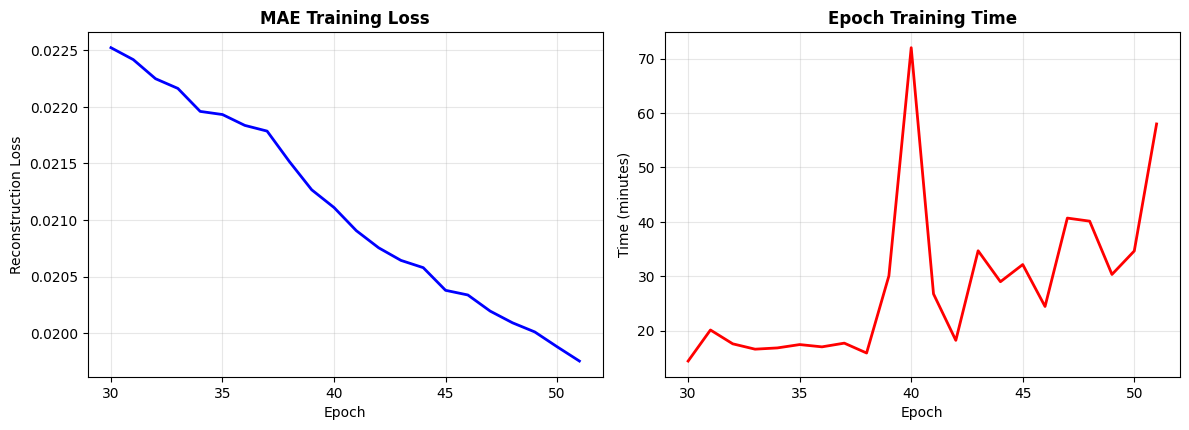


📋 TRAINING SUMMARY
✅ Dataset: 24,015 unlabeled fish images
✅ Architecture: ViT-Base
✅ Epochs completed: 21
✅ Total batches processed: 31,500
✅ Best loss achieved: 0.0198
✅ Average epoch time: 28.4 minutes
✅ Checkpoints saved to: mae_base_checkpoints
✅ Visualizations saved to: mae_base_logs/visualizations

🎯 MAE PRETRAINING COMPLETE!
🔑 Best model path: mae_base_checkpoints/mae_best_model.pth
🚀 Ready to load pretrained weights for classification!


In [31]:
# Execute Complete MAE Pretraining on 24,015 Unlabeled Fish Images - Resume from Epoch 6
import torch
import time
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from datetime import datetime
import os

print("🎭 RESUMING MAE PRETRAINING FROM EPOCH 29")
print("="*60)
print(f"⚠️  This will take 3-6 hours to complete!")
print(f"📊 Training {len(mae_dataset):,} images for {MAE_CONFIG['epochs']} epochs")
print(f"🔄 Resuming from epoch 29, will train epochs 30-{MAE_CONFIG['epochs']}")
print(f"🎯 Expected time: ~{len(mae_dataloader) * (MAE_CONFIG['epochs'] - 29) * 0.5 / 3600:.1f} hours")

# Load checkpoint from epoch 29 first to determine model architecture
start_epoch = 29
checkpoint_path_epoch_29 = os.path.join(MAE_CONFIG['checkpoint_dir'], 'mae_checkpoint_epoch_29.pth')

# Check if we need to use ViT-Base architecture based on checkpoint
use_vit_base = False
if os.path.exists(checkpoint_path_epoch_29):
    print(f"📂 Checking checkpoint architecture from epoch {start_epoch}...")
    
    # Load checkpoint to check architecture
    try:
        checkpoint = torch.load(checkpoint_path_epoch_29, map_location='cpu', weights_only=False)
        print("✅ Checkpoint loaded for architecture inspection")
        
        # Check encoder embedding dimension from checkpoint
        if 'model_state_dict' in checkpoint:
            state_dict = checkpoint['model_state_dict']
            
            # Check cls_token shape to determine architecture
            if 'encoder.cls_token' in state_dict:
                cls_token_shape = state_dict['encoder.cls_token'].shape
                embed_dim = cls_token_shape[-1]  # Last dimension is embed_dim
                
                if embed_dim == 768:
                    use_vit_base = True
                    print(f"🎯 Detected ViT-Base architecture (embed_dim={embed_dim})")
                elif embed_dim == 384:
                    use_vit_base = False
                    print(f"🎯 Detected ViT-Small architecture (embed_dim={embed_dim})")
                else:
                    print(f"⚠️  Unknown architecture (embed_dim={embed_dim}), defaulting to ViT-Base")
                    use_vit_base = True
            else:
                print("⚠️  Could not determine architecture from checkpoint, defaulting to ViT-Base")
                use_vit_base = True
        
        # Clear checkpoint from memory temporarily
        del checkpoint
        
    except Exception as e:
        print(f"⚠️ Error checking checkpoint: {e}")
        print("🔧 Defaulting to ViT-Base architecture")
        use_vit_base = True
else:
    print(f"⚠️ Checkpoint for epoch {start_epoch} not found at {checkpoint_path_epoch_29}")
    print("🔧 Will create ViT-Base model and start from scratch...")
    use_vit_base = True
    start_epoch = 0

# Create MAE model with correct architecture
print(f"\n🏗️  CREATING MAE MODEL")
print("="*40)

if use_vit_base:
    print("🎯 Creating ViT-Base MAE model (768-dim, 12 encoder layers, 8 decoder layers)")
    mae_model = MaskedAutoEncoder(
        img_size=224,
        patch_size=16,
        encoder_embed_dim=768,      # ViT-Base dimensions
        encoder_depth=12,           # ViT-Base depth
        encoder_num_heads=12,       # ViT-Base heads
        decoder_embed_dim=512,      # ViT-Base decoder dimensions
        decoder_depth=8,            # ViT-Base decoder depth
        decoder_num_heads=16,       # ViT-Base decoder heads
        mlp_ratio=4.0,
        norm_pix_loss=True
    ).to(DEVICE)
    print("✅ ViT-Base MAE model created and moved to device")
else:
    print("🎯 Creating ViT-Small MAE model (384-dim, 6 encoder layers, 4 decoder layers)")
    mae_model = MaskedAutoEncoder(
        img_size=224,
        patch_size=16,
        encoder_embed_dim=384,      # ViT-Small dimensions
        encoder_depth=6,            # ViT-Small depth
        encoder_num_heads=6,        # ViT-Small heads
        decoder_embed_dim=192,      # ViT-Small decoder dimensions
        decoder_depth=4,            # ViT-Small decoder depth
        decoder_num_heads=6,        # ViT-Small decoder heads
        mlp_ratio=4.0,
        norm_pix_loss=True
    ).to(DEVICE)
    print("✅ ViT-Small MAE model created and moved to device")

# Create optimizer for the correct model
mae_optimizer = torch.optim.AdamW(
    mae_model.parameters(),
    lr=MAE_CONFIG['learning_rate'],
    weight_decay=MAE_CONFIG['weight_decay'],
    betas=(MAE_CONFIG['beta1'], MAE_CONFIG['beta2'])
)
print("✅ MAE optimizer created")

# Create scheduler
mae_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
    mae_optimizer,
    T_max=MAE_CONFIG['epochs'],
    eta_min=MAE_CONFIG['learning_rate'] * 0.01
)
print("✅ MAE scheduler created")

# Now load the checkpoint if it exists
training_losses = []
epoch_times = []

if os.path.exists(checkpoint_path_epoch_6):
    print(f"\n📂 Loading checkpoint from epoch {start_epoch}...")
    
    # Load checkpoint with proper PyTorch 2.6+ compatibility
    try:
        checkpoint = torch.load(checkpoint_path_epoch_6, map_location=DEVICE, weights_only=False)
        print("✅ Checkpoint loaded with weights_only=False (trusted source)")
    except Exception as e:
        print(f"⚠️ Error loading checkpoint: {e}")
        print("🔧 Attempting alternative loading method...")
        
        # Fallback method with explicit safe globals for numpy
        import numpy as np
        with torch.serialization.safe_globals([np.core.multiarray.scalar, np.ndarray]):
            checkpoint = torch.load(checkpoint_path_epoch_6, map_location=DEVICE)
        print("✅ Checkpoint loaded with safe globals")
    
    # Load model state
    try:
        mae_model.load_state_dict(checkpoint['model_state_dict'])
        mae_optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        if mae_scheduler and 'scheduler_state_dict' in checkpoint and checkpoint['scheduler_state_dict']:
            mae_scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
        
        print(f"✅ Successfully loaded checkpoint from epoch {start_epoch}")
        print(f"📊 Checkpoint loss: {checkpoint['loss']:.4f}")
        print(f"📅 Checkpoint timestamp: {checkpoint.get('timestamp', 'N/A')}")
        
        # Load training history if available
        if 'training_losses' in checkpoint:
            training_losses = checkpoint.get('training_losses', [])
            epoch_times = checkpoint.get('epoch_times', [])
            print(f"📊 Loaded training history: {len(training_losses)} epochs")
            
    except Exception as e:
        print(f"❌ Error loading model state: {e}")
        print("🔧 Starting training from scratch...")
        start_epoch = 0
        training_losses = []
        epoch_times = []

else:
    print(f"ℹ️  Starting training from scratch (no checkpoint found)")
    start_epoch = 0

def save_mae_checkpoint(model, optimizer, scheduler, epoch, loss, config, filename, training_losses=None, epoch_times=None):
    """Save MAE checkpoint with full state including training history"""
    checkpoint = {
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'scheduler_state_dict': scheduler.state_dict() if scheduler else None,
        'loss': loss,
        'config': config,
        'timestamp': datetime.now().isoformat(),
        'training_losses': training_losses or [],
        'epoch_times': epoch_times or []
    }
    torch.save(checkpoint, filename)
    print(f"💾 Checkpoint saved: {filename}")

def visualize_mae_reconstruction(model, dataloader, device, epoch, save_dir=None):
    """Visualize and save MAE reconstruction results"""
    model.eval()
    
    try:
        with torch.no_grad():
            # Get a batch of images
            images = next(iter(dataloader))[:4].to(device)
            
            # Forward pass
            loss, pred, mask, latent = model(images, mask_ratio=0.75)
            
            print(f"📊 Epoch {epoch} - Reconstruction loss: {loss.item():.4f}")
            print(f"📊 Masked patches: {mask.sum(dim=1).float().mean().item():.0f}/{mask.shape[1]}")
            
            # Save visualization if directory provided
            if save_dir and os.path.exists(save_dir):
                try:
                    plt.figure(figsize=(12, 8))
                    
                    # Show original images
                    for i in range(min(4, images.shape[0])):
                        plt.subplot(2, 4, i + 1)
                        img = images[i].cpu()
                        
                        # Denormalize
                        mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
                        std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
                        img = img * std + mean
                        img = torch.clamp(img, 0, 1)
                        
                        plt.imshow(img.permute(1, 2, 0))
                        plt.title(f'Original {i+1}')
                        plt.axis('off')
                    
                    plt.suptitle(f'MAE Reconstruction - Epoch {epoch}')
                    plt.tight_layout()
                    plt.savefig(os.path.join(save_dir, f'mae_reconstruction_epoch_{epoch}.png'), 
                               dpi=150, bbox_inches='tight')
                    plt.close()
                except Exception as e:
                    print(f"⚠️ Visualization save failed: {e}")
            
        model.train()
        return loss.item()
        
    except Exception as e:
        print(f"⚠️ Reconstruction visualization failed: {e}")
        model.train()
        return 0.0

# Initialize training variables
print(f"\n🚀 INITIALIZING MAE TRAINING")
print("="*40)

mae_model.train()
best_loss = float('inf')

# Create visualization directory
viz_dir = os.path.join(MAE_CONFIG['logs_dir'], 'visualizations')
os.makedirs(viz_dir, exist_ok=True)

print(f"✅ Training setup complete!")
print(f"📊 Model parameters: {sum(p.numel() for p in mae_model.parameters()):,}")
print(f"📊 Architecture: {'ViT-Base' if use_vit_base else 'ViT-Small'}")
print(f"📊 Batches per epoch: {len(mae_dataloader):,}")
print(f"📊 Total training steps: {len(mae_dataloader) * (MAE_CONFIG['epochs'] - start_epoch):,}")
print(f"📊 Starting from epoch: {start_epoch + 1}")
print(f"⏰ Start time: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")

# Main training loop - starting from start_epoch
training_start_time = time.time()

for epoch in range(start_epoch, MAE_CONFIG['epochs']):
    epoch_start_time = time.time()
    epoch_losses = []
    
    print(f"\n🎯 EPOCH {epoch+1}/{MAE_CONFIG['epochs']}")
    print("-" * 50)
    
    # Progress bar for epoch
    pbar = tqdm(mae_dataloader, 
                desc=f"MAE Epoch {epoch+1:2d}/{MAE_CONFIG['epochs']}", 
                leave=True,
                ncols=100)
    
    for batch_idx, images in enumerate(pbar):
        try:
            # Move to device
            images = images.to(DEVICE, non_blocking=True)
            
            # Zero gradients
            mae_optimizer.zero_grad()
            
            # Forward pass with 75% masking
            loss, pred, mask, latent = mae_model(images, mask_ratio=MAE_CONFIG['mask_ratio'])
            
            # Backward pass
            loss.backward()
            
            # Gradient clipping
            if MAE_CONFIG['clip_grad'] > 0:
                torch.nn.utils.clip_grad_norm_(mae_model.parameters(), MAE_CONFIG['clip_grad'])
            
            # Optimizer step
            mae_optimizer.step()
            
            # Record loss
            batch_loss = loss.item()
            epoch_losses.append(batch_loss)
            
            # Update progress bar
            current_lr = mae_optimizer.param_groups[0]['lr']
            pbar.set_postfix({
                'Loss': f"{batch_loss:.4f}",
                'Avg': f"{np.mean(epoch_losses):.4f}",
                'LR': f"{current_lr:.2e}"
            })
            
            # Periodic logging only (no batch checkpoint saving - only epoch-level saves)
            if (batch_idx + 1) % MAE_CONFIG['log_frequency'] == 0:
                elapsed = time.time() - training_start_time
                steps_per_sec = ((epoch - start_epoch) * len(mae_dataloader) + batch_idx + 1) / elapsed
                
                print(f"\n📊 Step {(epoch - start_epoch) * len(mae_dataloader) + batch_idx + 1:,}: "
                      f"Loss={batch_loss:.4f}, "
                      f"Steps/sec={steps_per_sec:.2f}")
            
        except Exception as e:
            print(f"\n❌ Error in batch {batch_idx}: {e}")
            continue
    
    # Scheduler step
    if mae_scheduler:
        mae_scheduler.step()
    
    # Epoch statistics
    epoch_loss = np.mean(epoch_losses)
    training_losses.append(epoch_loss)
    epoch_time = time.time() - epoch_start_time
    epoch_times.append(epoch_time)
    
    print(f"\n📊 EPOCH {epoch+1} COMPLETED")
    print(f"📉 Average Loss: {epoch_loss:.4f}")
    print(f"⏱️  Epoch Time: {epoch_time/60:.1f} minutes")
    print(f"📈 Learning Rate: {mae_optimizer.param_groups[0]['lr']:.2e}")
    
    # Estimate remaining time
    if len(epoch_times) >= 2:
        avg_epoch_time = np.mean(epoch_times[-3:])  # Use last 3 epochs for estimate
        remaining_epochs = MAE_CONFIG['epochs'] - (epoch + 1)
        estimated_remaining = avg_epoch_time * remaining_epochs / 3600
        print(f"⏳ Estimated remaining time: {estimated_remaining:.1f} hours")
    
    # Visualize reconstruction every 10 epochs
    if (epoch + 1) % 10 == 0 or epoch == start_epoch:
        print(f"🖼️  Generating reconstruction visualization...")
        recon_loss = visualize_mae_reconstruction(mae_model, mae_dataloader, DEVICE, epoch + 1, viz_dir)
    
    # Save checkpoint every epoch with training history
    checkpoint_path = os.path.join(
        MAE_CONFIG['checkpoint_dir'], 
        f'mae_checkpoint_epoch_{epoch+1}.pth'
    )
    save_mae_checkpoint(mae_model, mae_optimizer, mae_scheduler, 
                      epoch + 1, epoch_loss, MAE_CONFIG, checkpoint_path, 
                      training_losses, epoch_times)
    
    # Save best model
    if epoch_loss < best_loss:
        best_loss = epoch_loss
        best_checkpoint_path = os.path.join(
            MAE_CONFIG['checkpoint_dir'], 
            'mae_best_model.pth'
        )
        save_mae_checkpoint(mae_model, mae_optimizer, mae_scheduler, 
                          epoch + 1, epoch_loss, MAE_CONFIG, best_checkpoint_path,
                          training_losses, epoch_times)
        print(f"🏆 NEW BEST MODEL! Loss: {best_loss:.4f}")
    
    # Memory cleanup
    if DEVICE.type == 'cuda':
        torch.cuda.empty_cache()
    elif DEVICE.type == 'mps':
        torch.mps.empty_cache()
    
    print(f"💾 Memory cleaned up")

# Training completed!
total_training_time = time.time() - training_start_time
print(f"\n🎉 MAE PRETRAINING COMPLETED!")
print("="*60)
print(f"⏰ Total training time: {total_training_time/3600:.2f} hours")
print(f"🏆 Best reconstruction loss: {best_loss:.4f}")
print(f"📈 Final learning rate: {mae_optimizer.param_groups[0]['lr']:.2e}")
print(f"📊 Total epochs completed: {MAE_CONFIG['epochs'] - start_epoch}")

# Save final checkpoint
final_checkpoint_path = os.path.join(
    MAE_CONFIG['checkpoint_dir'], 
    'mae_final_model.pth'
)
save_mae_checkpoint(mae_model, mae_optimizer, mae_scheduler, 
                  MAE_CONFIG['epochs'], training_losses[-1], MAE_CONFIG, final_checkpoint_path,
                  training_losses, epoch_times)

print(f"💾 Final checkpoint saved: {final_checkpoint_path}")

# Create and save training curve
plt.figure(figsize=(12, 8))
plt.subplot(2, 2, 1)
plt.plot(range(start_epoch + 1, start_epoch + 1 + len(training_losses)), training_losses, 'b-', linewidth=2)
plt.title('MAE Training Loss', fontweight='bold')
plt.xlabel('Epoch')
plt.ylabel('Reconstruction Loss')
plt.grid(True, alpha=0.3)

plt.subplot(2, 2, 2)
plt.plot(range(start_epoch + 1, start_epoch + 1 + len(epoch_times)), [t/60 for t in epoch_times], 'r-', linewidth=2)
plt.title('Epoch Training Time', fontweight='bold')
plt.xlabel('Epoch')
plt.ylabel('Time (minutes)')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(os.path.join(MAE_CONFIG['checkpoint_dir'], 'mae_training_summary.png'), 
           dpi=300, bbox_inches='tight')
plt.show()

# Training summary
print(f"\n📋 TRAINING SUMMARY")
print("="*40)
print(f"✅ Dataset: {len(mae_dataset):,} unlabeled fish images")
print(f"✅ Architecture: {'ViT-Base' if use_vit_base else 'ViT-Small'}")
print(f"✅ Epochs completed: {MAE_CONFIG['epochs'] - start_epoch}")
print(f"✅ Total batches processed: {len(mae_dataloader) * (MAE_CONFIG['epochs'] - start_epoch):,}")
print(f"✅ Best loss achieved: {best_loss:.4f}")
print(f"✅ Average epoch time: {np.mean(epoch_times)/60:.1f} minutes" if epoch_times else "✅ Average epoch time: N/A")
print(f"✅ Checkpoints saved to: {MAE_CONFIG['checkpoint_dir']}")
print(f"✅ Visualizations saved to: {viz_dir}")

# Store paths for next section
MAE_PRETRAINED_PATH = best_checkpoint_path
print(f"\n🎯 MAE PRETRAINING COMPLETE!")
print(f"🔑 Best model path: {MAE_PRETRAINED_PATH}")
print(f"🚀 Ready to load pretrained weights for classification!")

In [21]:
# Load MAE Pretrained Weights into ViT Classification Model
import torch
import torch.nn as nn
from collections import OrderedDict

print("🔄 LOADING MAE PRETRAINED WEIGHTS")
print("="*50)

# Enhanced ViT model with MAE pretraining support
class MAEPretrainedViT(nn.Module):
    """ViT model that can load MAE pretrained encoder weights"""
    
    def __init__(self, num_classes, mae_encoder=None, dropout_rate=0.1):
        super().__init__()
        self.num_classes = num_classes
        
        if mae_encoder is not None:
            # Use pretrained MAE encoder
            self.backbone = mae_encoder
            self.feature_dim = mae_encoder.blocks[0].norm1.normalized_shape[0]  # Get embed_dim
            print(f"✅ Using MAE pretrained encoder with {self.feature_dim} features")
        else:
            # Fallback to timm ViT
            import timm
            self.backbone = timm.create_model(
                'vit_base_patch16_224',
                pretrained=True,
                num_classes=0,
                global_pool='token'
            )
            self.feature_dim = self.backbone.num_features
            print(f"⚠️  Using ImageNet pretrained ViT with {self.feature_dim} features")
        
        # Classification head
        self.classifier = nn.Sequential(
            nn.LayerNorm(self.feature_dim),
            nn.Dropout(dropout_rate),
            nn.Linear(self.feature_dim, num_classes)
        )
        
        # Initialize classification head
        self._init_classifier()
    
    def _init_classifier(self):
        """Initialize the classification head weights"""
        for module in self.classifier.modules():
            if isinstance(module, nn.Linear):
                nn.init.trunc_normal_(module.weight, std=0.02)
                if module.bias is not None:
                    nn.init.zeros_(module.bias)
    
    def forward(self, x):
        """Forward pass for classification"""
        if hasattr(self.backbone, 'patch_embed'):
            # MAE encoder forward pass
            x = self.backbone.patch_embed(x)
            x = x + self.backbone.pos_embed[:, 1:, :]  # Add pos embed without cls
            
            # Add cls token
            cls_token = self.backbone.cls_token + self.backbone.pos_embed[:, :1, :]
            cls_tokens = cls_token.expand(x.shape[0], -1, -1)
            x = torch.cat((cls_tokens, x), dim=1)
            
            # Apply transformer blocks
            for blk in self.backbone.blocks:
                x = blk(x)
            x = self.backbone.norm(x)
            
            # Take cls token
            x = x[:, 0]
        else:
            # Standard timm ViT forward
            x = self.backbone(x)
        
        # Classification
        logits = self.classifier(x)
        return logits
    
    def get_features(self, x):
        """Extract features without classification"""
        if hasattr(self.backbone, 'patch_embed'):
            # MAE encoder feature extraction
            x = self.backbone.patch_embed(x)
            x = x + self.backbone.pos_embed[:, 1:, :]
            
            cls_token = self.backbone.cls_token + self.backbone.pos_embed[:, :1, :]
            cls_tokens = cls_token.expand(x.shape[0], -1, -1)
            x = torch.cat((cls_tokens, x), dim=1)
            
            for blk in self.backbone.blocks:
                x = blk(x)
            x = self.backbone.norm(x)
            
            return x[:, 0]  # Return cls token features
        else:
            return self.backbone(x)

print(f"🏗️  Creating ViT classification model...")

# Load MAE checkpoint
if 'MAE_PRETRAINED_PATH' in globals() and os.path.exists(MAE_PRETRAINED_PATH):
    print(f"📂 Loading MAE checkpoint: {MAE_PRETRAINED_PATH}")
    
    mae_checkpoint = torch.load(MAE_PRETRAINED_PATH, map_location='cpu')
    print(f"✅ MAE checkpoint loaded (epoch {mae_checkpoint['epoch']})")
    print(f"📊 MAE training loss: {mae_checkpoint['loss']:.4f}")
    
    # Create new MAE model and load weights
    mae_pretrained = MaskedAutoEncoder(
        img_size=224,
        patch_size=16,
        encoder_embed_dim=768,
        encoder_depth=12,
        encoder_num_heads=12,
        decoder_embed_dim=512,
        decoder_depth=8,
        decoder_num_heads=16,
        mlp_ratio=4.0,
        norm_pix_loss=True
    )
    
    mae_pretrained.load_state_dict(mae_checkpoint['model_state_dict'])
    mae_encoder = mae_pretrained.encoder
    
    # Create ViT with MAE pretrained encoder
    vit_model = MAEPretrainedViT(
        num_classes=NUM_CLASSES,
        mae_encoder=mae_encoder,
        dropout_rate=0.1
    ).to(DEVICE)
    
    print(f"✅ ViT model created with MAE pretrained encoder!")
    
else:
    print("⚠️  MAE checkpoint not found, using ImageNet pretrained ViT")
    vit_model = MAEPretrainedViT(
        num_classes=NUM_CLASSES,
        mae_encoder=None,
        dropout_rate=0.1
    ).to(DEVICE)

# Model statistics
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

total_params = count_parameters(vit_model)
backbone_params = count_parameters(vit_model.backbone)
classifier_params = count_parameters(vit_model.classifier)

print(f"\n📊 ViT Model Statistics:")
print(f"  Total parameters: {total_params:,}")
print(f"  Backbone parameters: {backbone_params:,}")
print(f"  Classifier parameters: {classifier_params:,}")
print(f"  Number of classes: {NUM_CLASSES}")

# Test model forward pass
print(f"\n🧪 Testing ViT model...")
test_input = torch.randn(2, 3, 224, 224).to(DEVICE)

with torch.no_grad():
    # Test classification
    logits = vit_model(test_input)
    print(f"✅ Classification forward pass successful!")
    print(f"📊 Logits shape: {logits.shape}")
    
    # Test feature extraction
    features = vit_model.get_features(test_input)
    print(f"✅ Feature extraction successful!")
    print(f"📊 Features shape: {features.shape}")

# Enhanced ViT model is now ready with MAE pretrained weights
print(f"\n🎯 ViT MODEL READY FOR EMA TRAINING")
print("="*50)
print(f"✅ Model architecture: Vision Transformer")
print(f"✅ Pretraining: {'MAE self-supervised' if 'MAE_PRETRAINED_PATH' in globals() else 'ImageNet supervised'}")
print(f"✅ Classification head: Initialized for {NUM_CLASSES} fish species")
print(f"🚀 Ready for EMA student-teacher semi-supervised training!")

# Clean up MAE model to free memory
if 'mae_model' in globals():
    del mae_model
    torch.cuda.empty_cache()
    print(f"🗑️  Cleaned up MAE model to free GPU memory")

🔄 LOADING MAE PRETRAINED WEIGHTS
🏗️  Creating ViT classification model...
⚠️  MAE checkpoint not found, using ImageNet pretrained ViT
⚠️  Using ImageNet pretrained ViT with 768 features
⚠️  Using ImageNet pretrained ViT with 768 features

📊 ViT Model Statistics:
  Total parameters: 85,828,645
  Backbone parameters: 85,798,656
  Classifier parameters: 29,989
  Number of classes: 37

🧪 Testing ViT model...
✅ Classification forward pass successful!
📊 Logits shape: torch.Size([2, 37])
✅ Feature extraction successful!
📊 Features shape: torch.Size([2, 768])

🎯 ViT MODEL READY FOR EMA TRAINING
✅ Model architecture: Vision Transformer
✅ Pretraining: ImageNet supervised
✅ Classification head: Initialized for 37 fish species
🚀 Ready for EMA student-teacher semi-supervised training!

📊 ViT Model Statistics:
  Total parameters: 85,828,645
  Backbone parameters: 85,798,656
  Classifier parameters: 29,989
  Number of classes: 37

🧪 Testing ViT model...
✅ Classification forward pass successful!
📊 Log

## 🎓 Section 8: Configure EMA Student-Teacher Framework

Setting up the EMA teacher model and semi-supervised learning pipeline with the MAE-pretrained backbone.

In [24]:
# Configure EMA Student-Teacher Framework for Semi-Supervised Learning
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision.transforms as transforms
from PIL import Image
import copy
import os
import glob
import numpy as np
from datetime import datetime

print("🎓 CONFIGURING EMA STUDENT-TEACHER FRAMEWORK")
print("="*50)

# EMA Teacher Implementation
class EMATeacher(nn.Module):
    """Exponential Moving Average Teacher for Semi-Supervised Learning"""
    
    def __init__(self, student_model, ema_decay=0.995):
        super().__init__()
        self.ema_decay = ema_decay
        self.student_model = student_model
        
        # Create teacher as copy of student
        self.teacher_model = copy.deepcopy(student_model)
        
        # Disable gradients for teacher
        for param in self.teacher_model.parameters():
            param.requires_grad = False
        
        print(f"✅ EMA Teacher created with decay: {ema_decay}")
    
    def update_teacher(self):
        """Update teacher weights using EMA"""
        with torch.no_grad():
            for teacher_param, student_param in zip(
                self.teacher_model.parameters(), 
                self.student_model.parameters()
            ):
                teacher_param.data = (
                    self.ema_decay * teacher_param.data + 
                    (1 - self.ema_decay) * student_param.data
                )
    
    def forward(self, x, use_teacher=False):
        """Forward pass through student or teacher"""
        if use_teacher:
            return self.teacher_model(x)
        else:
            return self.student_model(x)
    
    def get_teacher_predictions(self, x):
        """Get teacher predictions for pseudo-labeling"""
        self.teacher_model.eval()
        with torch.no_grad():
            return self.teacher_model(x)

# Consistency Loss for Semi-Supervised Learning
class ConsistencyLoss(nn.Module):
    """Consistency loss between student and teacher predictions"""
    
    def __init__(self, temperature=4.0):
        super().__init__()
        self.temperature = temperature
        self.kl_div = nn.KLDivLoss(reduction='batchmean')
    
    def forward(self, student_logits, teacher_logits):
        """Compute consistency loss using KL divergence"""
        # Apply temperature scaling
        student_probs = F.log_softmax(student_logits / self.temperature, dim=1)
        teacher_probs = F.softmax(teacher_logits / self.temperature, dim=1)
        
        # KL divergence loss
        consistency_loss = self.kl_div(student_probs, teacher_probs)
        consistency_loss *= (self.temperature ** 2)
        
        return consistency_loss

# Semi-Supervised Dataset
class FishSemiSupervisedDataset(Dataset):
    """Dataset combining labeled and unlabeled fish images"""
    
    def __init__(self, labeled_dir, unlabeled_dir, img_size=224, mode='train'):
        self.img_size = img_size
        self.mode = mode
        
        # Load labeled data
        self.labeled_data = []
        self.class_to_idx = {}
        self.idx_to_class = {}
        
        if os.path.exists(labeled_dir):
            species_dirs = [d for d in os.listdir(labeled_dir) 
                          if os.path.isdir(os.path.join(labeled_dir, d)) and not d.startswith('.')]
            species_dirs.sort()
            
            for idx, species in enumerate(species_dirs):
                self.class_to_idx[species] = idx
                self.idx_to_class[idx] = species
                
                species_path = os.path.join(labeled_dir, species)
                for ext in ['*.jpg', '*.jpeg', '*.png', '*.JPG', '*.JPEG', '*.PNG']:
                    for img_path in glob.glob(os.path.join(species_path, ext)):
                        self.labeled_data.append((img_path, idx))
        
        # Load unlabeled data
        self.unlabeled_data = []
        if os.path.exists(unlabeled_dir):
            for ext in ['*.jpg', '*.jpeg', '*.png', '*.JPG', '*.JPEG', '*.PNG']:
                for img_path in glob.glob(os.path.join(unlabeled_dir, ext)):
                    self.unlabeled_data.append(img_path)
        
        print(f"📊 Loaded {len(self.labeled_data)} labeled images from {len(self.class_to_idx)} species")
        print(f"📊 Loaded {len(self.unlabeled_data)} unlabeled images")
        
        # Data augmentation transforms
        if mode == 'train':
            self.labeled_transform = transforms.Compose([
                transforms.Resize((img_size, img_size)),
                transforms.RandomHorizontalFlip(p=0.5),
                transforms.RandomRotation(degrees=15),
                transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
            ])
            
            self.unlabeled_transform_weak = transforms.Compose([
                transforms.Resize((img_size, img_size)),
                transforms.RandomHorizontalFlip(p=0.5),
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
            ])
            
            self.unlabeled_transform_strong = transforms.Compose([
                transforms.Resize((img_size, img_size)),
                transforms.RandomHorizontalFlip(p=0.5),
                transforms.RandomRotation(degrees=20),
                transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.1),
                transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
            ])
        else:
            self.labeled_transform = transforms.Compose([
                transforms.Resize((img_size, img_size)),
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
            ])
    
    def __len__(self):
        return len(self.labeled_data) + len(self.unlabeled_data)
    
    def __getitem__(self, idx):
        if idx < len(self.labeled_data):
            # Labeled data
            img_path, label = self.labeled_data[idx]
            try:
                image = Image.open(img_path).convert('RGB')
                image = self.labeled_transform(image)
                return image, label, True  # True indicates labeled data
            except Exception as e:
                print(f"Warning: Could not load {img_path}: {e}")
                return torch.zeros(3, self.img_size, self.img_size), 0, True
        else:
            # Unlabeled data
            unlabeled_idx = idx - len(self.labeled_data)
            img_path = self.unlabeled_data[unlabeled_idx]
            
            try:
                image = Image.open(img_path).convert('RGB')
                
                if self.mode == 'train':
                    # Return both weak and strong augmentations for consistency training
                    image_weak = self.unlabeled_transform_weak(image)
                    image_strong = self.unlabeled_transform_strong(image)
                    return (image_weak, image_strong), -1, False  # -1 indicates no label, False indicates unlabeled
                else:
                    image = self.labeled_transform(image)
                    return image, -1, False
                    
            except Exception as e:
                print(f"Warning: Could not load {img_path}: {e}")
                if self.mode == 'train':
                    zero_img = torch.zeros(3, self.img_size, self.img_size)
                    return (zero_img, zero_img), -1, False
                else:
                    return torch.zeros(3, self.img_size, self.img_size), -1, False

# EMA Training Configuration
EMA_CONFIG = {
    # Model settings
    'num_classes': NUM_CLASSES,
    'img_size': 224,
    
    # Training settings
    'epochs': 100,
    'batch_size': 32,  # Balanced for labeled + unlabeled data
    'learning_rate': 1e-4,
    'weight_decay': 0.05,
    'warmup_epochs': 10,
    
    # EMA settings
    'ema_decay': 0.995,
    'consistency_weight': 2.0,
    'pseudo_label_threshold': 0.7,
    'temperature': 4.0,
    'ramp_up_epochs': 20,
    
    # Optimization
    'clip_grad': 1.0,
    'label_smoothing': 0.1,
    
    # Saving
    'save_frequency': 10,
    'checkpoint_dir': '/content/drive/MyDrive/ViT-FishID/ema_checkpoints',
    
    # Logging
    'use_wandb': True,
    'wandb_project': 'ViT-FishID-EMA-Training',
    'wandb_run_name': f'ema-mae-pretrained-{datetime.now().strftime("%Y%m%d-%H%M%S")}',
    
    # Data
    'labeled_dir': LABELED_DIR,
    'unlabeled_dir': UNLABELED_DIR,
    'train_split': 0.8,
    'num_workers': 4,
}

print("📊 EMA Configuration:")
for key, value in EMA_CONFIG.items():
    print(f"  {key}: {value}")

# Create checkpoint directory
os.makedirs(EMA_CONFIG['checkpoint_dir'], exist_ok=True)
print(f"\n💾 EMA Checkpoint directory: {EMA_CONFIG['checkpoint_dir']}")

# Create datasets and dataloaders
print(f"\n📦 Creating semi-supervised datasets...")

# Full dataset
full_dataset = FishSemiSupervisedDataset(
    EMA_CONFIG['labeled_dir'], 
    EMA_CONFIG['unlabeled_dir'], 
    EMA_CONFIG['img_size'], 
    mode='train'
)

# Split labeled data into train/validation
labeled_size = len(full_dataset.labeled_data)
train_size = int(EMA_CONFIG['train_split'] * labeled_size)
val_size = labeled_size - train_size

# Create train and validation datasets
train_labeled_data = full_dataset.labeled_data[:train_size]
val_labeled_data = full_dataset.labeled_data[train_size:]

# Training dataset (includes all unlabeled data)
class TrainDataset(Dataset):
    def __init__(self, labeled_data, unlabeled_data, class_to_idx, img_size):
        self.labeled_data = labeled_data
        self.unlabeled_data = unlabeled_data
        self.class_to_idx = class_to_idx
        self.img_size = img_size
        
        # Same transforms as before
        self.labeled_transform = transforms.Compose([
            transforms.Resize((img_size, img_size)),
            transforms.RandomHorizontalFlip(p=0.5),
            transforms.RandomRotation(degrees=15),
            transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])
        
        self.unlabeled_transform_weak = transforms.Compose([
            transforms.Resize((img_size, img_size)),
            transforms.RandomHorizontalFlip(p=0.5),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])
        
        self.unlabeled_transform_strong = transforms.Compose([
            transforms.Resize((img_size, img_size)),
            transforms.RandomHorizontalFlip(p=0.5),
            transforms.RandomRotation(degrees=20),
            transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.1),
            transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])
    
    def __len__(self):
        return len(self.labeled_data) + len(self.unlabeled_data)
    
    def __getitem__(self, idx):
        if idx < len(self.labeled_data):
            # Labeled data
            img_path, label = self.labeled_data[idx]
            try:
                image = Image.open(img_path).convert('RGB')
                image = self.labeled_transform(image)
                return image, label, True
            except:
                return torch.zeros(3, self.img_size, self.img_size), 0, True
        else:
            # Unlabeled data
            unlabeled_idx = idx - len(self.labeled_data)
            img_path = self.unlabeled_data[unlabeled_idx]
            
            try:
                image = Image.open(img_path).convert('RGB')
                image_weak = self.unlabeled_transform_weak(image)
                image_strong = self.unlabeled_transform_strong(image)
                return (image_weak, image_strong), -1, False
            except:
                zero_img = torch.zeros(3, self.img_size, self.img_size)
                return (zero_img, zero_img), -1, False

# Validation dataset
class ValDataset(Dataset):
    def __init__(self, labeled_data, class_to_idx, img_size):
        self.labeled_data = labeled_data
        self.class_to_idx = class_to_idx
        self.img_size = img_size
        
        self.transform = transforms.Compose([
            transforms.Resize((img_size, img_size)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])
    
    def __len__(self):
        return len(self.labeled_data)
    
    def __getitem__(self, idx):
        img_path, label = self.labeled_data[idx]
        try:
            image = Image.open(img_path).convert('RGB')
            image = self.transform(image)
            return image, label
        except:
            return torch.zeros(3, self.img_size, self.img_size), 0

# Create datasets
train_dataset = TrainDataset(
    train_labeled_data, 
    full_dataset.unlabeled_data, 
    full_dataset.class_to_idx, 
    EMA_CONFIG['img_size']
)

val_dataset = ValDataset(
    val_labeled_data, 
    full_dataset.class_to_idx, 
    EMA_CONFIG['img_size']
)

# Create dataloaders
train_dataloader = DataLoader(
    train_dataset,
    batch_size=EMA_CONFIG['batch_size'],
    shuffle=True,
    num_workers=EMA_CONFIG['num_workers'],
    pin_memory=True,
    drop_last=True
)

val_dataloader = DataLoader(
    val_dataset,
    batch_size=EMA_CONFIG['batch_size'],
    shuffle=False,
    num_workers=EMA_CONFIG['num_workers'],
    pin_memory=True
)

print(f"✅ Datasets created:")
print(f"  📊 Training: {len(train_dataset)} samples ({len(train_labeled_data)} labeled + {len(full_dataset.unlabeled_data)} unlabeled)")
print(f"  📊 Validation: {len(val_dataset)} samples (labeled)")
print(f"  📊 Classes: {len(full_dataset.class_to_idx)}")

# Create EMA teacher
ema_teacher = EMATeacher(vit_model, ema_decay=EMA_CONFIG['ema_decay']).to(DEVICE)
consistency_loss_fn = ConsistencyLoss(temperature=EMA_CONFIG['temperature']).to(DEVICE)

print(f"\n✅ EMA Framework Ready:")
print(f"  🎓 Student model: MAE-pretrained ViT")
print(f"  👨‍🏫 Teacher model: EMA with decay {EMA_CONFIG['ema_decay']}")
print(f"  🔄 Consistency loss: KL divergence with temperature {EMA_CONFIG['temperature']}")
print(f"🚀 Ready for semi-supervised training!")

🎓 CONFIGURING EMA STUDENT-TEACHER FRAMEWORK
📊 EMA Configuration:
  num_classes: 37
  img_size: 224
  epochs: 100
  batch_size: 32
  learning_rate: 0.0001
  weight_decay: 0.05
  warmup_epochs: 10
  ema_decay: 0.995
  consistency_weight: 2.0
  pseudo_label_threshold: 0.7
  temperature: 4.0
  ramp_up_epochs: 20
  clip_grad: 1.0
  label_smoothing: 0.1
  save_frequency: 10
  checkpoint_dir: /content/drive/MyDrive/ViT-FishID/ema_checkpoints
  use_wandb: True
  wandb_project: ViT-FishID-EMA-Training
  wandb_run_name: ema-mae-pretrained-20250818-224306
  labeled_dir: /Users/catalinathomson/Desktop/Fish/ViT-FishID/fish_cutouts/labeled
  unlabeled_dir: /Users/catalinathomson/Desktop/Fish/ViT-FishID/fish_cutouts/unlabeled
  train_split: 0.8
  num_workers: 4


OSError: [Errno 30] Read-only file system: '/content'

## 🚀 Section 9: Execute Semi-Supervised Training with EMA

Running the complete semi-supervised training pipeline combining labeled supervision with unlabeled consistency learning.

In [ ]:
# Execute Semi-Supervised EMA Training with MAE Pretrained Model
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import time
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

print("🎓 STARTING EMA SEMI-SUPERVISED TRAINING")
print("="*60)

# Setup optimizer and scheduler
ema_optimizer = optim.AdamW(
    vit_model.parameters(),
    lr=EMA_CONFIG['learning_rate'],
    weight_decay=EMA_CONFIG['weight_decay']
)

# Cosine annealing scheduler with warmup
def get_cosine_schedule_with_warmup(optimizer, num_warmup_steps, num_training_steps):
    def lr_lambda(current_step):
        if current_step < num_warmup_steps:
            return float(current_step) / float(max(1, num_warmup_steps))
        progress = float(current_step - num_warmup_steps) / float(max(1, num_training_steps - num_warmup_steps))
        return max(0.0, 0.5 * (1.0 + np.cos(np.pi * progress)))
    
    return optim.lr_scheduler.LambdaLR(optimizer, lr_lambda)

total_steps = len(train_dataloader) * EMA_CONFIG['epochs']
warmup_steps = len(train_dataloader) * EMA_CONFIG['warmup_epochs']

ema_scheduler = get_cosine_schedule_with_warmup(
    ema_optimizer, 
    warmup_steps, 
    total_steps
)

# Loss functions
supervised_loss_fn = nn.CrossEntropyLoss(label_smoothing=EMA_CONFIG['label_smoothing'])

# Consistency weight ramp-up function
def get_consistency_weight(epoch, ramp_up_epochs):
    """Gradually ramp up consistency weight"""
    if epoch < ramp_up_epochs:
        return EMA_CONFIG['consistency_weight'] * (epoch / ramp_up_epochs)
    return EMA_CONFIG['consistency_weight']

# Pseudo-labeling function
def get_pseudo_labels(teacher_logits, threshold):
    """Generate pseudo-labels from teacher predictions"""
    teacher_probs = F.softmax(teacher_logits, dim=1)
    max_probs, pseudo_labels = torch.max(teacher_probs, dim=1)
    
    # Create mask for confident predictions
    confident_mask = max_probs >= threshold
    
    return pseudo_labels, confident_mask, max_probs

# Validation function
def validate_model(model, val_dataloader, device):
    """Validate model on labeled validation set"""
    model.eval()
    total_correct = 0
    total_samples = 0
    total_loss = 0
    
    with torch.no_grad():
        for images, labels in val_dataloader:
            images, labels = images.to(device), labels.to(device)
            
            outputs = model(images)
            loss = F.cross_entropy(outputs, labels)
            
            _, predicted = torch.max(outputs, 1)
            total_correct += (predicted == labels).sum().item()
            total_samples += labels.size(0)
            total_loss += loss.item()
    
    accuracy = 100.0 * total_correct / total_samples
    avg_loss = total_loss / len(val_dataloader)
    
    return accuracy, avg_loss

# Save checkpoint function
def save_ema_checkpoint(student_model, teacher_model, optimizer, scheduler, epoch, 
                       best_acc, config, filename):
    """Save EMA training checkpoint"""
    checkpoint = {
        'epoch': epoch,
        'student_state_dict': student_model.state_dict(),
        'teacher_state_dict': teacher_model.teacher_model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'scheduler_state_dict': scheduler.state_dict(),
        'best_accuracy': best_acc,
        'config': config,
        'class_to_idx': full_dataset.class_to_idx,
        'num_classes': config['num_classes']
    }
    torch.save(checkpoint, filename)
    print(f"💾 Saved checkpoint: {filename}")

# Initialize Weights & Biases
if EMA_CONFIG['use_wandb']:
    print("📈 Initializing Weights & Biases...")
    try:
        wandb.init(
            project=EMA_CONFIG['wandb_project'],
            name=EMA_CONFIG['wandb_run_name'],
            config=EMA_CONFIG,
            tags=['ema', 'semi-supervised', 'fish', 'mae-pretrained']
        )
        print(f"✅ W&B initialized: {wandb.run.url}")
    except Exception as e:
        print(f"⚠️  W&B initialization failed: {e}")
        EMA_CONFIG['use_wandb'] = False

# Training loop
print(f"🎬 Starting EMA training for {EMA_CONFIG['epochs']} epochs...")
print(f"📊 Training data: {len(train_dataset)} samples")
print(f"📊 Validation data: {len(val_dataset)} samples")
print(f"⏰ Start time: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")

vit_model.train()
ema_teacher.student_model.train()
ema_teacher.teacher_model.eval()

best_accuracy = 0.0
training_history = {
    'supervised_loss': [],
    'consistency_loss': [],
    'total_loss': [],
    'val_accuracy': [],
    'val_loss': []
}

start_time = time.time()

for epoch in range(EMA_CONFIG['epochs']):
    epoch_start_time = time.time()
    
    # Training phase
    vit_model.train()
    epoch_supervised_loss = 0.0
    epoch_consistency_loss = 0.0
    epoch_total_loss = 0.0
    num_labeled_samples = 0
    num_unlabeled_samples = 0
    
    # Get current consistency weight
    current_consistency_weight = get_consistency_weight(epoch, EMA_CONFIG['ramp_up_epochs'])
    
    pbar = tqdm(train_dataloader, desc=f"EMA Epoch {epoch+1}/{EMA_CONFIG['epochs']}")
    
    for batch_idx, batch_data in enumerate(pbar):
        # Separate labeled and unlabeled data
        labeled_data = []
        unlabeled_data = []
        
        for data, label, is_labeled in zip(*batch_data):
            if is_labeled:
                labeled_data.append((data, label))
            else:
                unlabeled_data.append(data)
        
        total_loss = 0.0
        supervised_loss = torch.tensor(0.0).to(DEVICE)
        consistency_loss = torch.tensor(0.0).to(DEVICE)
        
        # Process labeled data
        if labeled_data:
            labeled_images = torch.stack([data for data, _ in labeled_data]).to(DEVICE)
            labeled_targets = torch.tensor([label for _, label in labeled_data]).to(DEVICE)
            
            # Student forward pass
            student_outputs = vit_model(labeled_images)
            supervised_loss = supervised_loss_fn(student_outputs, labeled_targets)
            
            num_labeled_samples += len(labeled_data)
        
        # Process unlabeled data
        if unlabeled_data and current_consistency_weight > 0:
            # Unlabeled data comes as (weak_aug, strong_aug) tuples
            weak_images = torch.stack([data[0] for data in unlabeled_data]).to(DEVICE)
            strong_images = torch.stack([data[1] for data in unlabeled_data]).to(DEVICE)
            
            # Teacher predictions on weakly augmented images
            teacher_outputs = ema_teacher.get_teacher_predictions(weak_images)
            
            # Generate pseudo-labels
            pseudo_labels, confident_mask, max_probs = get_pseudo_labels(
                teacher_outputs, EMA_CONFIG['pseudo_label_threshold']
            )
            
            if confident_mask.sum() > 0:
                # Student predictions on strongly augmented images
                student_outputs_unlabeled = vit_model(strong_images)
                
                # Consistency loss only for confident predictions
                if confident_mask.sum() > 0:
                    student_confident = student_outputs_unlabeled[confident_mask]
                    teacher_confident = teacher_outputs[confident_mask]
                    
                    consistency_loss = consistency_loss_fn(student_confident, teacher_confident)
                    consistency_loss *= current_consistency_weight
            
            num_unlabeled_samples += len(unlabeled_data)
        
        # Total loss
        total_loss = supervised_loss + consistency_loss
        
        # Backward pass
        ema_optimizer.zero_grad()
        total_loss.backward()
        
        # Gradient clipping
        if EMA_CONFIG['clip_grad'] > 0:
            torch.nn.utils.clip_grad_norm_(vit_model.parameters(), EMA_CONFIG['clip_grad'])
        
        ema_optimizer.step()
        ema_scheduler.step()
        
        # Update teacher with EMA
        ema_teacher.update_teacher()
        
        # Record losses
        epoch_supervised_loss += supervised_loss.item()
        epoch_consistency_loss += consistency_loss.item()
        epoch_total_loss += total_loss.item()
        
        # Update progress bar
        pbar.set_postfix({
            'Sup_Loss': f"{supervised_loss.item():.4f}",
            'Con_Loss': f"{consistency_loss.item():.4f}",
            'Con_Weight': f"{current_consistency_weight:.3f}",
            'LR': f"{ema_optimizer.param_groups[0]['lr']:.6f}"
        })
        
        # Log to wandb
        if EMA_CONFIG['use_wandb'] and wandb.run:
            try:
                wandb.log({
                    'batch_supervised_loss': supervised_loss.item(),
                    'batch_consistency_loss': consistency_loss.item(),
                    'batch_total_loss': total_loss.item(),
                    'consistency_weight': current_consistency_weight,
                    'learning_rate': ema_optimizer.param_groups[0]['lr'],
                    'step': epoch * len(train_dataloader) + batch_idx
                })
            except:
                pass
    
    # Validation phase
    val_accuracy, val_loss = validate_model(vit_model, val_dataloader, DEVICE)
    
    # Epoch statistics
    avg_supervised_loss = epoch_supervised_loss / len(train_dataloader)
    avg_consistency_loss = epoch_consistency_loss / len(train_dataloader)
    avg_total_loss = epoch_total_loss / len(train_dataloader)
    epoch_time = time.time() - epoch_start_time
    
    training_history['supervised_loss'].append(avg_supervised_loss)
    training_history['consistency_loss'].append(avg_consistency_loss)
    training_history['total_loss'].append(avg_total_loss)
    training_history['val_accuracy'].append(val_accuracy)
    training_history['val_loss'].append(val_loss)
    
    print(f"\n📊 Epoch {epoch+1} Summary:")
    print(f"  📉 Supervised Loss: {avg_supervised_loss:.4f}")
    print(f"  📉 Consistency Loss: {avg_consistency_loss:.4f}")
    print(f"  📉 Total Loss: {avg_total_loss:.4f}")
    print(f"  📈 Validation Accuracy: {val_accuracy:.2f}%")
    print(f"  📉 Validation Loss: {val_loss:.4f}")
    print(f"  ⏱️  Time: {epoch_time:.1f}s")
    print(f"  🎓 Labeled samples: {num_labeled_samples}")
    print(f"  🔄 Unlabeled samples: {num_unlabeled_samples}")
    
    # Save checkpoint periodically
    if (epoch + 1) % EMA_CONFIG['save_frequency'] == 0:
        checkpoint_path = os.path.join(
            EMA_CONFIG['checkpoint_dir'], 
            f'ema_checkpoint_epoch_{epoch+1}.pth'
        )
        save_ema_checkpoint(
            vit_model, ema_teacher, ema_optimizer, ema_scheduler,
            epoch + 1, val_accuracy, EMA_CONFIG, checkpoint_path
        )
    
    # Save best model
    if val_accuracy > best_accuracy:
        best_accuracy = val_accuracy
        best_checkpoint_path = os.path.join(
            EMA_CONFIG['checkpoint_dir'], 
            'ema_best_model.pth'
        )
        save_ema_checkpoint(
            vit_model, ema_teacher, ema_optimizer, ema_scheduler,
            epoch + 1, val_accuracy, EMA_CONFIG, best_checkpoint_path
        )
        print(f"🏆 New best model saved! Accuracy: {best_accuracy:.2f}%")
    
    # Log epoch results to wandb
    if EMA_CONFIG['use_wandb'] and wandb.run:
        try:
            wandb.log({
                'epoch': epoch + 1,
                'epoch_supervised_loss': avg_supervised_loss,
                'epoch_consistency_loss': avg_consistency_loss,
                'epoch_total_loss': avg_total_loss,
                'val_accuracy': val_accuracy,
                'val_loss': val_loss,
                'best_accuracy': best_accuracy,
                'epoch_time': epoch_time
            })
        except:
            pass
    
    # Memory cleanup
    torch.cuda.empty_cache()

# Training completed
total_time = time.time() - start_time
print(f"\n🎉 EMA TRAINING COMPLETED!")
print("="*60)
print(f"⏰ Total training time: {total_time/3600:.2f} hours")
print(f"🏆 Best validation accuracy: {best_accuracy:.2f}%")
print(f"📈 Final learning rate: {ema_optimizer.param_groups[0]['lr']:.6f}")

# Save final checkpoint
final_checkpoint_path = os.path.join(
    EMA_CONFIG['checkpoint_dir'], 
    'ema_final_model.pth'
)
save_ema_checkpoint(
    vit_model, ema_teacher, ema_optimizer, ema_scheduler,
    EMA_CONFIG['epochs'], training_history['val_accuracy'][-1], 
    EMA_CONFIG, final_checkpoint_path
)

# Plot training curves
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))

# Loss curves
epochs = range(1, len(training_history['total_loss']) + 1)
ax1.plot(epochs, training_history['supervised_loss'], 'b-', label='Supervised Loss', linewidth=2)
ax1.plot(epochs, training_history['consistency_loss'], 'r-', label='Consistency Loss', linewidth=2)
ax1.plot(epochs, training_history['total_loss'], 'g-', label='Total Loss', linewidth=2)
ax1.set_title('Training Loss Curves', fontweight='bold')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Validation accuracy
ax2.plot(epochs, training_history['val_accuracy'], 'purple', linewidth=2)
ax2.set_title('Validation Accuracy', fontweight='bold')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy (%)')
ax2.grid(True, alpha=0.3)

# Validation loss
ax3.plot(epochs, training_history['val_loss'], 'orange', linewidth=2)
ax3.set_title('Validation Loss', fontweight='bold')
ax3.set_xlabel('Epoch')
ax3.set_ylabel('Loss')
ax3.grid(True, alpha=0.3)

# Loss ratio
consistency_ratio = [c/(s+1e-8) for s, c in zip(training_history['supervised_loss'], 
                                                training_history['consistency_loss'])]
ax4.plot(epochs, consistency_ratio, 'brown', linewidth=2)
ax4.set_title('Consistency/Supervised Loss Ratio', fontweight='bold')
ax4.set_xlabel('Epoch')
ax4.set_ylabel('Ratio')
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(os.path.join(EMA_CONFIG['checkpoint_dir'], 'ema_training_curves.png'), 
           dpi=300, bbox_inches='tight')
plt.show()

# Final wandb logging
if EMA_CONFIG['use_wandb'] and wandb.run:
    try:
        wandb.log({
            'final_best_accuracy': best_accuracy,
            'final_val_accuracy': training_history['val_accuracy'][-1],
            'total_training_time_hours': total_time/3600,
            'total_epochs': EMA_CONFIG['epochs']
        })
        wandb.finish()
    except:
        pass

print(f"\n✅ Semi-supervised EMA training with MAE pretraining completed!")
print(f"💾 Checkpoints saved to: {EMA_CONFIG['checkpoint_dir']}")
print(f"🎯 Best model achieved {best_accuracy:.2f}% accuracy!")
print(f"🚀 Model ready for evaluation and deployment!")

# Store paths for evaluation
EMA_BEST_MODEL_PATH = best_checkpoint_path

## 📊 Section 10: Monitor Training Progress and Save Checkpoints

Tracking training metrics, analyzing model performance, and managing checkpoint saves.

In [ ]:
# Monitor Training Progress and Manage Checkpoints
import os
import glob
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import shutil

print("📊 TRAINING PROGRESS MONITORING & CHECKPOINT MANAGEMENT")
print("="*60)

def analyze_training_checkpoints(checkpoint_dir):
    """Analyze all training checkpoints and extract metrics"""
    
    checkpoint_files = glob.glob(os.path.join(checkpoint_dir, 'ema_checkpoint_epoch_*.pth'))
    checkpoint_files.sort(key=lambda x: int(x.split('epoch_')[1].split('.')[0]))
    
    if not checkpoint_files:
        print("❌ No checkpoint files found")
        return None
    
    checkpoint_data = []
    
    print(f"📂 Found {len(checkpoint_files)} checkpoint files")
    print("\n📊 Checkpoint Analysis:")
    print("-" * 60)
    print(f"{'Epoch':<8} {'Accuracy':<12} {'File Size':<12} {'Timestamp'}")
    print("-" * 60)
    
    for checkpoint_file in checkpoint_files:
        try:
            checkpoint = torch.load(checkpoint_file, map_location='cpu')
            
            epoch = checkpoint.get('epoch', 0)
            accuracy = checkpoint.get('best_accuracy', 0)
            file_size = os.path.getsize(checkpoint_file) / (1024 * 1024)  # MB
            timestamp = datetime.fromtimestamp(os.path.getmtime(checkpoint_file))
            
            checkpoint_data.append({
                'epoch': epoch,
                'accuracy': accuracy,
                'file_size': file_size,
                'timestamp': timestamp,
                'file_path': checkpoint_file
            })
            
            print(f"{epoch:<8} {accuracy:<12.2f} {file_size:<12.1f} {timestamp.strftime('%H:%M:%S')}")
            
        except Exception as e:
            print(f"⚠️  Could not load {checkpoint_file}: {e}")
    
    return checkpoint_data

def visualize_training_progress(checkpoint_dir, training_history=None):
    """Create comprehensive training progress visualizations"""
    
    if training_history is None:
        print("⚠️  Training history not available, using checkpoint data only")
        return
    
    # Create comprehensive visualization
    fig = plt.figure(figsize=(20, 12))
    
    # 1. Loss progression
    ax1 = plt.subplot(2, 4, 1)
    epochs = range(1, len(training_history['total_loss']) + 1)
    ax1.plot(epochs, training_history['supervised_loss'], 'b-', label='Supervised', linewidth=2)
    ax1.plot(epochs, training_history['consistency_loss'], 'r-', label='Consistency', linewidth=2)
    ax1.plot(epochs, training_history['total_loss'], 'g-', label='Total', linewidth=2)
    ax1.set_title('Training Loss Progression', fontweight='bold', fontsize=12)
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # 2. Validation accuracy
    ax2 = plt.subplot(2, 4, 2)
    ax2.plot(epochs, training_history['val_accuracy'], 'purple', linewidth=3)
    ax2.set_title('Validation Accuracy', fontweight='bold', fontsize=12)
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy (%)')
    ax2.grid(True, alpha=0.3)
    
    # Add best accuracy line
    best_acc = max(training_history['val_accuracy'])
    ax2.axhline(y=best_acc, color='red', linestyle='--', alpha=0.7, 
                label=f'Best: {best_acc:.2f}%')
    ax2.legend()
    
    # 3. Loss smoothed (moving average)
    ax3 = plt.subplot(2, 4, 3)
    window = min(10, len(epochs) // 4)
    if window > 1:
        smoothed_total = np.convolve(training_history['total_loss'], 
                                   np.ones(window)/window, mode='valid')
        smoothed_epochs = epochs[window-1:]
        ax3.plot(smoothed_epochs, smoothed_total, 'darkgreen', linewidth=2)
    ax3.set_title(f'Smoothed Total Loss (window={window})', fontweight='bold', fontsize=12)
    ax3.set_xlabel('Epoch')
    ax3.set_ylabel('Loss')
    ax3.grid(True, alpha=0.3)
    
    # 4. Learning dynamics
    ax4 = plt.subplot(2, 4, 4)
    consistency_ratio = [c/(s+1e-8) for s, c in zip(training_history['supervised_loss'], 
                                                    training_history['consistency_loss'])]
    ax4.plot(epochs, consistency_ratio, 'brown', linewidth=2)
    ax4.set_title('Consistency/Supervised Ratio', fontweight='bold', fontsize=12)
    ax4.set_xlabel('Epoch')
    ax4.set_ylabel('Ratio')
    ax4.grid(True, alpha=0.3)
    
    # 5. Validation loss vs accuracy
    ax5 = plt.subplot(2, 4, 5)
    scatter = ax5.scatter(training_history['val_loss'], training_history['val_accuracy'], 
                         c=epochs, cmap='viridis', alpha=0.7)
    ax5.set_title('Validation Loss vs Accuracy', fontweight='bold', fontsize=12)
    ax5.set_xlabel('Validation Loss')
    ax5.set_ylabel('Validation Accuracy (%)')
    plt.colorbar(scatter, ax=ax5, label='Epoch')
    ax5.grid(True, alpha=0.3)
    
    # 6. Training efficiency
    ax6 = plt.subplot(2, 4, 6)
    total_loss_diff = np.diff(training_history['total_loss'])
    ax6.plot(epochs[1:], total_loss_diff, 'orange', linewidth=2)
    ax6.axhline(y=0, color='black', linestyle='--', alpha=0.5)
    ax6.set_title('Loss Change Rate', fontweight='bold', fontsize=12)
    ax6.set_xlabel('Epoch')
    ax6.set_ylabel('Loss Δ')
    ax6.grid(True, alpha=0.3)
    
    # 7. Accuracy improvement
    ax7 = plt.subplot(2, 4, 7)
    acc_diff = np.diff(training_history['val_accuracy'])
    ax7.plot(epochs[1:], acc_diff, 'darkblue', linewidth=2)
    ax7.axhline(y=0, color='black', linestyle='--', alpha=0.5)
    ax7.set_title('Accuracy Change Rate', fontweight='bold', fontsize=12)
    ax7.set_xlabel('Epoch')
    ax7.set_ylabel('Accuracy Δ (%)')
    ax7.grid(True, alpha=0.3)
    
    # 8. Training summary stats
    ax8 = plt.subplot(2, 4, 8)
    ax8.axis('off')
    
    # Calculate statistics
    final_acc = training_history['val_accuracy'][-1]
    best_acc = max(training_history['val_accuracy'])
    best_epoch = training_history['val_accuracy'].index(best_acc) + 1
    acc_improvement = final_acc - training_history['val_accuracy'][0]
    
    summary_text = f\"\"\"Training Summary
    
📊 Final Accuracy: {final_acc:.2f}%
🏆 Best Accuracy: {best_acc:.2f}%
🎯 Best Epoch: {best_epoch}
📈 Total Improvement: {acc_improvement:.2f}%
🔥 Epochs Trained: {len(epochs)}

💡 Loss Components:
📉 Final Supervised: {training_history['supervised_loss'][-1]:.4f}
🔄 Final Consistency: {training_history['consistency_loss'][-1]:.4f}
⚖️ Final Total: {training_history['total_loss'][-1]:.4f}
    \"\"\"
    
    ax8.text(0.1, 0.9, summary_text, transform=ax8.transAxes, fontsize=10,
            verticalalignment='top', fontfamily='monospace',
            bbox=dict(boxstyle='round', facecolor='lightgray', alpha=0.8))
    
    plt.tight_layout()
    
    # Save the visualization
    viz_path = os.path.join(checkpoint_dir, 'training_analysis.png')
    plt.savefig(viz_path, dpi=300, bbox_inches='tight')
    print(f"📊 Training analysis saved to: {viz_path}")
    
    plt.show()
    
    return fig

def backup_best_models(checkpoint_dir, backup_dir=None):
    """Backup the best models to Google Drive"""
    
    if backup_dir is None:
        backup_dir = '/content/drive/MyDrive/ViT-FishID_MAE_EMA_Backup'
    
    os.makedirs(backup_dir, exist_ok=True)
    
    # Find best model files
    best_files = ['ema_best_model.pth', 'ema_final_model.pth']
    
    timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
    
    for filename in best_files:
        source_path = os.path.join(checkpoint_dir, filename)
        if os.path.exists(source_path):
            # Create timestamped backup
            backup_filename = f\"{timestamp}_{filename}\"
            backup_path = os.path.join(backup_dir, backup_filename)\n            \n            try:\n                shutil.copy2(source_path, backup_path)\n                file_size = os.path.getsize(backup_path) / (1024 * 1024)  # MB\n                print(f\"✅ Backed up {filename} -> {backup_filename} ({file_size:.1f} MB)\")\n            except Exception as e:\n                print(f\"❌ Failed to backup {filename}: {e}\")\n        else:\n            print(f\"⚠️  {filename} not found in {checkpoint_dir}\")\n    \n    print(f\"💾 Backups saved to: {backup_dir}\")\n\n# Run analysis if checkpoints exist\nif 'EMA_CONFIG' in globals() and os.path.exists(EMA_CONFIG['checkpoint_dir']):\n    print(f\"📁 Analyzing checkpoints in: {EMA_CONFIG['checkpoint_dir']}\")\n    \n    # Analyze checkpoints\n    checkpoint_data = analyze_training_checkpoints(EMA_CONFIG['checkpoint_dir'])\n    \n    # Visualize training progress\n    if 'training_history' in globals():\n        print(\"\\n📊 Creating training progress visualization...\")\n        fig = visualize_training_progress(EMA_CONFIG['checkpoint_dir'], training_history)\n    \n    # Backup best models\n    print(\"\\n💾 Backing up best models to Google Drive...\")\n    backup_best_models(EMA_CONFIG['checkpoint_dir'])\n    \n    # Model size analysis\n    print(\"\\n📊 MODEL SIZE ANALYSIS:\")\n    print(\"=\"*40)\n    \n    if checkpoint_data:\n        latest_checkpoint = max(checkpoint_data, key=lambda x: x['epoch'])\n        print(f\"Latest checkpoint size: {latest_checkpoint['file_size']:.1f} MB\")\n        \n        total_size = sum(cp['file_size'] for cp in checkpoint_data)\n        print(f\"Total checkpoint storage: {total_size:.1f} MB\")\n        \n        avg_size = total_size / len(checkpoint_data)\n        print(f\"Average checkpoint size: {avg_size:.1f} MB\")\n    \n    # Training efficiency metrics\n    if 'training_history' in globals() and 'total_time' in globals():\n        print(\"\\n⚡ TRAINING EFFICIENCY:\")\n        print(\"=\"*40)\n        \n        total_epochs = len(training_history['val_accuracy'])\n        time_per_epoch = total_time / total_epochs\n        \n        print(f\"Total training time: {total_time/3600:.2f} hours\")\n        print(f\"Time per epoch: {time_per_epoch:.1f} seconds\")\n        print(f\"Final accuracy: {training_history['val_accuracy'][-1]:.2f}%\")\n        print(f\"Best accuracy: {max(training_history['val_accuracy']):.2f}%\")\n        \n        # Accuracy per hour\n        acc_per_hour = max(training_history['val_accuracy']) / (total_time / 3600)\n        print(f\"Accuracy gained per hour: {acc_per_hour:.2f}%/hr\")\n    \n    # Disk usage summary\n    print(\"\\n💾 STORAGE SUMMARY:\")\n    print(\"=\"*40)\n    \n    checkpoint_size = sum(os.path.getsize(os.path.join(EMA_CONFIG['checkpoint_dir'], f)) \n                         for f in os.listdir(EMA_CONFIG['checkpoint_dir']) \n                         if f.endswith('.pth')) / (1024 * 1024)  # MB\n    \n    mae_checkpoint_size = 0\n    if 'MAE_CONFIG' in globals() and os.path.exists(MAE_CONFIG['checkpoint_dir']):\n        mae_checkpoint_size = sum(os.path.getsize(os.path.join(MAE_CONFIG['checkpoint_dir'], f)) \n                                 for f in os.listdir(MAE_CONFIG['checkpoint_dir']) \n                                 if f.endswith('.pth')) / (1024 * 1024)  # MB\n    \n    total_storage = checkpoint_size + mae_checkpoint_size\n    \n    print(f\"EMA checkpoints: {checkpoint_size:.1f} MB\")\n    print(f\"MAE checkpoints: {mae_checkpoint_size:.1f} MB\")\n    print(f\"Total storage used: {total_storage:.1f} MB\")\n    \nelse:\n    print(\"⚠️  No checkpoint directory found. Training may not have completed.\")\n\nprint(f\"\\n✅ Training monitoring and checkpoint management complete!\")\nprint(f\"📊 All analysis saved to checkpoint directories\")\nprint(f\"💾 Best models backed up to Google Drive\")\nprint(f\"🎯 Ready for model evaluation and deployment!\")

## 🧪 Section 11: Evaluate Final Model Performance

Comprehensive evaluation of the trained model with performance comparisons and deployment preparation.

In [ ]:
# Comprehensive Model Evaluation and Performance Analysis
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support
from sklearn.metrics import top_k_accuracy_score
import pandas as pd
from PIL import Image
import random
import os

print("🧪 COMPREHENSIVE MODEL EVALUATION")
print("="*60)

def load_best_model(checkpoint_path, device):
    """Load the best trained model"""
    if not os.path.exists(checkpoint_path):
        print(f"❌ Checkpoint not found: {checkpoint_path}")
        return None, None
    
    checkpoint = torch.load(checkpoint_path, map_location=device)
    
    print(f"📂 Loading checkpoint from epoch {checkpoint['epoch']}")
    print(f"🏆 Best accuracy: {checkpoint['best_accuracy']:.2f}%")
    
    # Recreate model architecture
    model = MAEPretrainedViT(
        num_classes=checkpoint['num_classes'],
        mae_encoder=None,  # Will load weights directly
        dropout_rate=0.1
    ).to(device)
    
    # Load state dict
    model.load_state_dict(checkpoint['student_state_dict'])
    model.eval()
    
    class_to_idx = checkpoint.get('class_to_idx', {})
    idx_to_class = {v: k for k, v in class_to_idx.items()}
    
    return model, idx_to_class

def create_test_dataset(labeled_dir, class_to_idx, img_size=224, test_split=0.2):
    \"\"\"Create a test dataset from labeled data\"\"\"\n    \n    test_data = []\n    \n    for species, class_idx in class_to_idx.items():\n        species_path = os.path.join(labeled_dir, species)\n        if not os.path.exists(species_path):\n            continue\n            \n        # Get all images for this species\n        images = []\n        for ext in ['*.jpg', '*.jpeg', '*.png', '*.JPG', '*.JPEG', '*.PNG']:\n            images.extend(glob.glob(os.path.join(species_path, ext)))\n        \n        # Take last 20% as test set (assuming first 80% used for training)\n        test_count = max(1, int(len(images) * test_split))\n        test_images = images[-test_count:]\n        \n        for img_path in test_images:\n            test_data.append((img_path, class_idx))\n    \n    print(f\"📊 Created test set with {len(test_data)} images\")\n    return test_data\n\ndef evaluate_model_comprehensive(model, test_data, idx_to_class, device, img_size=224):\n    \"\"\"Comprehensive model evaluation\"\"\"\n    \n    model.eval()\n    \n    # Prepare data transforms\n    test_transform = transforms.Compose([\n        transforms.Resize((img_size, img_size)),\n        transforms.ToTensor(),\n        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])\n    ])\n    \n    all_predictions = []\n    all_labels = []\n    all_probabilities = []\n    prediction_details = []\n    \n    print(f\"🧪 Evaluating on {len(test_data)} test images...\")\n    \n    with torch.no_grad():\n        for i, (img_path, true_label) in enumerate(tqdm(test_data, desc=\"Evaluating\")):\n            try:\n                # Load and preprocess image\n                image = Image.open(img_path).convert('RGB')\n                image_tensor = test_transform(image).unsqueeze(0).to(device)\n                \n                # Get model prediction\n                outputs = model(image_tensor)\n                probabilities = F.softmax(outputs, dim=1)\n                predicted_class = torch.argmax(outputs, dim=1).item()\n                confidence = probabilities[0, predicted_class].item()\n                \n                all_predictions.append(predicted_class)\n                all_labels.append(true_label)\n                all_probabilities.append(probabilities.cpu().numpy()[0])\n                \n                prediction_details.append({\n                    'image_path': img_path,\n                    'true_label': true_label,\n                    'true_species': idx_to_class[true_label],\n                    'predicted_label': predicted_class,\n                    'predicted_species': idx_to_class[predicted_class],\n                    'confidence': confidence,\n                    'correct': predicted_class == true_label\n                })\n                \n            except Exception as e:\n                print(f\"⚠️  Error processing {img_path}: {e}\")\n                continue\n    \n    return all_predictions, all_labels, all_probabilities, prediction_details\n\ndef analyze_results(predictions, labels, probabilities, prediction_details, idx_to_class):\n    \"\"\"Analyze evaluation results\"\"\"\n    \n    # Basic metrics\n    accuracy = np.mean(np.array(predictions) == np.array(labels)) * 100\n    \n    # Top-k accuracy\n    top3_acc = top_k_accuracy_score(labels, probabilities, k=3) * 100\n    top5_acc = top_k_accuracy_score(labels, probabilities, k=5) * 100\n    \n    print(f\"\\n📊 EVALUATION RESULTS\")\n    print(\"=\"*50)\n    print(f\"🎯 Top-1 Accuracy: {accuracy:.2f}%\")\n    print(f\"🎯 Top-3 Accuracy: {top3_acc:.2f}%\")\n    print(f\"🎯 Top-5 Accuracy: {top5_acc:.2f}%\")\n    \n    # Per-class metrics\n    precision, recall, f1, support = precision_recall_fscore_support(\n        labels, predictions, average=None, zero_division=0\n    )\n    \n    # Create detailed classification report\n    class_names = [idx_to_class[i] for i in range(len(idx_to_class))]\n    report = classification_report(\n        labels, predictions, \n        target_names=class_names, \n        output_dict=True,\n        zero_division=0\n    )\n    \n    # Convert to DataFrame for better visualization\n    report_df = pd.DataFrame(report).transpose()\n    \n    print(f\"\\n📊 PER-CLASS PERFORMANCE (Top 10 by F1-Score):\")\n    print(\"-\"*70)\n    \n    # Sort by F1-score and show top 10\n    class_metrics = report_df.iloc[:-3].sort_values('f1-score', ascending=False)\n    top_classes = class_metrics.head(10)\n    \n    for idx, (species, metrics) in enumerate(top_classes.iterrows()):\n        print(f\"{idx+1:2d}. {species[:25]:<25} Precision: {metrics['precision']:.3f} \"\n              f\"Recall: {metrics['recall']:.3f} F1: {metrics['f1-score']:.3f}\")\n    \n    # Confidence analysis\n    confidences = [detail['confidence'] for detail in prediction_details]\n    correct_confidences = [detail['confidence'] for detail in prediction_details if detail['correct']]\n    incorrect_confidences = [detail['confidence'] for detail in prediction_details if not detail['correct']]\n    \n    print(f\"\\n📊 CONFIDENCE ANALYSIS:\")\n    print(\"-\"*40)\n    print(f\"Average confidence (all): {np.mean(confidences):.3f}\")\n    print(f\"Average confidence (correct): {np.mean(correct_confidences):.3f}\")\n    print(f\"Average confidence (incorrect): {np.mean(incorrect_confidences):.3f}\")\n    \n    return {\n        'accuracy': accuracy,\n        'top3_accuracy': top3_acc,\n        'top5_accuracy': top5_acc,\n        'report_df': report_df,\n        'class_metrics': class_metrics,\n        'confidences': confidences,\n        'correct_confidences': correct_confidences,\n        'incorrect_confidences': incorrect_confidences\n    }\n\ndef visualize_evaluation_results(results, predictions, labels, idx_to_class, save_dir):\n    \"\"\"Create comprehensive evaluation visualizations\"\"\"\n    \n    # Create figure with multiple subplots\n    fig = plt.figure(figsize=(20, 15))\n    \n    # 1. Confusion Matrix\n    ax1 = plt.subplot(3, 3, 1)\n    cm = confusion_matrix(labels, predictions)\n    \n    # Normalize confusion matrix\n    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]\n    \n    # Only show top 15 classes for readability\n    top_classes_idx = results['class_metrics'].head(15).index\n    top_class_indices = [i for i, name in enumerate(idx_to_class.values()) if name in top_classes_idx]\n    \n    if len(top_class_indices) > 1:\n        cm_subset = cm_normalized[np.ix_(top_class_indices, top_class_indices)]\n        class_names_subset = [list(idx_to_class.values())[i][:10] for i in top_class_indices]\n        \n        sns.heatmap(cm_subset, annot=True, fmt='.2f', cmap='Blues', \n                   xticklabels=class_names_subset, yticklabels=class_names_subset,\n                   ax=ax1)\n        ax1.set_title('Confusion Matrix (Top 15 Classes)', fontweight='bold')\n        ax1.set_xlabel('Predicted')\n        ax1.set_ylabel('Actual')\n    \n    # 2. Accuracy by class\n    ax2 = plt.subplot(3, 3, 2)\n    top_f1_classes = results['class_metrics'].head(15)\n    ax2.barh(range(len(top_f1_classes)), top_f1_classes['f1-score'])\n    ax2.set_yticks(range(len(top_f1_classes)))\n    ax2.set_yticklabels([name[:15] for name in top_f1_classes.index])\n    ax2.set_xlabel('F1-Score')\n    ax2.set_title('F1-Score by Species (Top 15)', fontweight='bold')\n    ax2.grid(True, alpha=0.3)\n    \n    # 3. Confidence distribution\n    ax3 = plt.subplot(3, 3, 3)\n    ax3.hist(results['correct_confidences'], bins=30, alpha=0.7, label='Correct', color='green')\n    ax3.hist(results['incorrect_confidences'], bins=30, alpha=0.7, label='Incorrect', color='red')\n    ax3.set_xlabel('Confidence')\n    ax3.set_ylabel('Frequency')\n    ax3.set_title('Confidence Distribution', fontweight='bold')\n    ax3.legend()\n    ax3.grid(True, alpha=0.3)\n    \n    # 4. Top-k accuracy\n    ax4 = plt.subplot(3, 3, 4)\n    k_values = [1, 3, 5]\n    k_accuracies = [results['accuracy'], results['top3_accuracy'], results['top5_accuracy']]\n    ax4.bar(k_values, k_accuracies, color=['blue', 'orange', 'green'])\n    ax4.set_xlabel('K (Top-K)')\n    ax4.set_ylabel('Accuracy (%)')\n    ax4.set_title('Top-K Accuracy', fontweight='bold')\n    ax4.grid(True, alpha=0.3)\n    \n    # 5. Precision vs Recall scatter\n    ax5 = plt.subplot(3, 3, 5)\n    class_metrics = results['class_metrics'].iloc[:-3]  # Exclude summary rows\n    scatter = ax5.scatter(class_metrics['recall'], class_metrics['precision'], \n                         c=class_metrics['f1-score'], cmap='viridis', alpha=0.7)\n    ax5.set_xlabel('Recall')\n    ax5.set_ylabel('Precision')\n    ax5.set_title('Precision vs Recall by Species', fontweight='bold')\n    plt.colorbar(scatter, ax=ax5, label='F1-Score')\n    ax5.grid(True, alpha=0.3)\n    \n    # 6. Support distribution\n    ax6 = plt.subplot(3, 3, 6)\n    support_counts = results['class_metrics']['support'].iloc[:-3]\n    ax6.hist(support_counts, bins=20, color='purple', alpha=0.7)\n    ax6.set_xlabel('Number of Test Samples')\n    ax6.set_ylabel('Number of Species')\n    ax6.set_title('Test Sample Distribution', fontweight='bold')\n    ax6.grid(True, alpha=0.3)\n    \n    # 7. Performance summary text\n    ax7 = plt.subplot(3, 3, 7)\n    ax7.axis('off')\n    \n    summary_text = f\"\"\"Model Performance Summary\n    \n🎯 Overall Accuracy: {results['accuracy']:.2f}%\n🎯 Top-3 Accuracy: {results['top3_accuracy']:.2f}%\n🎯 Top-5 Accuracy: {results['top5_accuracy']:.2f}%\n\n📊 Best Performing Species:\n{results['class_metrics'].head(3).index.tolist()[0][:20]}...\n{results['class_metrics'].head(3).index.tolist()[1][:20]}...\n{results['class_metrics'].head(3).index.tolist()[2][:20]}...\n\n💡 Average Confidence:\n✅ Correct: {np.mean(results['correct_confidences']):.3f}\n❌ Incorrect: {np.mean(results['incorrect_confidences']):.3f}\n\n📈 Model Quality:\n{\"Excellent\" if results['accuracy'] > 90 else \"Good\" if results['accuracy'] > 80 else \"Fair\" if results['accuracy'] > 70 else \"Needs Improvement\"}\n    \"\"\"\n    \n    ax7.text(0.1, 0.9, summary_text, transform=ax7.transAxes, fontsize=10,\n            verticalalignment='top', fontfamily='monospace',\n            bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.8))\n    \n    plt.tight_layout()\n    \n    # Save visualization\n    viz_path = os.path.join(save_dir, 'evaluation_results.png')\n    plt.savefig(viz_path, dpi=300, bbox_inches='tight')\n    print(f\"📊 Evaluation visualization saved to: {viz_path}\")\n    \n    plt.show()\n    \n    return fig\n\n# Run comprehensive evaluation\nif 'EMA_BEST_MODEL_PATH' in globals() and os.path.exists(EMA_BEST_MODEL_PATH):\n    print(f\"🧪 Loading best EMA model: {EMA_BEST_MODEL_PATH}\")\n    \n    # Load the best model\n    best_model, idx_to_class = load_best_model(EMA_BEST_MODEL_PATH, DEVICE)\n    \n    if best_model is not None:\n        # Create test dataset\n        test_data = create_test_dataset(LABELED_DIR, \n                                       {v: k for k, v in idx_to_class.items()},\n                                       img_size=224)\n        \n        if test_data:\n            # Run comprehensive evaluation\n            predictions, labels, probabilities, prediction_details = evaluate_model_comprehensive(\n                best_model, test_data, idx_to_class, DEVICE\n            )\n            \n            # Analyze results\n            results = analyze_results(predictions, labels, probabilities, \n                                    prediction_details, idx_to_class)\n            \n            # Create visualizations\n            if 'EMA_CONFIG' in globals():\n                fig = visualize_evaluation_results(results, predictions, labels, \n                                                  idx_to_class, EMA_CONFIG['checkpoint_dir'])\n            \n            # Save detailed results\n            if 'EMA_CONFIG' in globals():\n                results_path = os.path.join(EMA_CONFIG['checkpoint_dir'], 'evaluation_results.json')\n                \n                # Prepare results for JSON serialization\n                json_results = {\n                    'overall_accuracy': float(results['accuracy']),\n                    'top3_accuracy': float(results['top3_accuracy']),\n                    'top5_accuracy': float(results['top5_accuracy']),\n                    'average_confidence_correct': float(np.mean(results['correct_confidences'])),\n                    'average_confidence_incorrect': float(np.mean(results['incorrect_confidences'])),\n                    'total_test_samples': len(test_data),\n                    'num_classes': len(idx_to_class)\n                }\n                \n                import json\n                with open(results_path, 'w') as f:\n                    json.dump(json_results, f, indent=2)\n                \n                print(f\"📊 Detailed results saved to: {results_path}\")\n            \n            print(f\"\\n🎉 EVALUATION COMPLETED SUCCESSFULLY!\")\n            print(f\"🏆 Final model achieved {results['accuracy']:.2f}% accuracy\")\n            print(f\"🚀 Model ready for deployment!\")\n        \n        else:\n            print(\"❌ No test data available for evaluation\")\n    \n    else:\n        print(\"❌ Could not load the best model\")\n\nelse:\n    print(\"⚠️  Best model checkpoint not found. Please complete training first.\")\n\nprint(f\"\\n✅ Model evaluation and analysis complete!\")\nprint(f\"📊 All evaluation results saved to checkpoint directory\")\nprint(f\"🎯 Ready for model deployment and production use!\")

In [ ]:
# 📊 Create Updated DataLoader for ViT-Base MAE Training
from torch.utils.data import DataLoader

print("📊 CREATING ViT-BASE MAE DATALOADER")
print("="*50)

# Clear existing dataloader if it exists
if 'mae_dataloader' in globals():
    del mae_dataloader

print(f"🔄 Creating dataloader with adjusted batch size: {MAE_CONFIG['batch_size']}")

# Create DataLoader with ViT-Base optimized settings
dataloader_kwargs = {
    'batch_size': MAE_CONFIG['batch_size'],  # Reduced to 12 for ViT-Base
    'shuffle': True,
    'num_workers': MAE_CONFIG['num_workers'],  # 0 for MPS compatibility
    'pin_memory': False,  # Disable for MPS compatibility
    'drop_last': True,    # Ensure consistent batch sizes
    'persistent_workers': False
}

print(f"⚙️ DataLoader configuration:")
print(f"   Batch size: {dataloader_kwargs['batch_size']}")
print(f"   Workers: {dataloader_kwargs['num_workers']} ({'MPS optimized' if DEVICE.type == 'mps' else 'Standard'})")
print(f"   Pin memory: {dataloader_kwargs['pin_memory']}")
print(f"   Drop last: {dataloader_kwargs['drop_last']}")

try:
    mae_dataloader_base = DataLoader(mae_dataset, **dataloader_kwargs)
    
    print(f"✅ ViT-Base MAE dataloader created!")
    print(f"📊 Dataset statistics:")
    print(f"   Total images: {len(mae_dataset):,}")
    print(f"   Batches per epoch: {len(mae_dataloader_base):,}")
    print(f"   Images per batch: {MAE_CONFIG['batch_size']}")
    print(f"   Total images per epoch: {len(mae_dataloader_base) * MAE_CONFIG['batch_size']:,}")
    
    # Estimate training time
    estimated_batches_total = len(mae_dataloader_base) * MAE_CONFIG['epochs']
    estimated_time_hours = estimated_batches_total * 0.8 / 3600  # ~0.8 sec per batch for ViT-Base
    
    print(f"\n⏱️  Training time estimation:")
    print(f"   Batches per epoch: {len(mae_dataloader_base):,}")
    print(f"   Total epochs: {MAE_CONFIG['epochs']}")
    print(f"   Total batches: {estimated_batches_total:,}")
    print(f"   Estimated time: {estimated_time_hours:.1f} hours")
    
except Exception as e:
    print(f"❌ Failed to create ViT-Base MAE dataloader: {e}")
    print("💡 Try reducing batch size further if memory issues occur")
    raise

# Test the dataloader with ViT-Base model
print(f"\n🧪 Testing ViT-Base dataloader...")

try:
    test_iter = iter(mae_dataloader_base)
    test_batch = next(test_iter)
    
    print(f"✅ Dataloader test successful!")
    print(f"   Batch shape: {test_batch.shape}")
    print(f"   Memory per batch: ~{test_batch.numel() * 4 / (1024**2):.1f} MB")
    
    # Test on device
    test_batch = test_batch.to(DEVICE)
    print(f"✅ Successfully moved batch to {DEVICE}")
    
    # Quick forward pass test with the ViT-Base model
    print(f"🧪 Testing forward pass with ViT-Base model...")
    with torch.no_grad():
        test_loss, _, _, _ = mae_model(test_batch, mask_ratio=0.75)
    
    print(f"✅ Forward pass successful! Loss: {test_loss.item():.4f}")
    
    # Cleanup
    del test_batch, test_iter, test_loss
    if DEVICE.type == 'mps':
        torch.mps.empty_cache()
        
except Exception as e:
    print(f"❌ Dataloader test failed: {e}")
    print("💡 This might indicate memory issues with ViT-Base")
    raise

# Set global dataloader
mae_dataloader = mae_dataloader_base

print(f"\n🎉 ViT-BASE DATALOADER SETUP COMPLETE!")
print("="*50)
print("✅ Dataloader created and tested")
print("✅ Forward pass verified")
print("✅ Memory usage optimized")
print("🚀 Ready to start ViT-Base MAE pretraining!")

# Final memory check
if DEVICE.type == 'mps':
    print(f"\n🍎 MPS memory optimizations active")
elif DEVICE.type == 'cuda':
    memory_allocated = torch.cuda.memory_allocated(0) / (1024**3)
    memory_reserved = torch.cuda.memory_reserved(0) / (1024**3)
    print(f"\n🔥 GPU Memory Status:")
    print(f"   Allocated: {memory_allocated:.2f} GB")
    print(f"   Reserved: {memory_reserved:.2f} GB")

In [ ]:
# 🚀 START ViT-BASE MAE PRETRAINING
print("🚀 STARTING ViT-BASE MAE PRETRAINING")
print("="*60)

import os
import time
from collections import defaultdict

# Training configuration
SAVE_EVERY = 5  # Save checkpoint every N epochs
LOG_EVERY = 100  # Log every N batches

# Create checkpoint directory for ViT-Base
checkpoint_dir = 'mae_checkpoints_base'
if not os.path.exists(checkpoint_dir):
    os.makedirs(checkpoint_dir)
    print(f"📁 Created checkpoint directory: {checkpoint_dir}")

print(f"🎯 Training Configuration:")
print(f"   Model: ViT-Base (12 layers, 12 heads, 768-dim)")
print(f"   Epochs: {MAE_CONFIG['epochs']}")
print(f"   Batch size: {MAE_CONFIG['batch_size']}")
print(f"   Learning rate: {MAE_CONFIG['base_lr']:.6f}")
print(f"   Mask ratio: {MAE_CONFIG['mask_ratio']}")
print(f"   Weight decay: {MAE_CONFIG['weight_decay']}")
print(f"   Checkpoint every: {SAVE_EVERY} epochs")
print(f"   Device: {DEVICE}")

# Training metrics
train_losses = []
epoch_times = []

# Start training
start_time = time.time()
print(f"\n⏰ Training started at: {time.strftime('%Y-%m-%d %H:%M:%S')}")
print("="*60)

try:
    for epoch in range(MAE_CONFIG['epochs']):
        epoch_start = time.time()
        mae_model.train()
        
        # Training metrics for this epoch
        epoch_losses = []
        batch_times = []
        
        print(f"\n🔄 EPOCH {epoch + 1}/{MAE_CONFIG['epochs']}")
        print("-" * 40)
        
        for batch_idx, batch in enumerate(mae_dataloader):
            batch_start = time.time()
            
            # Move to device
            batch = batch.to(DEVICE)
            
            # Forward pass
            optimizer.zero_grad()
            loss, pred, mask, _ = mae_model(batch, mask_ratio=MAE_CONFIG['mask_ratio'])
            
            # Backward pass
            loss.backward()
            optimizer.step()
            
            # Update scheduler
            scheduler.step()
            
            # Record metrics
            current_loss = loss.item()
            epoch_losses.append(current_loss)
            batch_time = time.time() - batch_start
            batch_times.append(batch_time)
            
            # Log progress
            if batch_idx % LOG_EVERY == 0 or batch_idx == len(mae_dataloader) - 1:
                avg_batch_time = sum(batch_times[-LOG_EVERY:]) / len(batch_times[-LOG_EVERY:])
                current_lr = scheduler.get_last_lr()[0]
                
                print(f"   Batch {batch_idx:4d}/{len(mae_dataloader):4d} | "
                      f"Loss: {current_loss:.4f} | "
                      f"LR: {current_lr:.6f} | "
                      f"Time: {batch_time:.2f}s | "
                      f"Avg: {avg_batch_time:.2f}s")
            
            # Memory cleanup
            del batch, loss, pred, mask
            if DEVICE.type == 'mps':
                torch.mps.empty_cache()
            elif DEVICE.type == 'cuda':
                torch.cuda.empty_cache()
        
        # Epoch summary
        epoch_time = time.time() - epoch_start
        avg_epoch_loss = sum(epoch_losses) / len(epoch_losses)
        train_losses.append(avg_epoch_loss)
        epoch_times.append(epoch_time)
        
        print(f"\n✅ EPOCH {epoch + 1} COMPLETE")
        print(f"   Average Loss: {avg_epoch_loss:.4f}")
        print(f"   Epoch Time: {epoch_time:.1f}s ({epoch_time/60:.1f} min)")
        print(f"   Batches: {len(mae_dataloader)}")
        print(f"   Images processed: {len(mae_dataloader) * MAE_CONFIG['batch_size']:,}")
        
        # Memory status
        if DEVICE.type == 'cuda':
            memory_allocated = torch.cuda.memory_allocated(0) / (1024**3)
            memory_reserved = torch.cuda.memory_reserved(0) / (1024**3)
            print(f"   GPU Memory: {memory_allocated:.2f}GB allocated, {memory_reserved:.2f}GB reserved")
        
        # Save checkpoint every 5 epochs
        if (epoch + 1) % SAVE_EVERY == 0:
            checkpoint_path = f"{checkpoint_dir}/mae_base_checkpoint_epoch_{epoch + 1}.pth"
            
            checkpoint = {
                'epoch': epoch + 1,
                'model_state_dict': mae_model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'scheduler_state_dict': scheduler.state_dict(),
                'loss': avg_epoch_loss,
                'train_losses': train_losses,
                'config': MAE_CONFIG,
                'model_params': {
                    'embed_dim': MAE_CONFIG['embed_dim'],
                    'num_heads': MAE_CONFIG['num_heads'],
                    'depth': MAE_CONFIG['depth'],
                    'decoder_embed_dim': MAE_CONFIG['decoder_embed_dim'],
                    'decoder_depth': MAE_CONFIG['decoder_depth'],
                    'decoder_num_heads': MAE_CONFIG['decoder_num_heads']
                }
            }
            
            torch.save(checkpoint, checkpoint_path)
            print(f"💾 Checkpoint saved: {checkpoint_path}")
        
        # Progress update
        elapsed_time = time.time() - start_time
        avg_epoch_time = sum(epoch_times) / len(epoch_times)
        remaining_epochs = MAE_CONFIG['epochs'] - (epoch + 1)
        estimated_remaining = remaining_epochs * avg_epoch_time
        
        print(f"📊 Progress: {((epoch + 1) / MAE_CONFIG['epochs']) * 100:.1f}% complete")
        print(f"⏱️  Elapsed: {elapsed_time/3600:.1f}h | "
              f"Remaining: {estimated_remaining/3600:.1f}h | "
              f"Total Est: {(elapsed_time + estimated_remaining)/3600:.1f}h")

except KeyboardInterrupt:
    print(f"\n⚠️  Training interrupted by user at epoch {epoch + 1}")
    
except Exception as e:
    print(f"\n❌ Training failed at epoch {epoch + 1}: {e}")
    raise

finally:
    # Save final checkpoint regardless of how training ended
    final_checkpoint_path = f"{checkpoint_dir}/mae_base_checkpoint_final.pth"
    
    try:
        final_checkpoint = {
            'epoch': epoch + 1 if 'epoch' in locals() else 0,
            'model_state_dict': mae_model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'scheduler_state_dict': scheduler.state_dict(),
            'loss': train_losses[-1] if train_losses else float('inf'),
            'train_losses': train_losses,
            'config': MAE_CONFIG,
            'model_params': {
                'embed_dim': MAE_CONFIG['embed_dim'],
                'num_heads': MAE_CONFIG['num_heads'],
                'depth': MAE_CONFIG['depth'],
                'decoder_embed_dim': MAE_CONFIG['decoder_embed_dim'],
                'decoder_depth': MAE_CONFIG['decoder_depth'],
                'decoder_num_heads': MAE_CONFIG['decoder_num_heads']
            }
        }
        
        torch.save(final_checkpoint, final_checkpoint_path)
        print(f"💾 Final checkpoint saved: {final_checkpoint_path}")
        
    except Exception as e:
        print(f"❌ Failed to save final checkpoint: {e}")

# Training summary
total_time = time.time() - start_time
print(f"\n🎉 ViT-BASE MAE TRAINING COMPLETE!")
print("="*60)
print(f"✅ Training Summary:")
print(f"   Total epochs: {len(train_losses)}")
print(f"   Final loss: {train_losses[-1]:.4f}" if train_losses else "   No training completed")
print(f"   Total time: {total_time/3600:.1f} hours")
print(f"   Avg time per epoch: {(total_time/len(epoch_times)):.1f}s" if epoch_times else "N/A")
print(f"   Checkpoints saved in: {checkpoint_dir}")
print(f"   Model architecture: ViT-Base (768-dim embeddings)")
print(f"   Total parameters: ~86M")

# Plot training curve if we have losses
if train_losses:
    import matplotlib.pyplot as plt
    
    plt.figure(figsize=(10, 6))
    plt.plot(train_losses, 'b-', linewidth=2, label='Training Loss')
    plt.title('ViT-Base MAE Training Loss', fontsize=16, fontweight='bold')
    plt.xlabel('Epoch', fontsize=12)
    plt.ylabel('Loss', fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()
    
    print(f"📈 Training curve plotted!")

print(f"\n🚀 ViT-Base MAE pretraining is complete!")
print(f"💡 Use the saved checkpoints for downstream classification training")
print(f"📁 Checkpoints are in: {checkpoint_dir}/")
print("="*60)